# 北京交通大学
深度学习实验报告--循环神经网络

姓名：郎朗天

学号：20281081

日期：2022-12-29


In [2]:
import math
import torch.utils.data as data
import torch
from torch import nn
import numpy as np
from datasets import *
from utils import *

## 数据加载

In [3]:
target = 0
window_size = 12
sensor_num = 5
traffic_dataset = TrafficDataset(sensor=sensor_num)
train_set, val_set, test_set = traffic_dataset.construct_set(0.6, 0.2, window_size=window_size)

In [4]:
batch_size = 64
train_loader = data.DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=0, drop_last=True)
val_loader = data.DataLoader(val_set, batch_size=batch_size, shuffle=True, num_workers=0, drop_last=True)
test_loader = data.DataLoader(test_set, batch_size=batch_size, shuffle=True, num_workers=0, drop_last=True)

## 手动实现RNN

In [5]:
class MyRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        """
        :param input_size: 指定输入数据的维度。例如，对于简单的时间序列预测问题，每一步的输入均为一个采样值，因此input_size=1.
        :param hidden_size: 指定隐藏状态的维度。这个值并不受输入和输出控制，但会影响模型的容量。
        :param output_size: 指定输出数据的维度。此值取决于具体的预测要求。例如，对简单的时间序列预测问题，output_size=1.
        """
        super().__init__()
        self.hidden_size = hidden_size
        
        # 可学习参数的维度设置，可以类比一下全连接网络的实现。其维度取决于输入数据的维度，以及指定的隐藏状态维度。
        self.w_h = nn.Parameter(torch.rand(input_size, hidden_size))
        self.u_h = nn.Parameter(torch.rand(hidden_size, hidden_size))
        self.b_h = nn.Parameter(torch.zeros(hidden_size))
        
        self.w_y = nn.Parameter(torch.rand(hidden_size, output_size))
        self.b_y = nn.Parameter(torch.zeros(output_size))
        
        # 准备激活函数。Dropout函数可选。
        self.tanh = nn.Tanh()
        self.leaky_relu = nn.LeakyReLU()
        
        # 可选：使用性能更好的参数初始化函数
        for param in self.parameters():
            if param.dim() > 1:
                nn.init.xavier_uniform_(param)
                
    def forward(self, x):
        """
        :param x: 输入序列。一般来说，此输入包含三个维度：batch，序列长度，以及每条数据的特征。
        """
        batch_size = x.size(0)
        seq_len = x.size(1)
        
        # 初始化隐藏状态，一般设为全0。由于是内部新建的变量，需要同步设备位置。
        h = torch.zeros(batch_size, self.hidden_size).to(x.device)
        # RNN实际上只能一步一步处理序列。因此需要用循环迭代。
        y_list = []
        for i in range(seq_len):
            h = self.tanh(torch.matmul(x[:, i, :], self.w_h) + 
                             torch.matmul(h, self.u_h) + self.b_h)  # (batch_size, hidden_size)
            y = self.leaky_relu(torch.matmul(h, self.w_y) + self.b_y)  # (batch_size, output_size)
            y_list.append(y)
        # 一般来说，RNN的返回值为最后一步的隐藏状态，以及每一步的输出状态。
        return torch.stack(y_list, dim=1), h

In [6]:
device = 'cuda:0'  # 如果电脑上无Nvidia显卡或未安装CUDA框架，请更改为 'cpu'
input_size = train_set.X.shape[-1]
hidden_size = 64
output_size = 1
seq_len = 12
lr = 0.001
epochs = 80
loss_func = nn.MSELoss()

my_rnn = MyRNN(input_size, hidden_size, output_size).to(device)
optimizer = torch.optim.Adam(my_rnn.parameters(), lr)

In [7]:
train_loss_lst, val_loss_lst, train_score_lst, val_score_lst, stop_epoch = train(my_rnn, train_loader, val_loader, test_loader, loss_func, traffic_dataset.denormalize, optimizer, epochs, early_stop=20, device=device, output_model=None)

*** epoch1, train loss 0.0012, train rmse 33.4290, val loss 0.0005, val rmse 26.685108, time use 4.761s
*** epoch2, train loss 0.0005, train rmse 25.8022, val loss 0.0005, val rmse 26.425581, time use 2.082s
*** epoch3, train loss 0.0005, train rmse 25.4864, val loss 0.0005, val rmse 26.069678, time use 1.831s
*** epoch4, train loss 0.0005, train rmse 25.2196, val loss 0.0005, val rmse 26.457545, time use 1.827s
*** epoch5, train loss 0.0005, train rmse 25.2128, val loss 0.0005, val rmse 25.900031, time use 1.776s
*** epoch6, train loss 0.0005, train rmse 25.2789, val loss 0.0005, val rmse 26.245382, time use 1.796s
*** epoch7, train loss 0.0005, train rmse 24.9791, val loss 0.0005, val rmse 25.950442, time use 1.803s
*** epoch8, train loss 0.0005, train rmse 25.3161, val loss 0.0005, val rmse 25.808737, time use 1.743s
*** epoch9, train loss 0.0005, train rmse 25.0546, val loss 0.0007, val rmse 29.926269, time use 1.724s
*** epoch10, train loss 0.0005, train rmse 25.4107, val loss 0.0

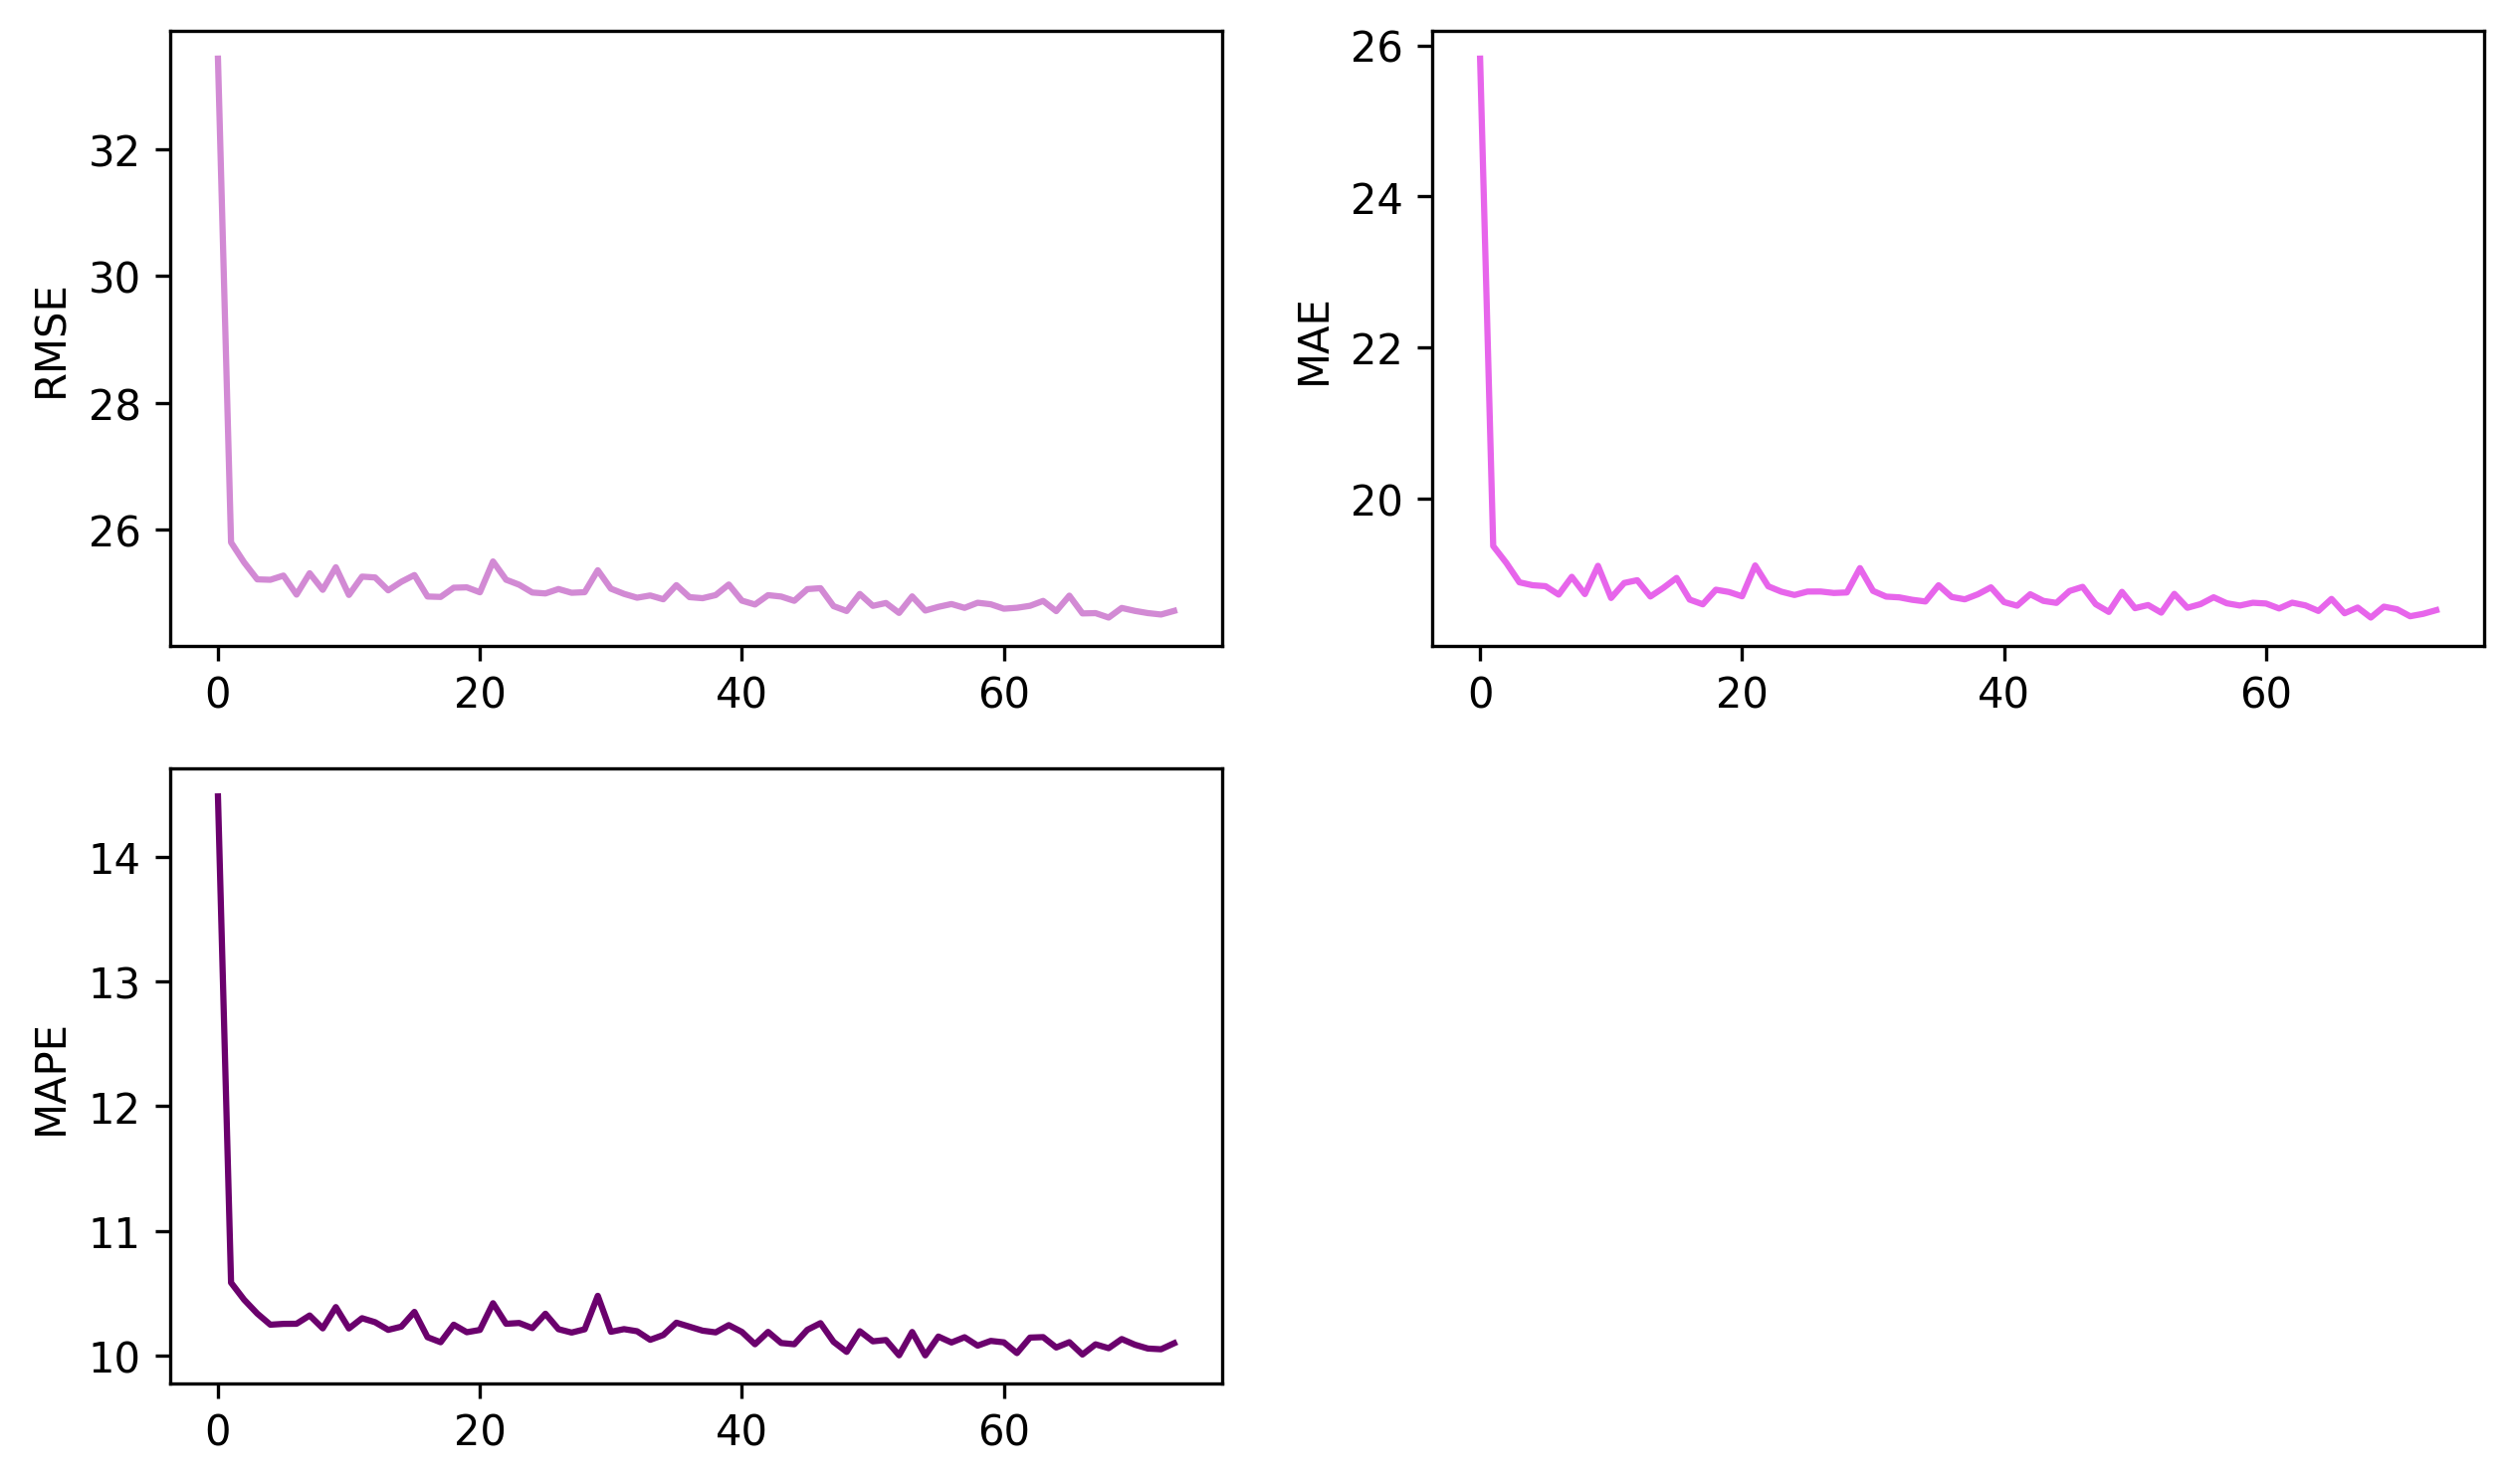

In [8]:
plot_metric(train_score_lst)

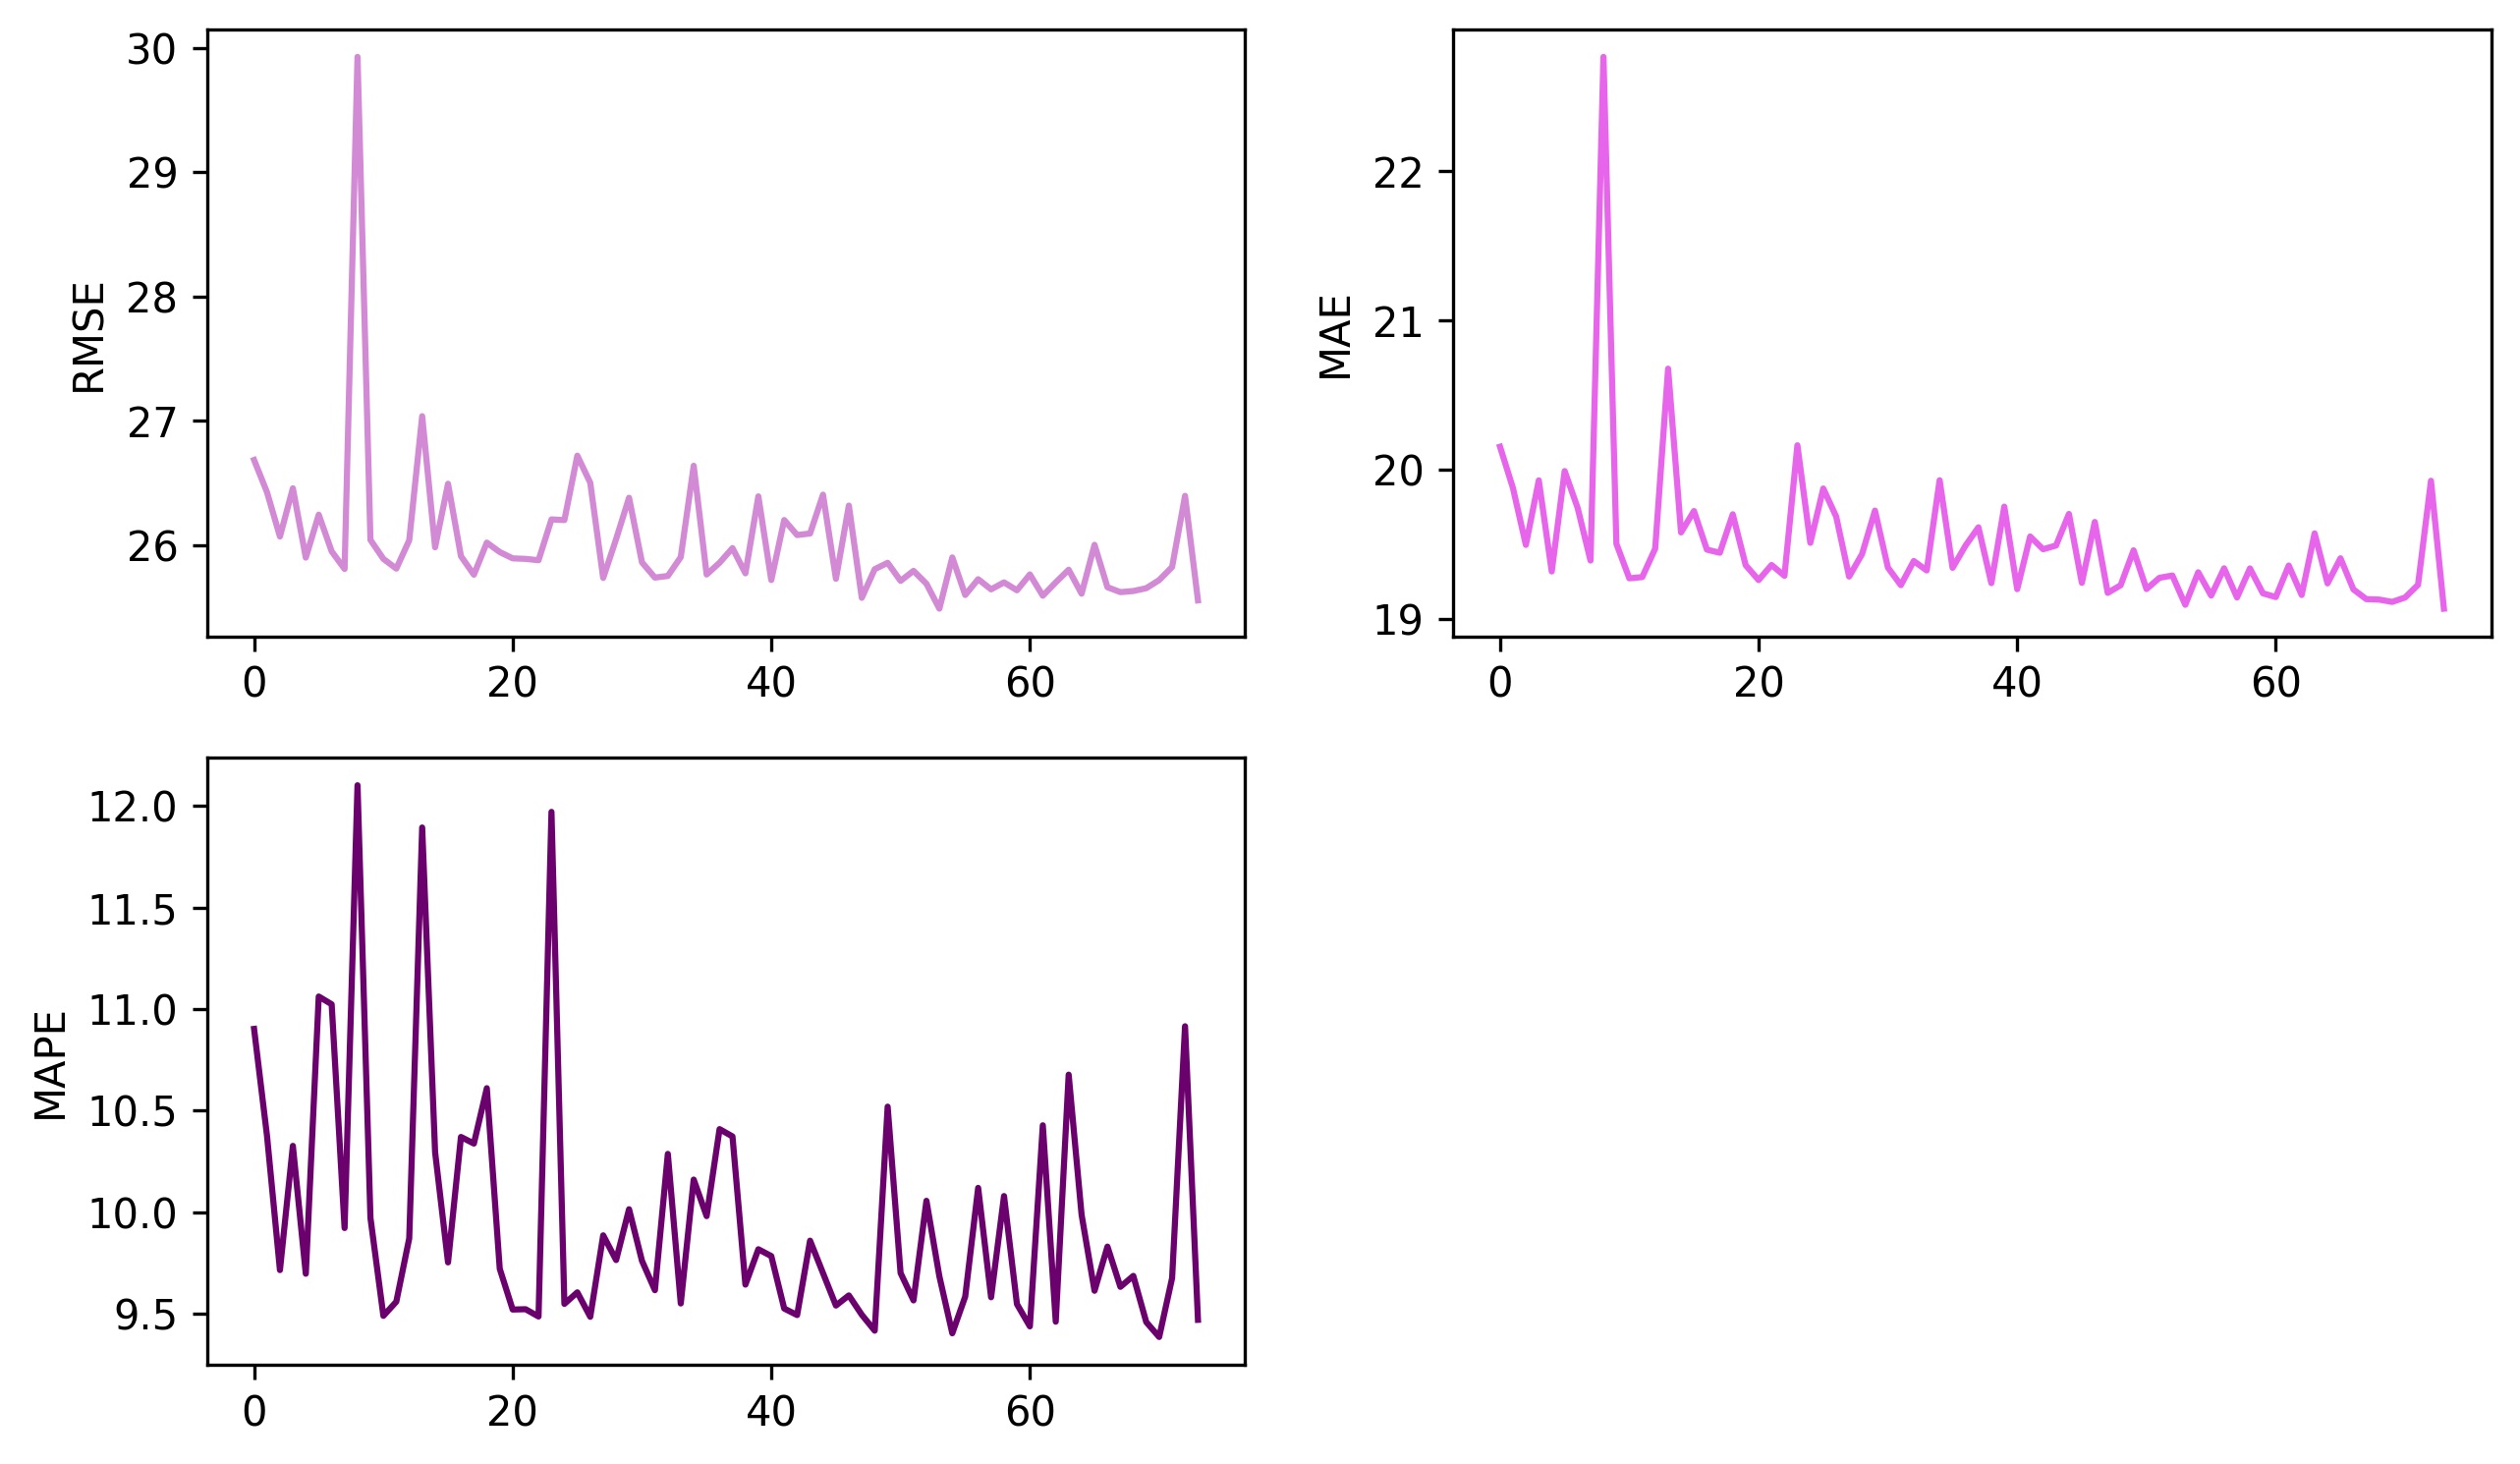

In [9]:
plot_metric(val_score_lst)

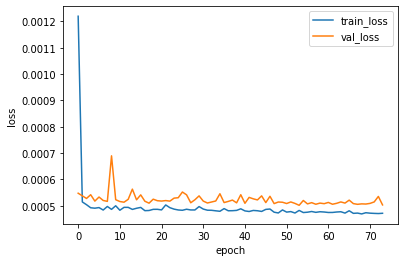

In [10]:
visualize(stop_epoch, train_loss_lst, val_loss_lst)

## 调用接口实现RNN

In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
input_size = train_set.X.shape[-1]
hidden_size = 64
output_size = 1
seq_len = 12
lr = 0.0001
epochs = 80
loss_func = nn.MSELoss()

nn_rnn = nn.RNN(input_size=input_size, hidden_size=hidden_size, num_layers=1, batch_first=True).to(device)
out_linear = nn.Sequential(nn.Linear(hidden_size, 1),
                           nn.LeakyReLU()).to(device)

optimizer = torch.optim.Adam(list(nn_rnn.parameters()) + list(out_linear.parameters()), lr)

train_loss_lst, val_loss_lst, \
    train_score_lst, val_score_lst, stop_epoch = train(nn_rnn, train_loader, val_loader, test_loader,
                                                       loss_func, traffic_dataset.denormalize, optimizer, epochs,
                                                       early_stop=20, device=device, output_model=out_linear)

*** epoch1, train loss 0.0122, train rmse 122.3405, val loss 0.0063, val rmse 91.083383, time use 0.891s
*** epoch2, train loss 0.0019, train rmse 45.5898, val loss 0.0009, val rmse 34.443199, time use 0.906s
*** epoch3, train loss 0.0008, train rmse 32.2163, val loss 0.0008, val rmse 33.203101, time use 0.828s
*** epoch4, train loss 0.0008, train rmse 31.4247, val loss 0.0008, val rmse 32.330141, time use 0.872s
*** epoch5, train loss 0.0007, train rmse 30.5606, val loss 0.0008, val rmse 31.439643, time use 0.963s
*** epoch6, train loss 0.0007, train rmse 29.8490, val loss 0.0007, val rmse 30.503632, time use 0.951s
*** epoch7, train loss 0.0007, train rmse 29.1795, val loss 0.0007, val rmse 30.176602, time use 1.009s
*** epoch8, train loss 0.0006, train rmse 28.5746, val loss 0.0007, val rmse 29.101420, time use 1.083s
*** epoch9, train loss 0.0006, train rmse 28.2354, val loss 0.0006, val rmse 28.684586, time use 1.001s
*** epoch10, train loss 0.0006, train rmse 27.8117, val loss 0.

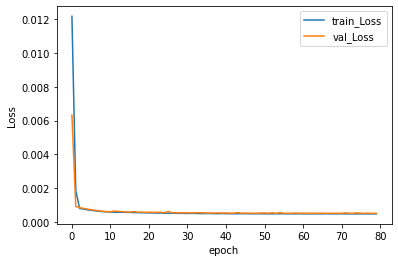

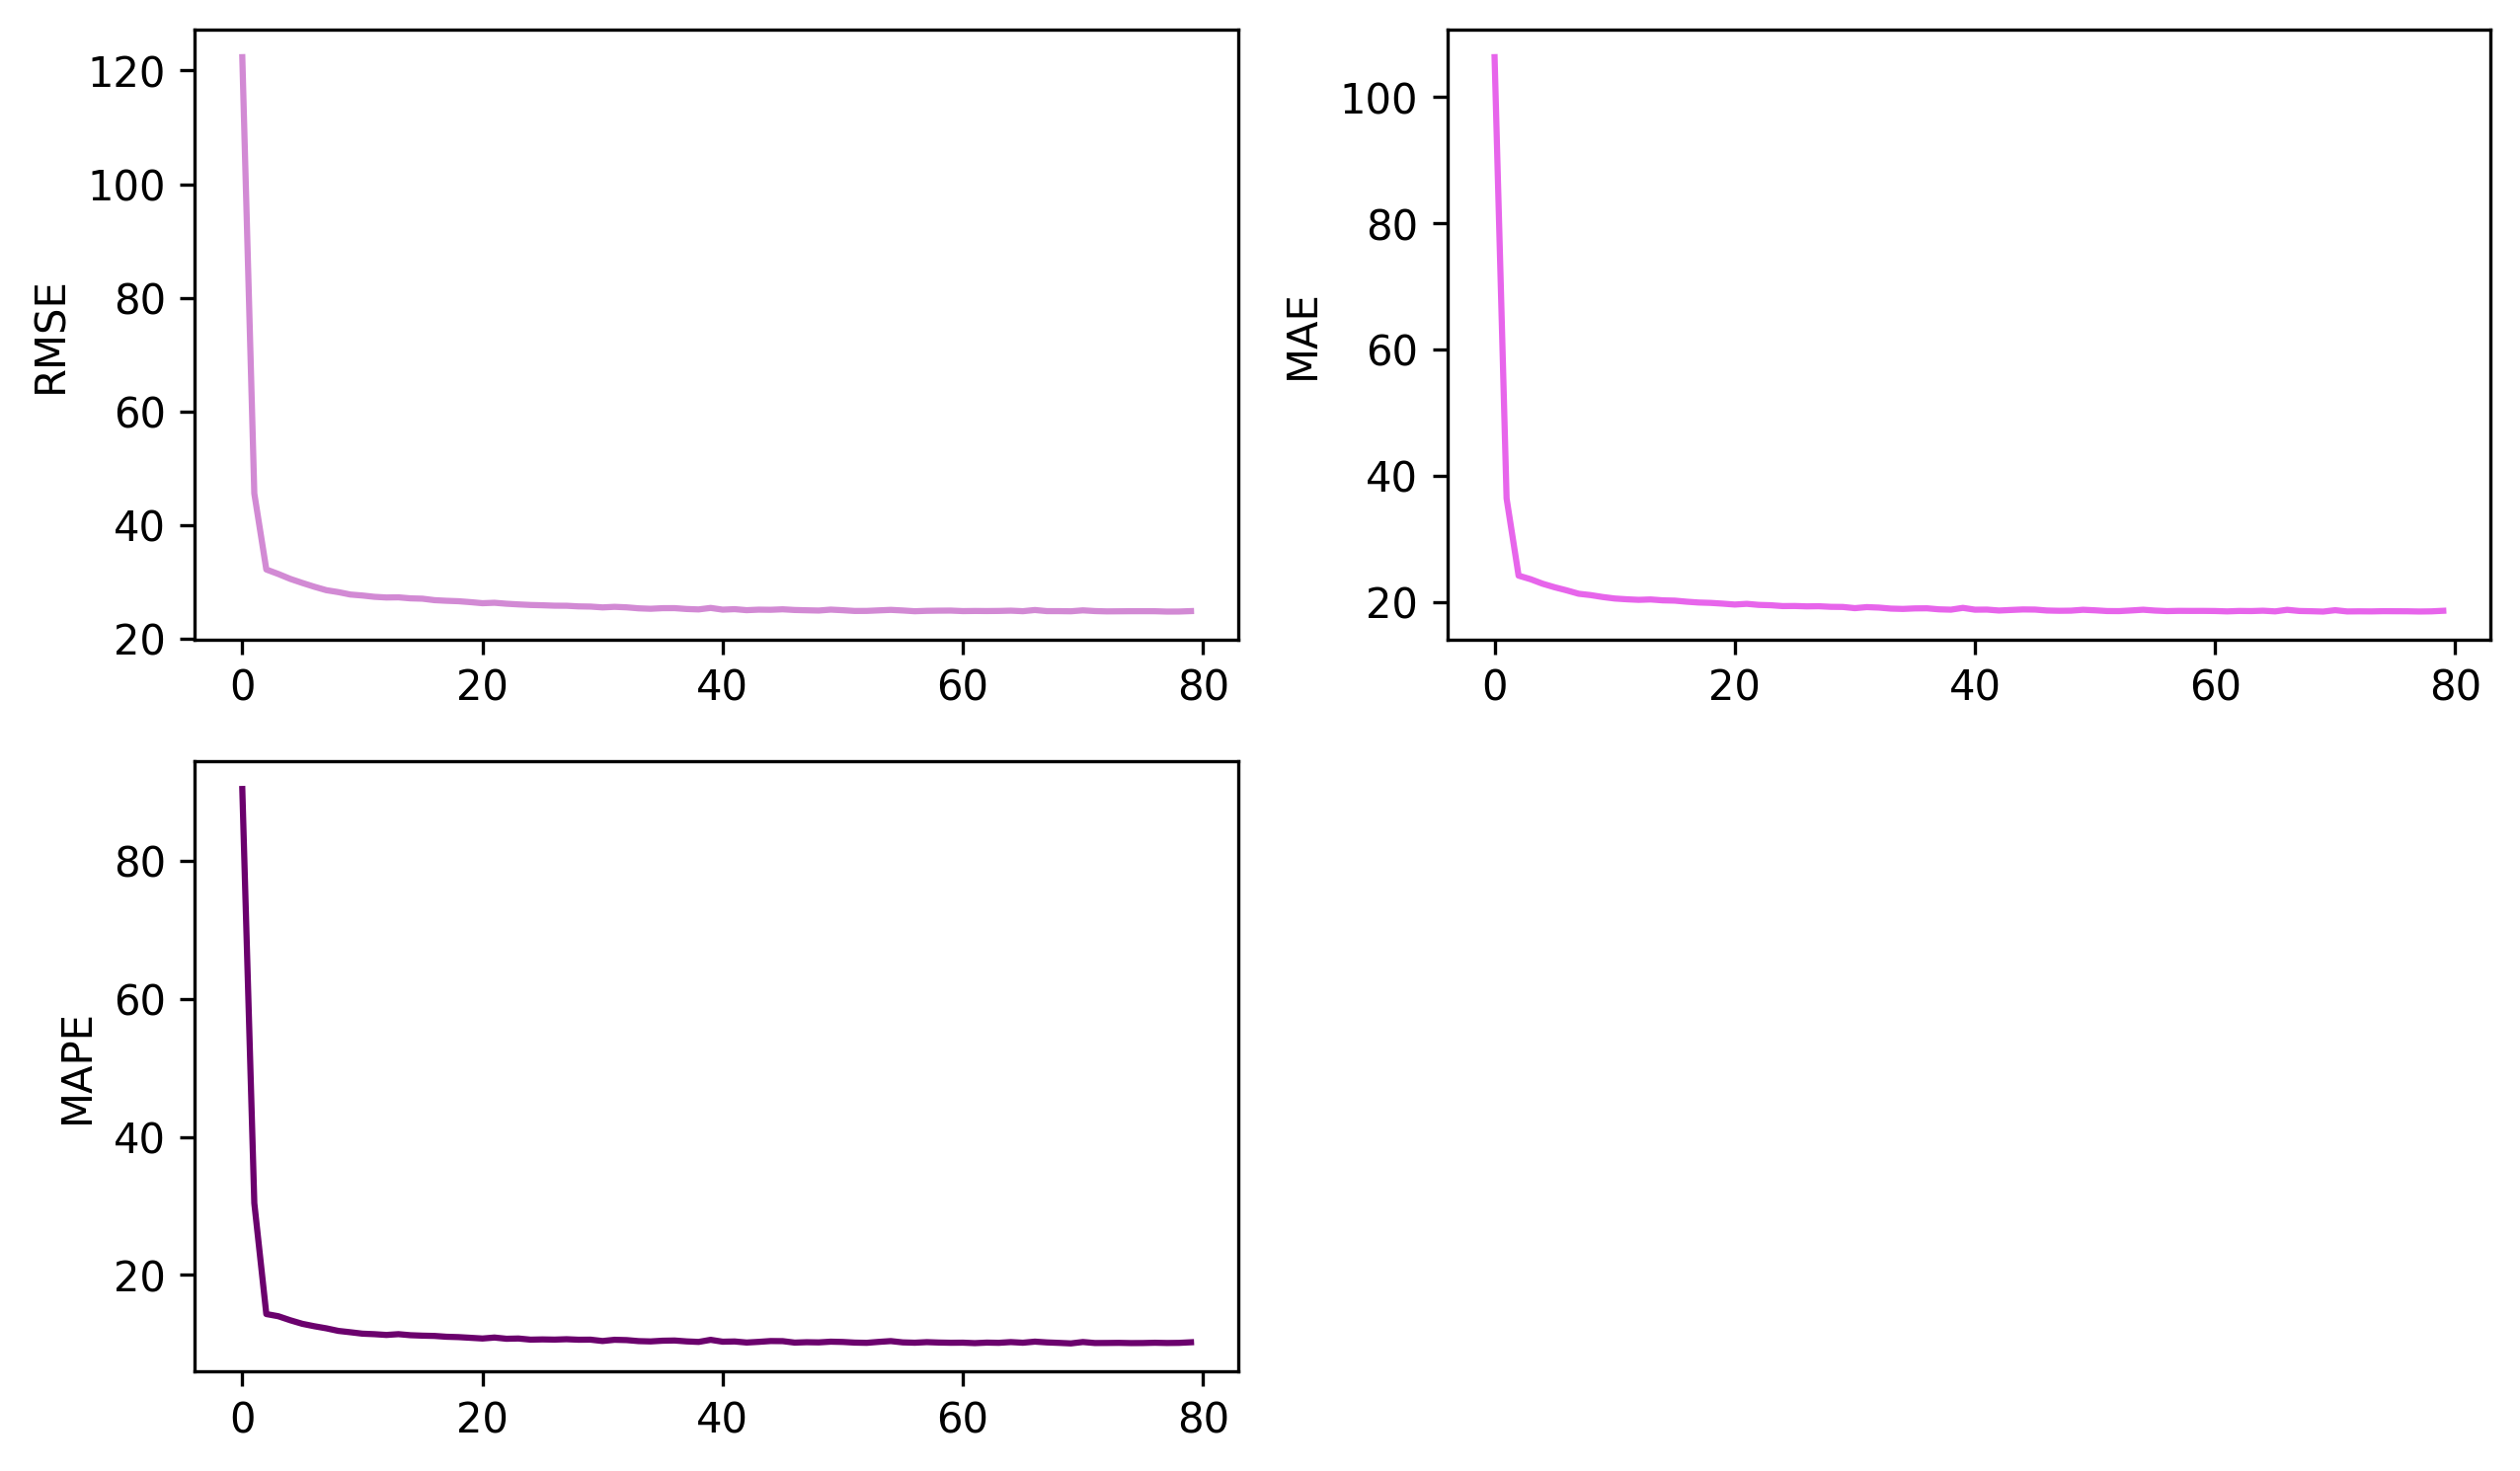

In [12]:
visualize(stop_epoch, train_loss_lst, val_loss_lst, y_label='Loss')
plot_metric(train_score_lst)

## LSTM手动实现

In [13]:
class My_LSTM(nn. Module):
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()
        self.hidden_size = hidden_size
        self.gates = nn.Linear(input_size + hidden_size, hidden_size * 4)
        self.sigmoid = nn.Sigmoid()
        self.tanh = nn. Tanh()
        self.output = nn.Sequential(
            nn.Linear(hidden_size, hidden_size // 2),
            nn.ReLU(),
            nn.Linear(hidden_size // 2, output_size)
        )
        for param in self.parameters():
            if param.dim() > 1:
                nn.init.xavier_uniform_(param)

    def forward(self, x):
        batch_size = x.size(0)
        seq_len = x.size(1)
        h, c = (torch.zeros(batch_size, self.hidden_size).to(x.device) for _ in range(2))
        y_list = []
        for i in range(seq_len):
            forget_gate, input_gate, output_gate, candidate_cell = \
                self.gates(torch.cat([x[:, i, :], h], dim=-1)).chunk(4, -1)
            forget_gate, input_gate, output_gate = (self.sigmoid(g)
                                                    for g in (forget_gate, input_gate, output_gate))
            c = forget_gate * c + input_gate * self.tanh(candidate_cell)
            h = output_gate * self.tanh(c)
            y_list.append(self.output(h))
        return torch.stack(y_list, dim=1), (h, c)

In [14]:
device = 'cuda:0'  # 如果电脑上无Nvidia显卡或未安装CUDA框架，请更改为 'cpu'
input_size = train_set.X.shape[-1]
hidden_size = 64
output_size = 1
seq_len = 12
lr = 0.001
epochs = 80
loss_func = nn.MSELoss()

my_lstm = My_LSTM(input_size, hidden_size, output_size).to(device)
optimizer = torch.optim.Adam(my_lstm.parameters(), lr)

In [15]:
train_loss_lst, val_loss_lst, train_score_lst, val_score_lst, stop_epoch = train(my_lstm, train_loader, val_loader, test_loader, loss_func, traffic_dataset.denormalize, optimizer, epochs, early_stop=20, device=device, output_model=None)

*** epoch1, train loss 0.0046, train rmse 62.3397, val loss 0.0007, val rmse 30.065880, time use 4.100s
*** epoch2, train loss 0.0006, train rmse 28.3411, val loss 0.0006, val rmse 28.566606, time use 3.897s
*** epoch3, train loss 0.0006, train rmse 26.9842, val loss 0.0006, val rmse 28.407181, time use 3.755s
*** epoch4, train loss 0.0005, train rmse 26.3090, val loss 0.0006, val rmse 27.203968, time use 3.395s
*** epoch5, train loss 0.0005, train rmse 26.0043, val loss 0.0005, val rmse 26.385420, time use 3.586s
*** epoch6, train loss 0.0005, train rmse 25.5095, val loss 0.0005, val rmse 26.020462, time use 3.414s
*** epoch7, train loss 0.0005, train rmse 25.4721, val loss 0.0005, val rmse 26.514132, time use 4.834s
*** epoch8, train loss 0.0005, train rmse 25.2524, val loss 0.0005, val rmse 25.773642, time use 5.491s
*** epoch9, train loss 0.0005, train rmse 25.2275, val loss 0.0006, val rmse 27.050747, time use 5.233s
*** epoch10, train loss 0.0005, train rmse 25.3103, val loss 0.0

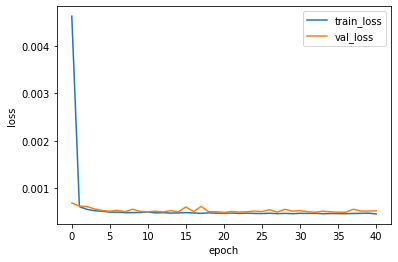

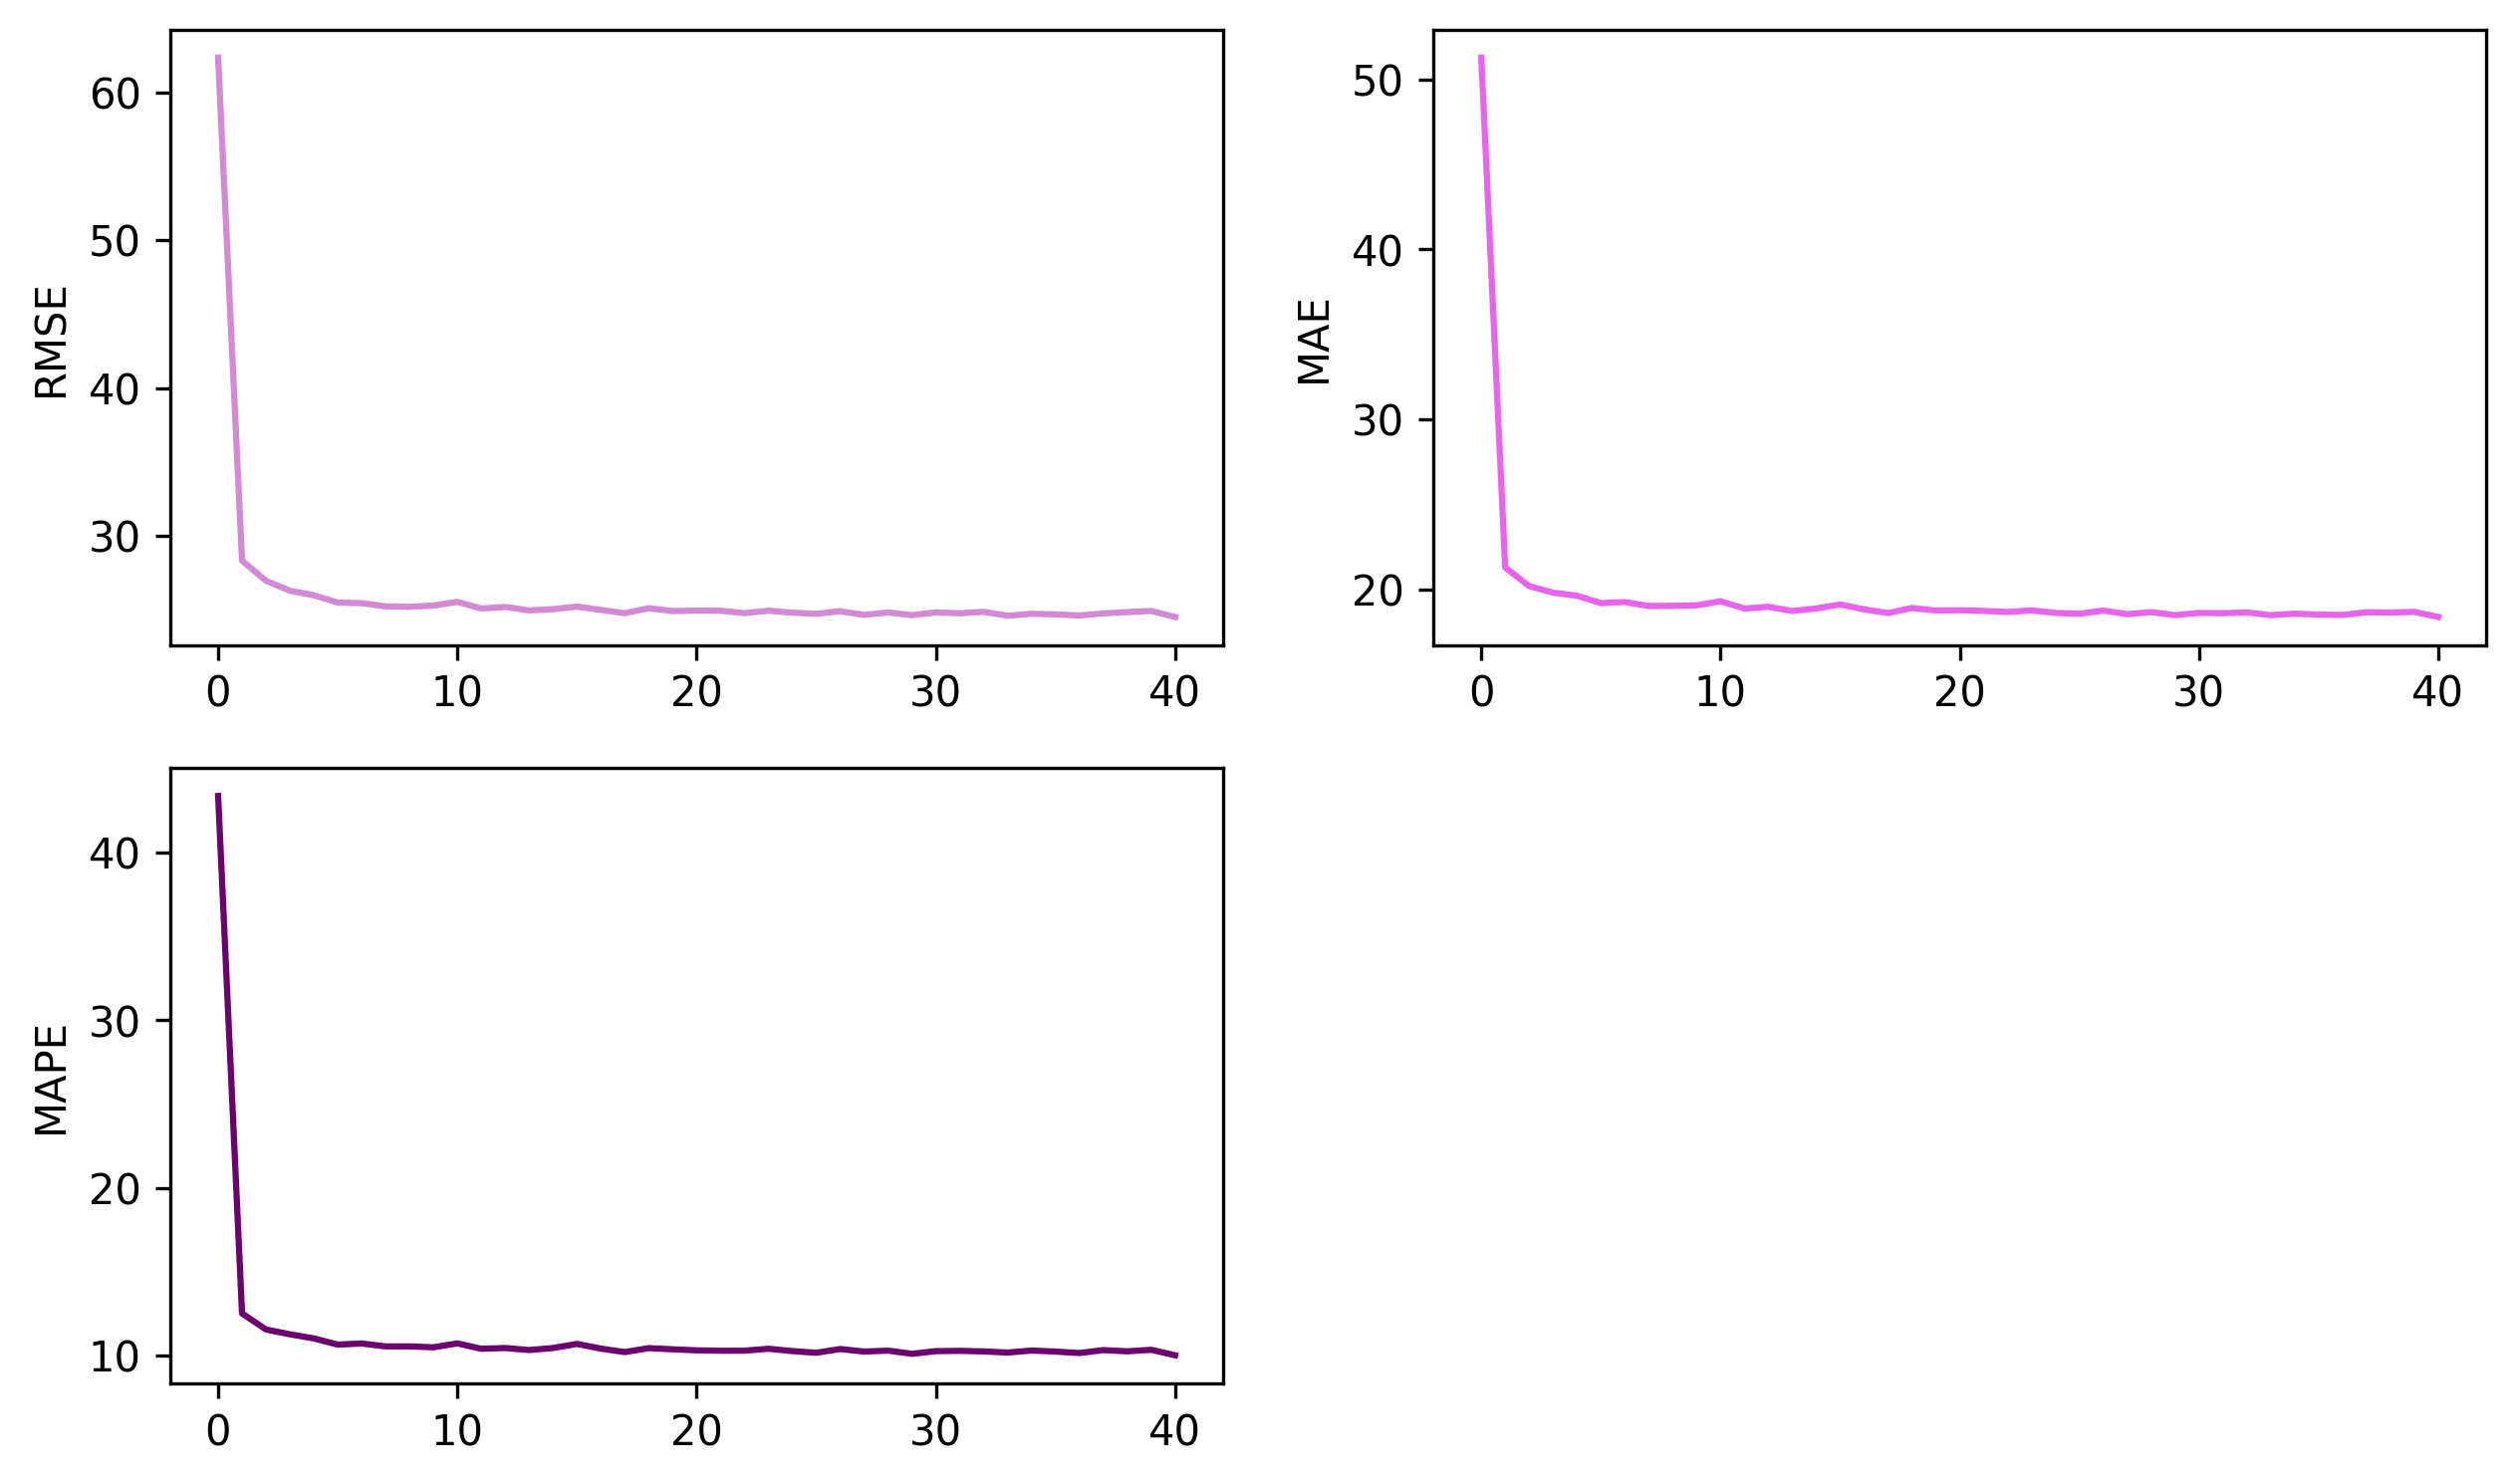

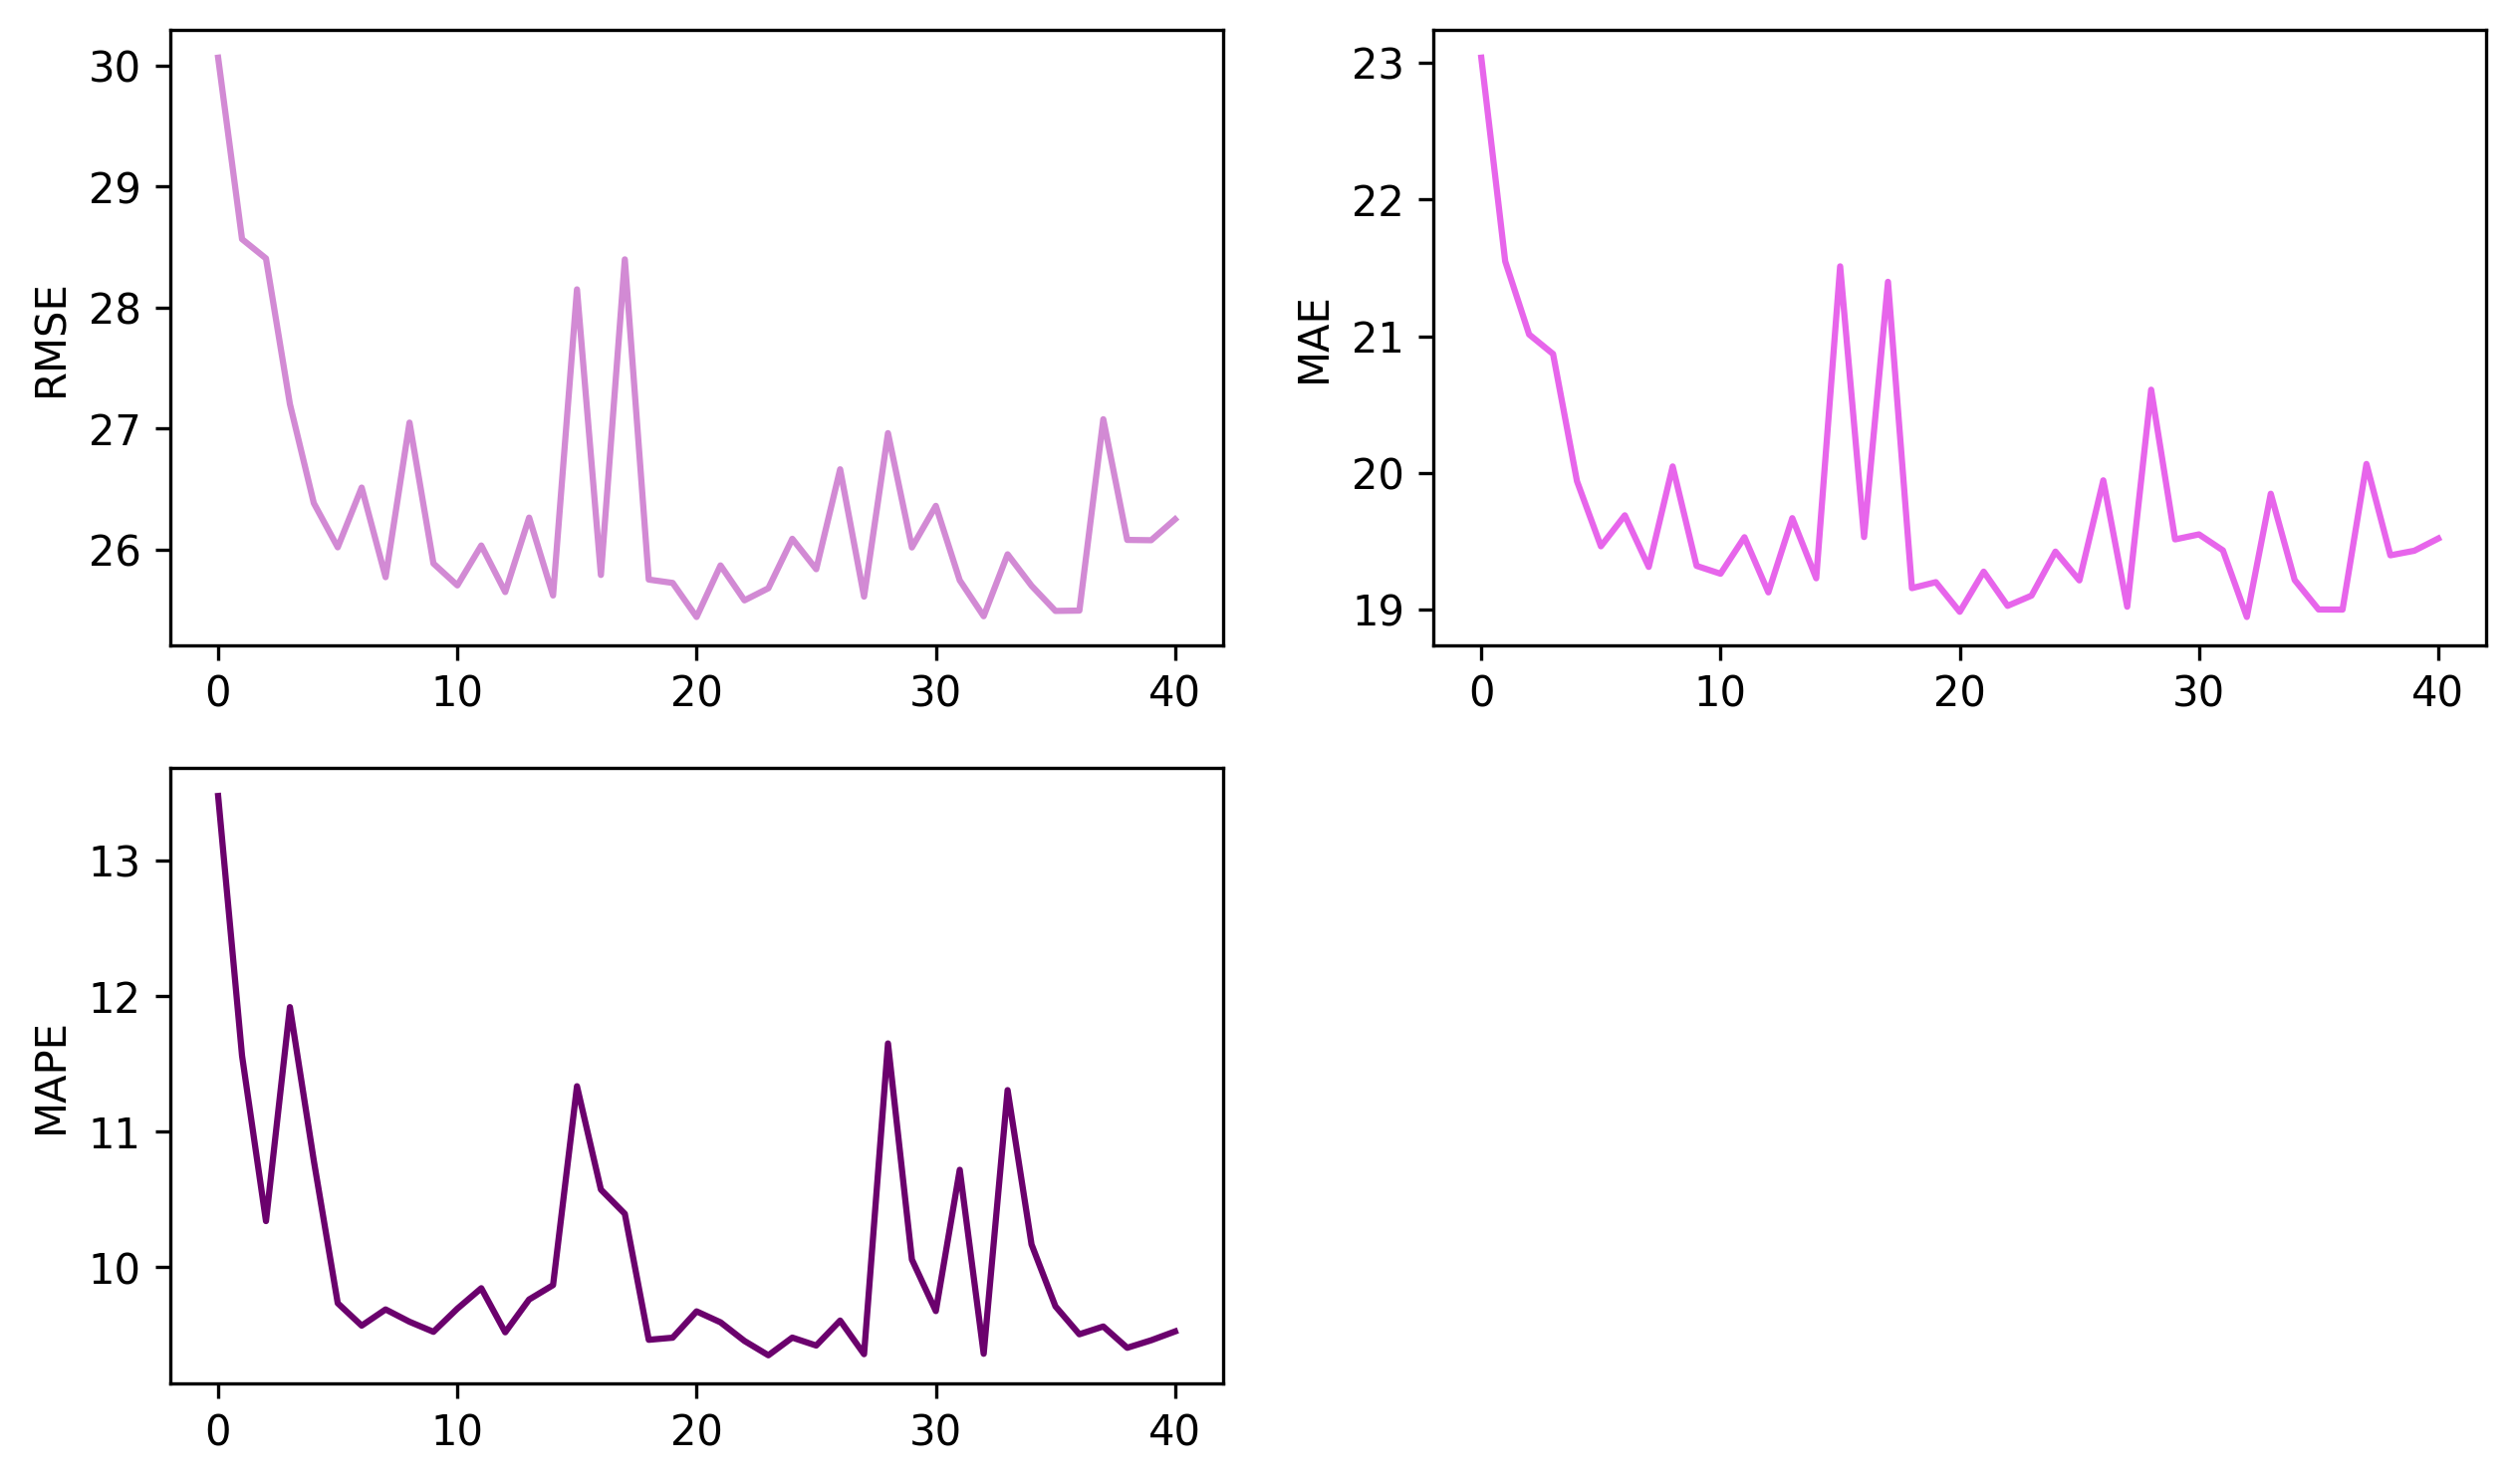

In [16]:
visualize(stop_epoch, train_loss_lst, val_loss_lst)
plot_metric(train_score_lst)
plot_metric(val_score_lst)

## 调用接口实现LSTM

In [17]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
input_size = train_set.X.shape[-1]
hidden_size = 64
output_size = 1
seq_len = 12
lr = 0.0001
epochs = 80
loss_func = nn.MSELoss()

nn_lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=1, batch_first=True).to(device)
out_linear = nn.Sequential(nn.Linear(hidden_size, 1),
                           nn.LeakyReLU()).to(device)

optimizer = torch.optim.Adam(list(nn_lstm.parameters()) + list(out_linear.parameters()), lr)

train_loss_lst, val_loss_lst, \
    train_score_lst, val_score_lst, stop_epoch = train(nn_lstm, train_loader, val_loader, test_loader,
                                                       loss_func, traffic_dataset.denormalize, optimizer, epochs,
                                                       early_stop=20, device=device, output_model=out_linear)

*** epoch1, train loss 0.0284, train rmse 181.6789, val loss 0.0098, val rmse 113.285323, time use 0.918s
*** epoch2, train loss 0.0084, train rmse 104.6079, val loss 0.0074, val rmse 98.396283, time use 0.905s
*** epoch3, train loss 0.0052, train rmse 81.8276, val loss 0.0029, val rmse 61.354886, time use 0.966s
*** epoch4, train loss 0.0014, train rmse 42.3866, val loss 0.0012, val rmse 38.675740, time use 0.948s
*** epoch5, train loss 0.0010, train rmse 36.0068, val loss 0.0012, val rmse 38.931810, time use 0.912s
*** epoch6, train loss 0.0010, train rmse 35.4976, val loss 0.0011, val rmse 37.903999, time use 1.032s
*** epoch7, train loss 0.0009, train rmse 34.9178, val loss 0.0010, val rmse 36.809686, time use 1.037s
*** epoch8, train loss 0.0009, train rmse 34.4781, val loss 0.0010, val rmse 36.486911, time use 1.018s
*** epoch9, train loss 0.0009, train rmse 33.9083, val loss 0.0010, val rmse 35.603311, time use 0.876s
*** epoch10, train loss 0.0009, train rmse 33.3645, val loss 

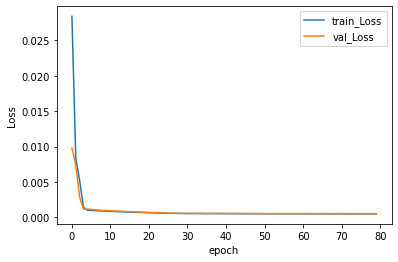

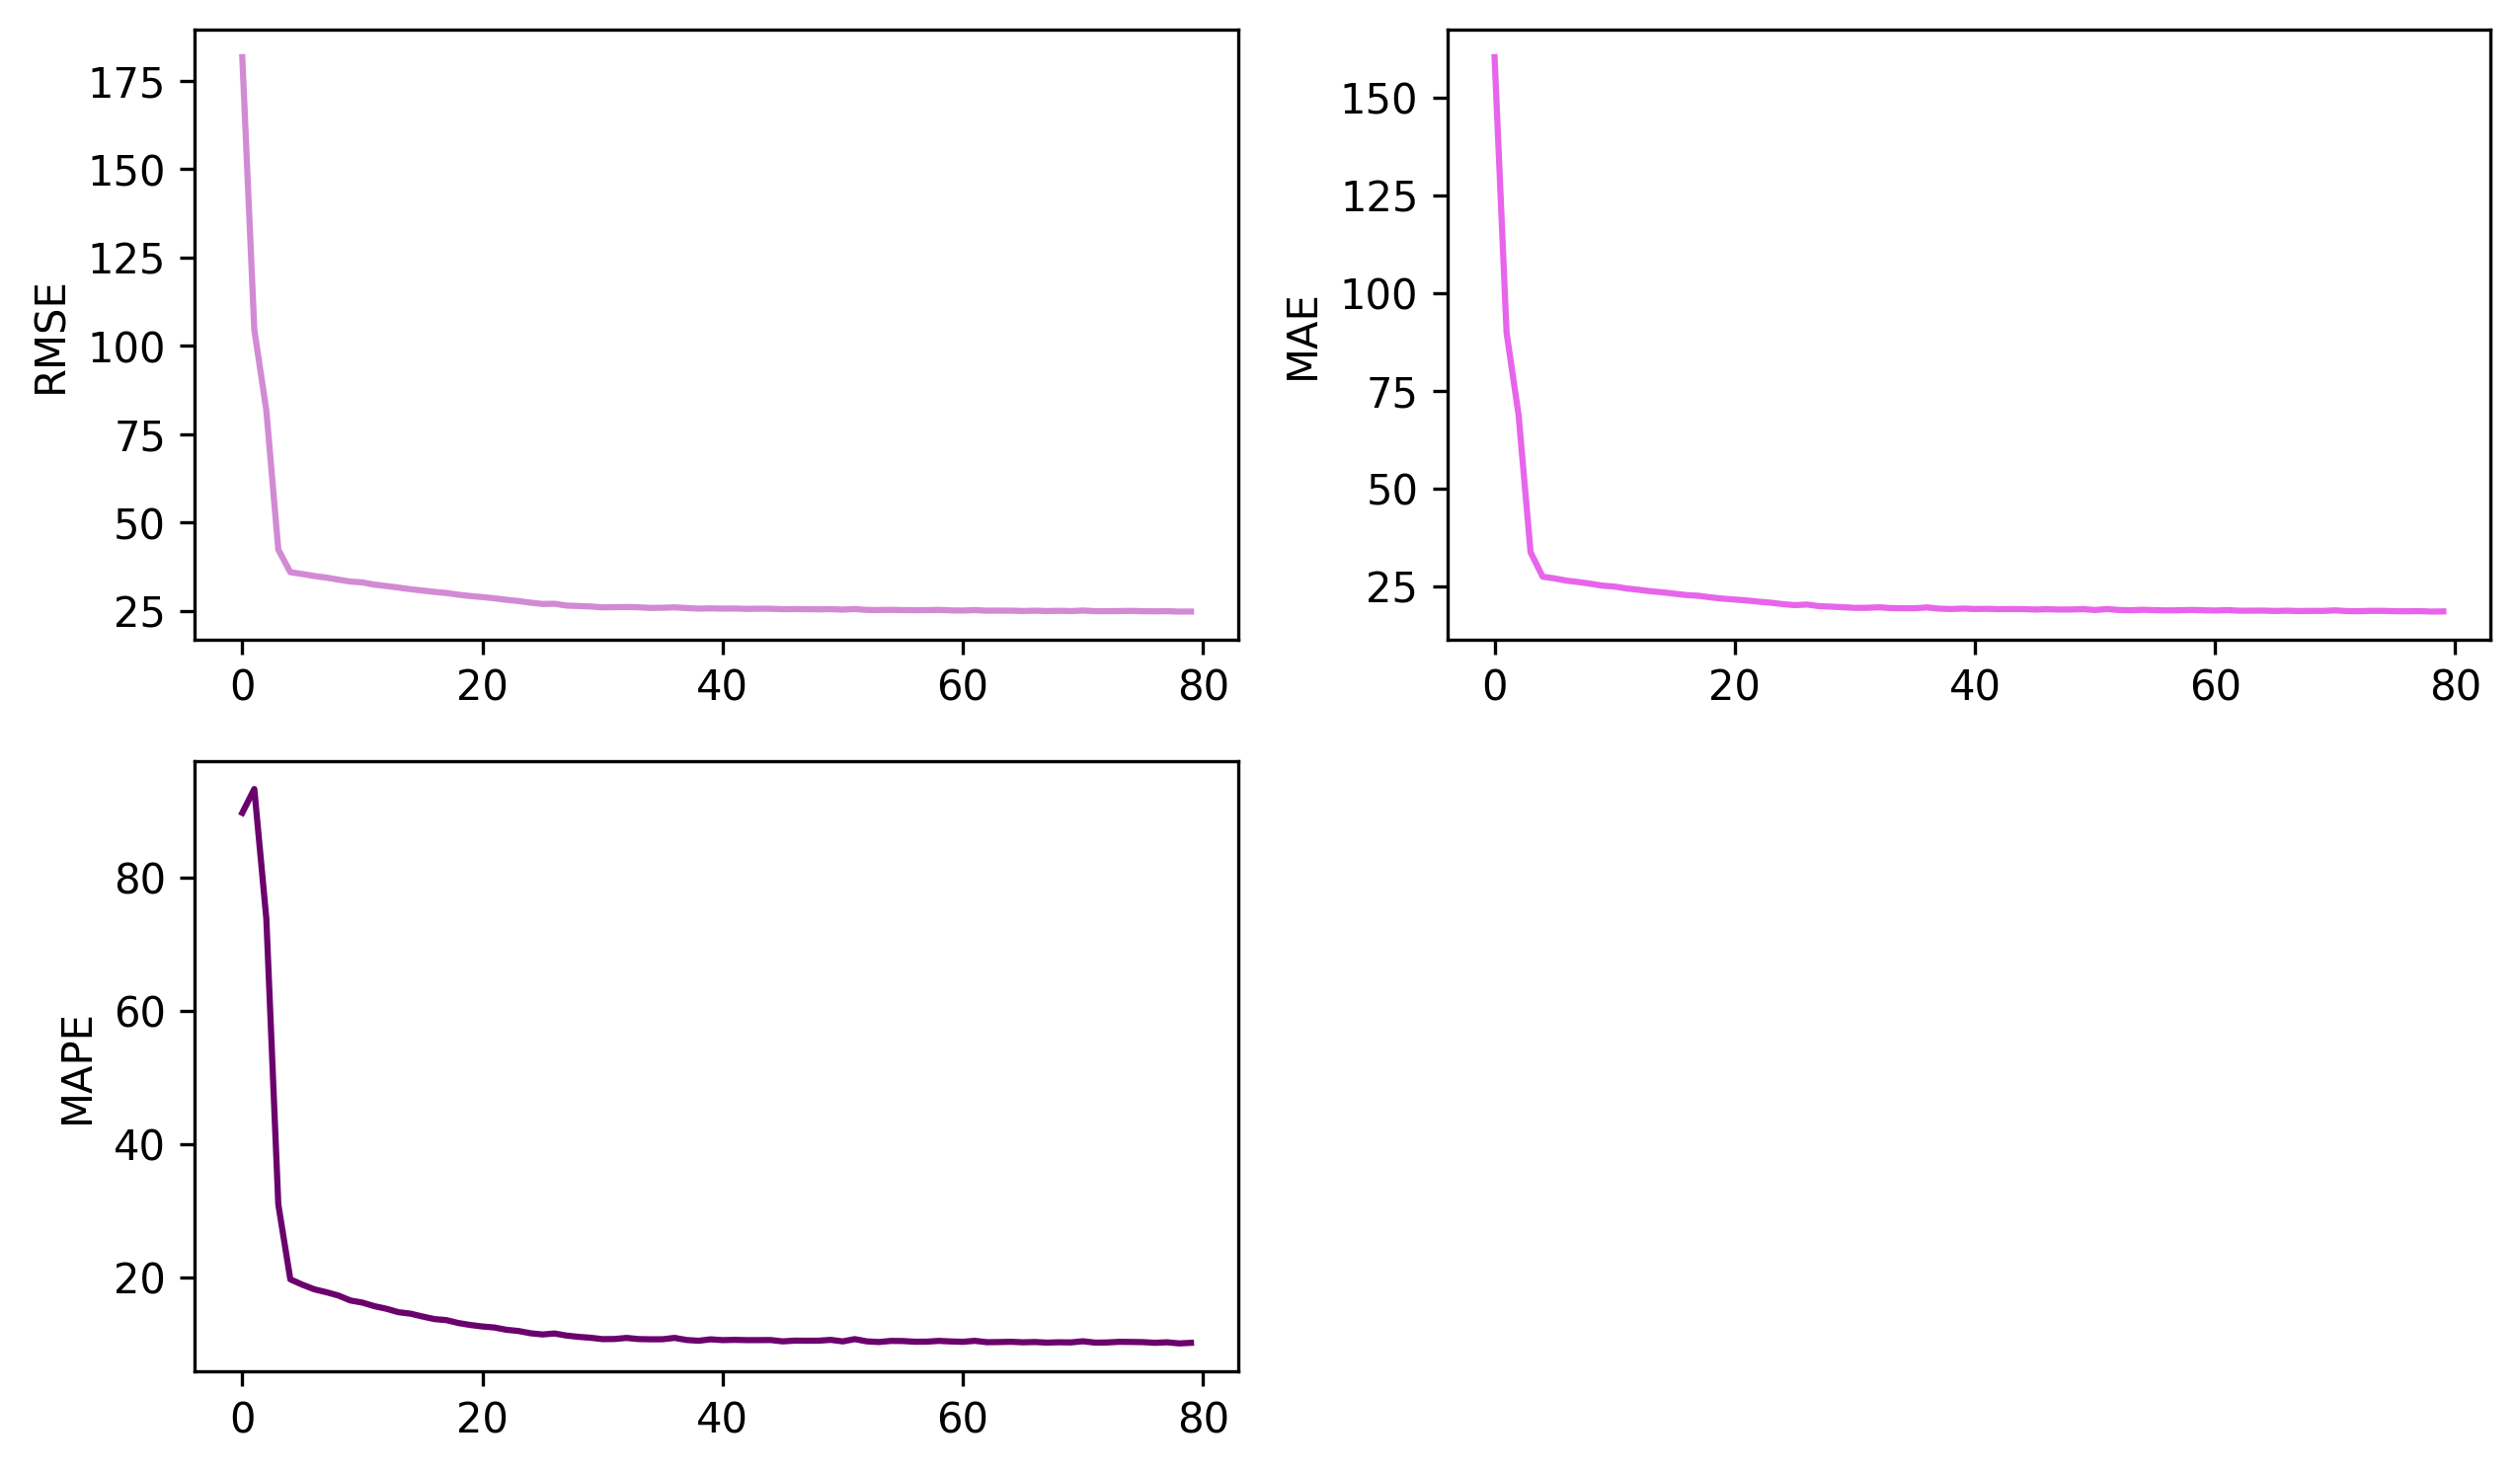

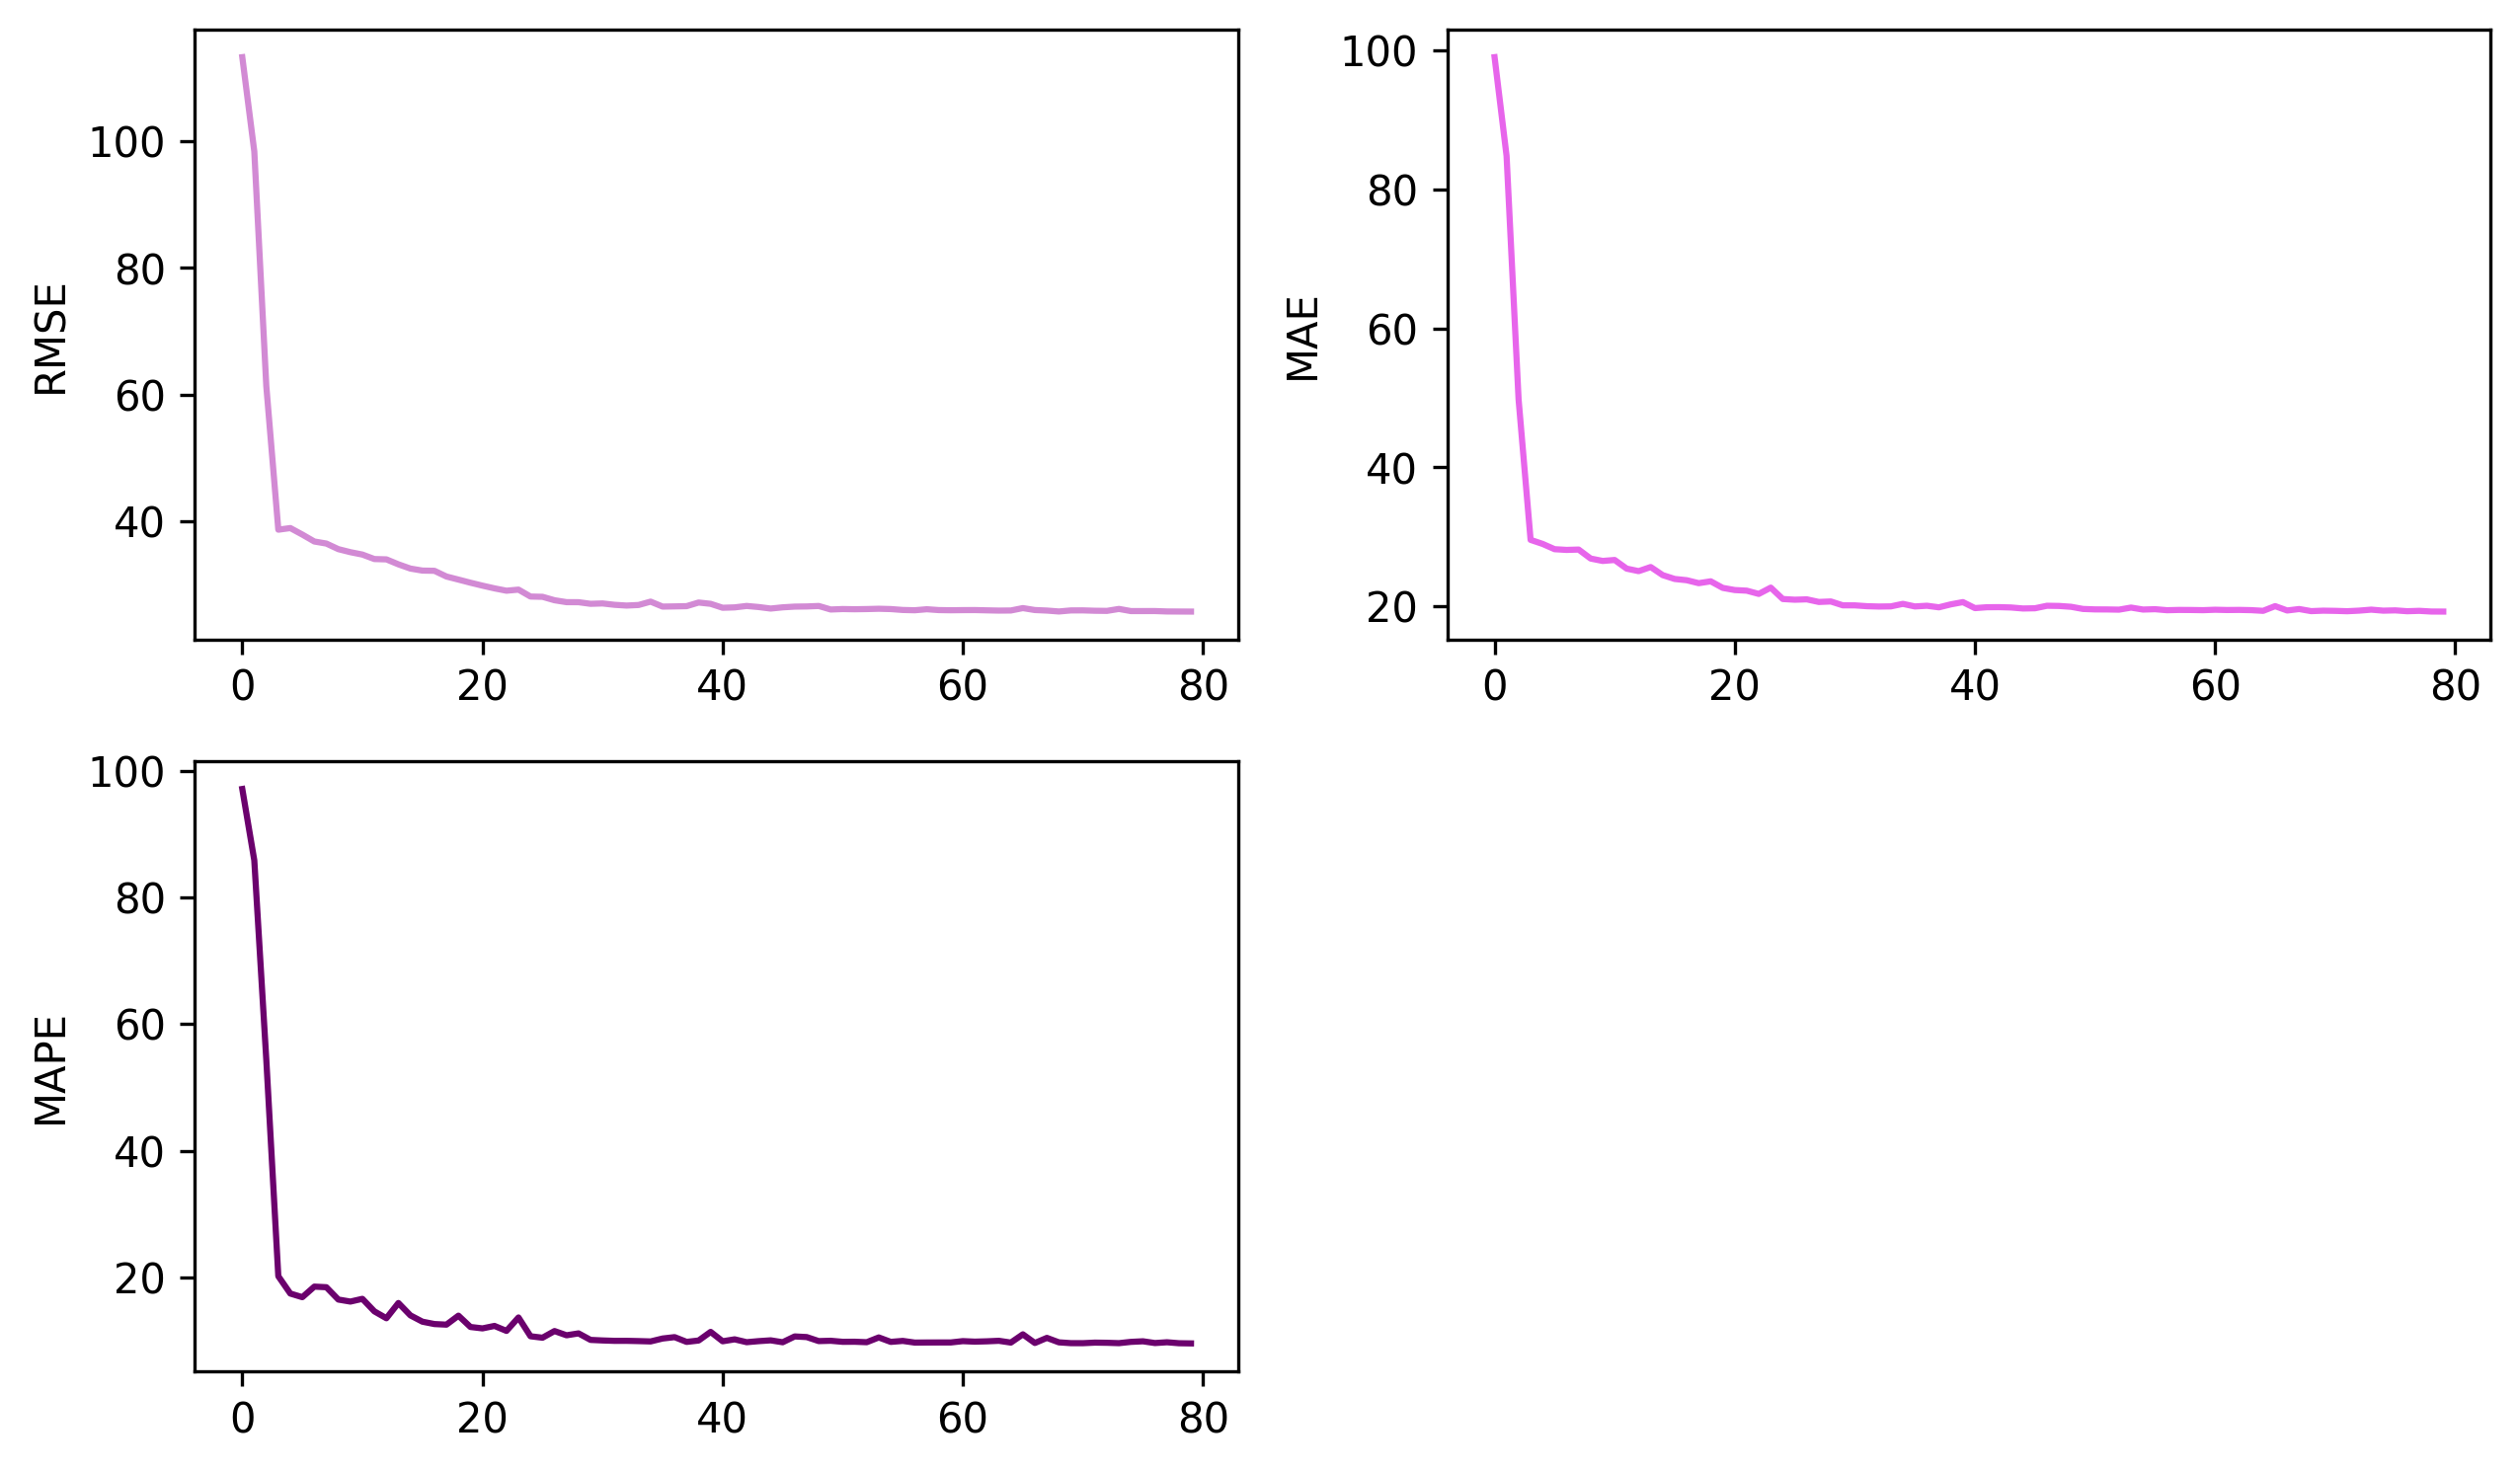

In [18]:
visualize(stop_epoch, train_loss_lst, val_loss_lst, y_label='Loss')
plot_metric(train_score_lst)
plot_metric(val_score_lst)

## 手动实现GRU

In [19]:
class My_GRU(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()
        self.hidden_size = hidden_size
        
        self.gates = nn.Linear(input_size+hidden_size, hidden_size*2)
        # 用于计算candidate hidden state
        self.hidden_transform = nn.Linear(input_size+hidden_size, hidden_size)
        
        self.sigmoid = nn.Sigmoid()
        self.tanh = nn.Tanh()
        
        self.output = nn.Sequential(
            nn.Linear(hidden_size, hidden_size // 2),
            nn.ReLU(),
            nn.Linear(hidden_size // 2, output_size)
        )
            
        for param in self.parameters():
            if param.dim() > 1:
                nn.init.xavier_uniform_(param)
                
    def forward(self, x):
        batch_size = x.size(0)
        seq_len = x.size(1)
        
        h = torch.zeros(batch_size, self.hidden_size).to(x.device)
        y_list = []
        for i in range(seq_len):
            update_gate, reset_gate = self.gates(torch.cat([x[:, i, :], h], dim=-1)).chunk(2, -1)
            update_gate, reset_gate = (self.sigmoid(gate) for gate in (update_gate, reset_gate))
            candidate_hidden = self.tanh(self.hidden_transform(torch.cat([x[:, i, :], reset_gate * h], dim=-1)))
            h = (1-update_gate) * h + update_gate * candidate_hidden
            y_list.append(self.output(h))
        return torch.stack(y_list, dim=1), h

In [20]:
device = 'cuda:0'  # 如果电脑上无Nvidia显卡或未安装CUDA框架，请更改为 'cpu'
input_size = train_set.X.shape[-1]
hidden_size = 64
output_size = 1
seq_len = 12
lr = 0.001
epochs = 80
loss_func = nn.MSELoss()

my_gru = My_GRU(input_size, hidden_size, output_size).to(device)
optimizer = torch.optim.Adam(my_gru.parameters(), lr)

In [21]:
train_loss_lst, val_loss_lst, train_score_lst, val_score_lst, stop_epoch = train(my_lstm, train_loader, val_loader, test_loader, loss_func, traffic_dataset.denormalize, optimizer, epochs, early_stop=20, device=device, output_model=None)

*** epoch1, train loss 0.0005, train rmse 24.9969, val loss 0.0005, val rmse 26.155446, time use 3.710s
*** epoch2, train loss 0.0005, train rmse 24.9757, val loss 0.0005, val rmse 26.094502, time use 3.534s
*** epoch3, train loss 0.0005, train rmse 25.0179, val loss 0.0005, val rmse 26.227810, time use 3.549s
*** epoch4, train loss 0.0005, train rmse 24.9894, val loss 0.0005, val rmse 26.237809, time use 3.421s
*** epoch5, train loss 0.0005, train rmse 25.0070, val loss 0.0005, val rmse 26.149347, time use 3.336s
*** epoch6, train loss 0.0005, train rmse 24.9819, val loss 0.0005, val rmse 26.179332, time use 3.275s
*** epoch7, train loss 0.0005, train rmse 25.0277, val loss 0.0005, val rmse 26.186175, time use 3.125s
*** epoch8, train loss 0.0005, train rmse 24.9879, val loss 0.0005, val rmse 26.243345, time use 3.267s
*** epoch9, train loss 0.0005, train rmse 25.0073, val loss 0.0005, val rmse 26.121059, time use 3.259s
*** epoch10, train loss 0.0005, train rmse 24.9651, val loss 0.0

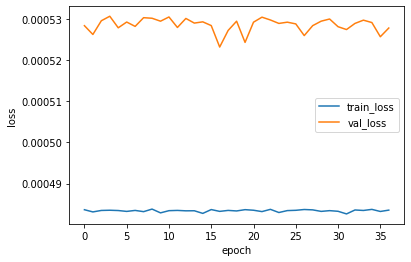

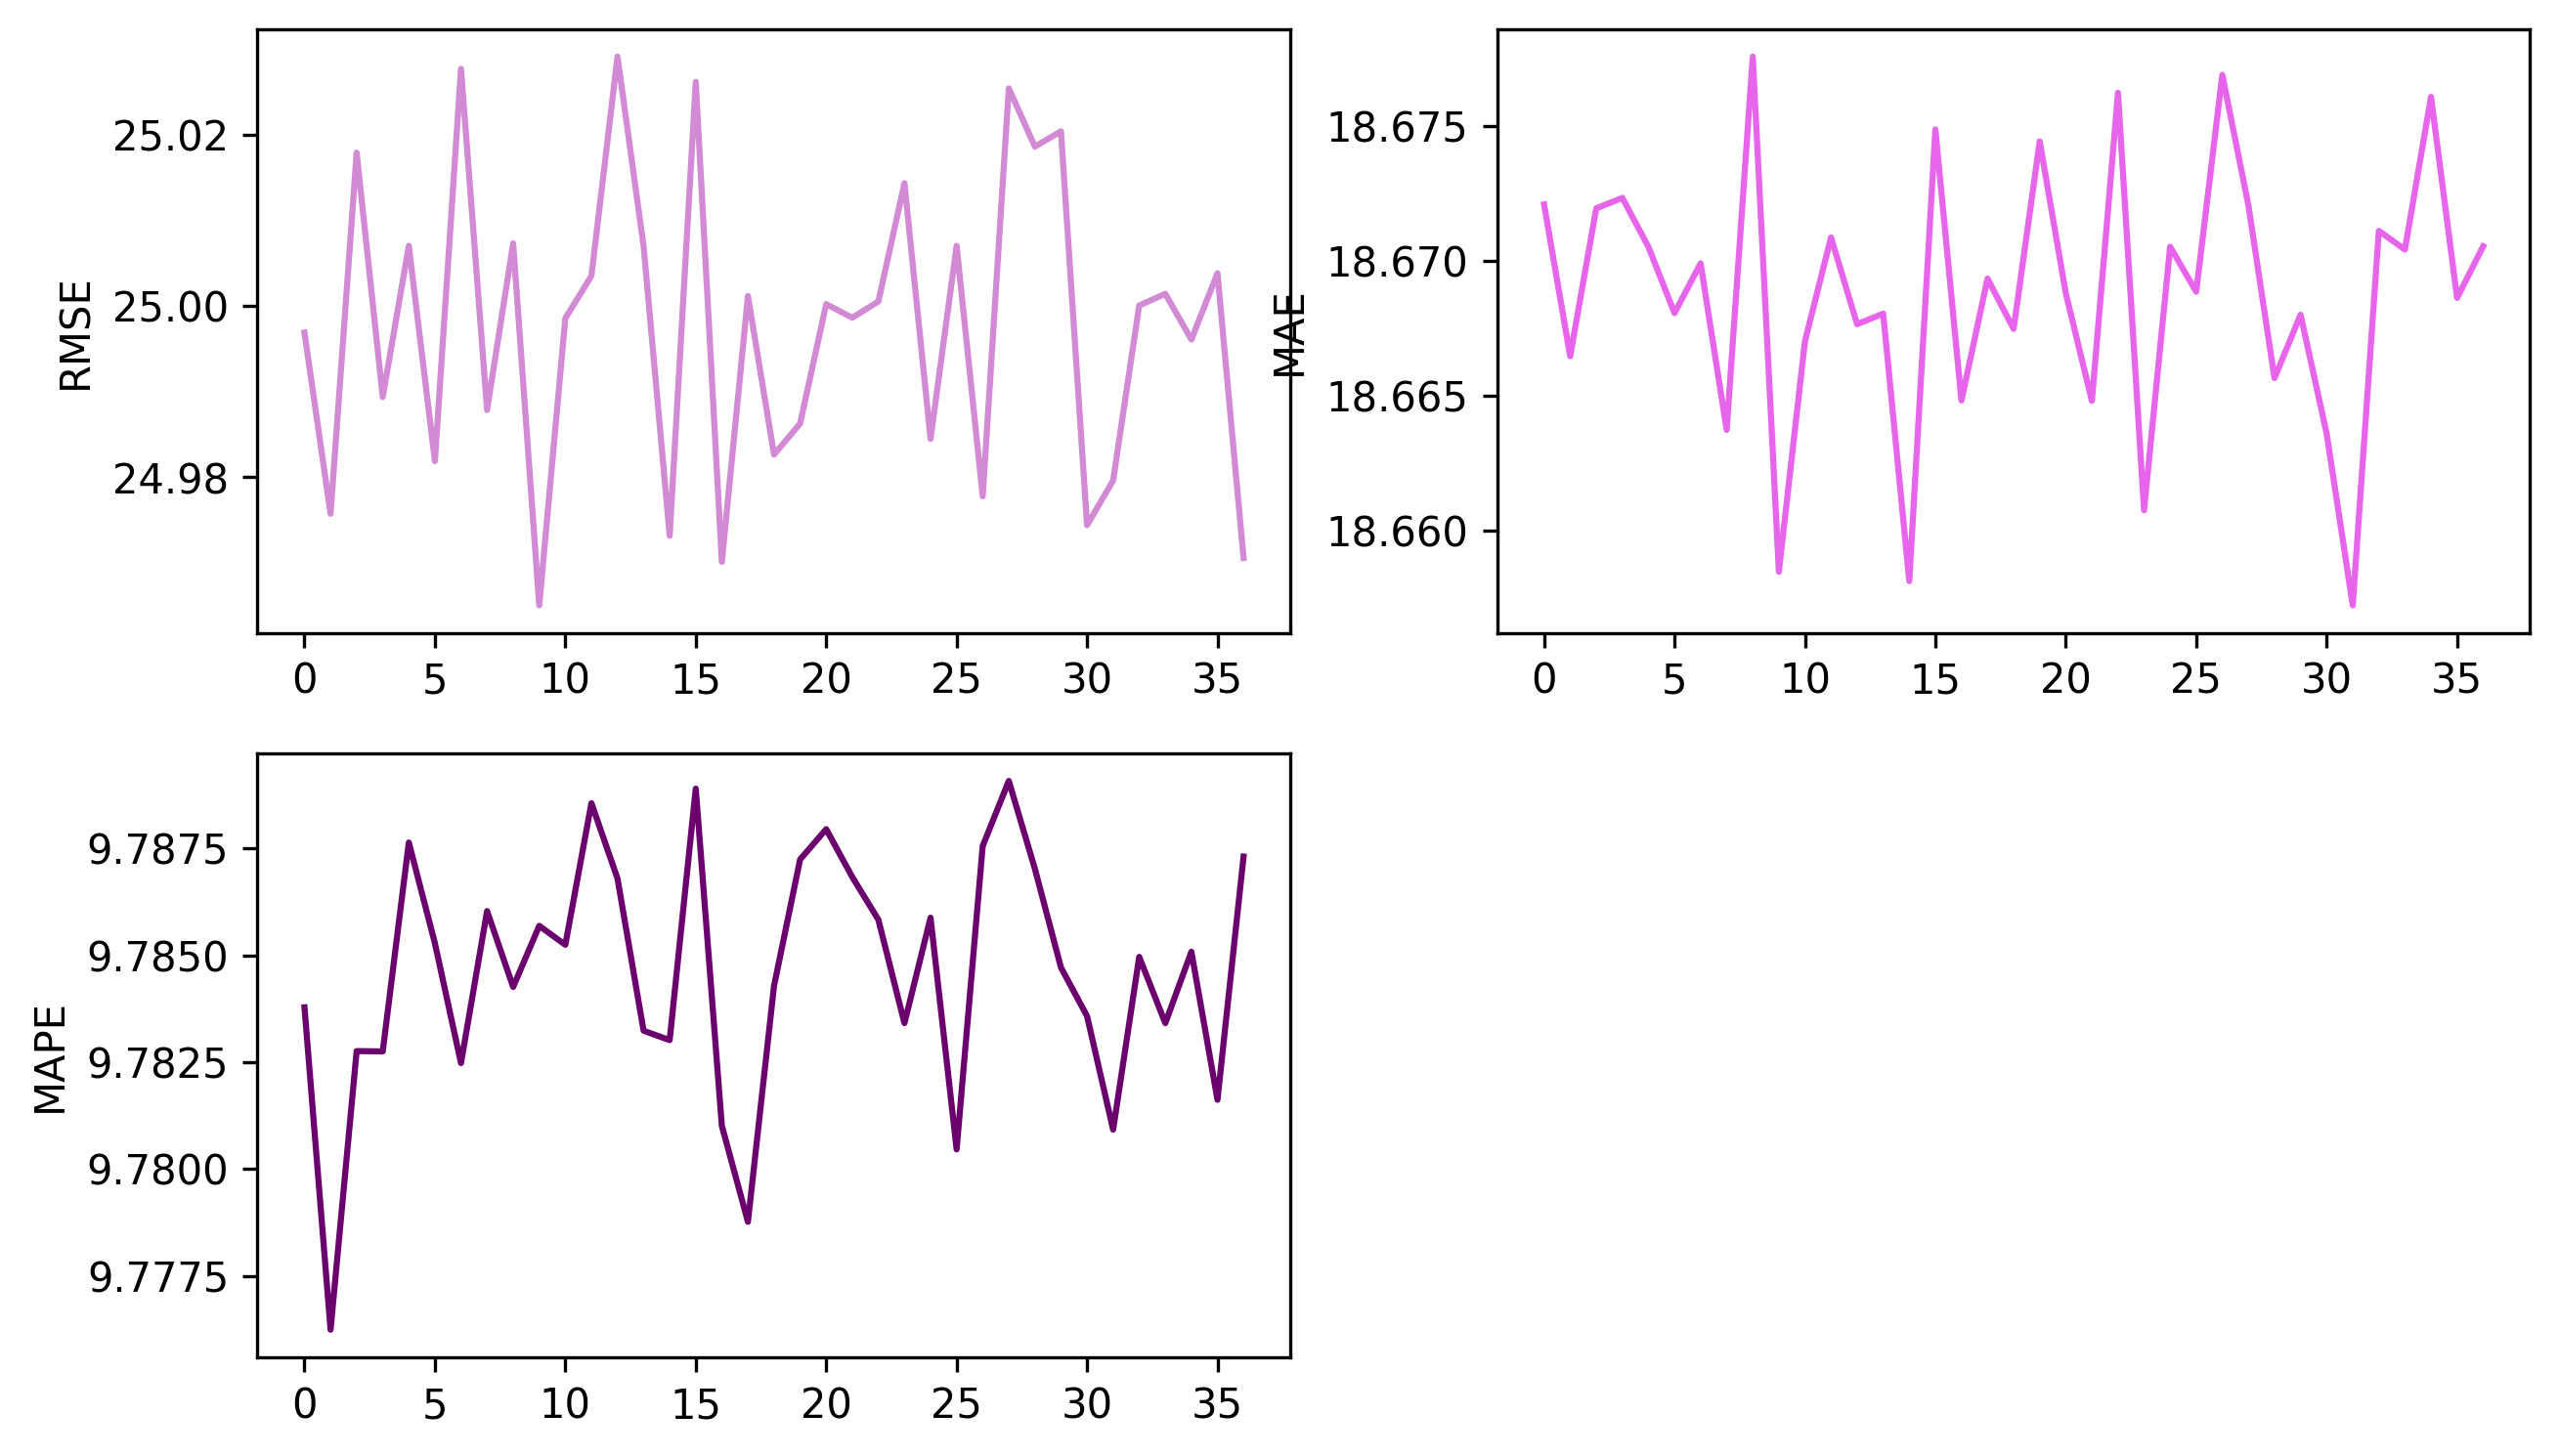

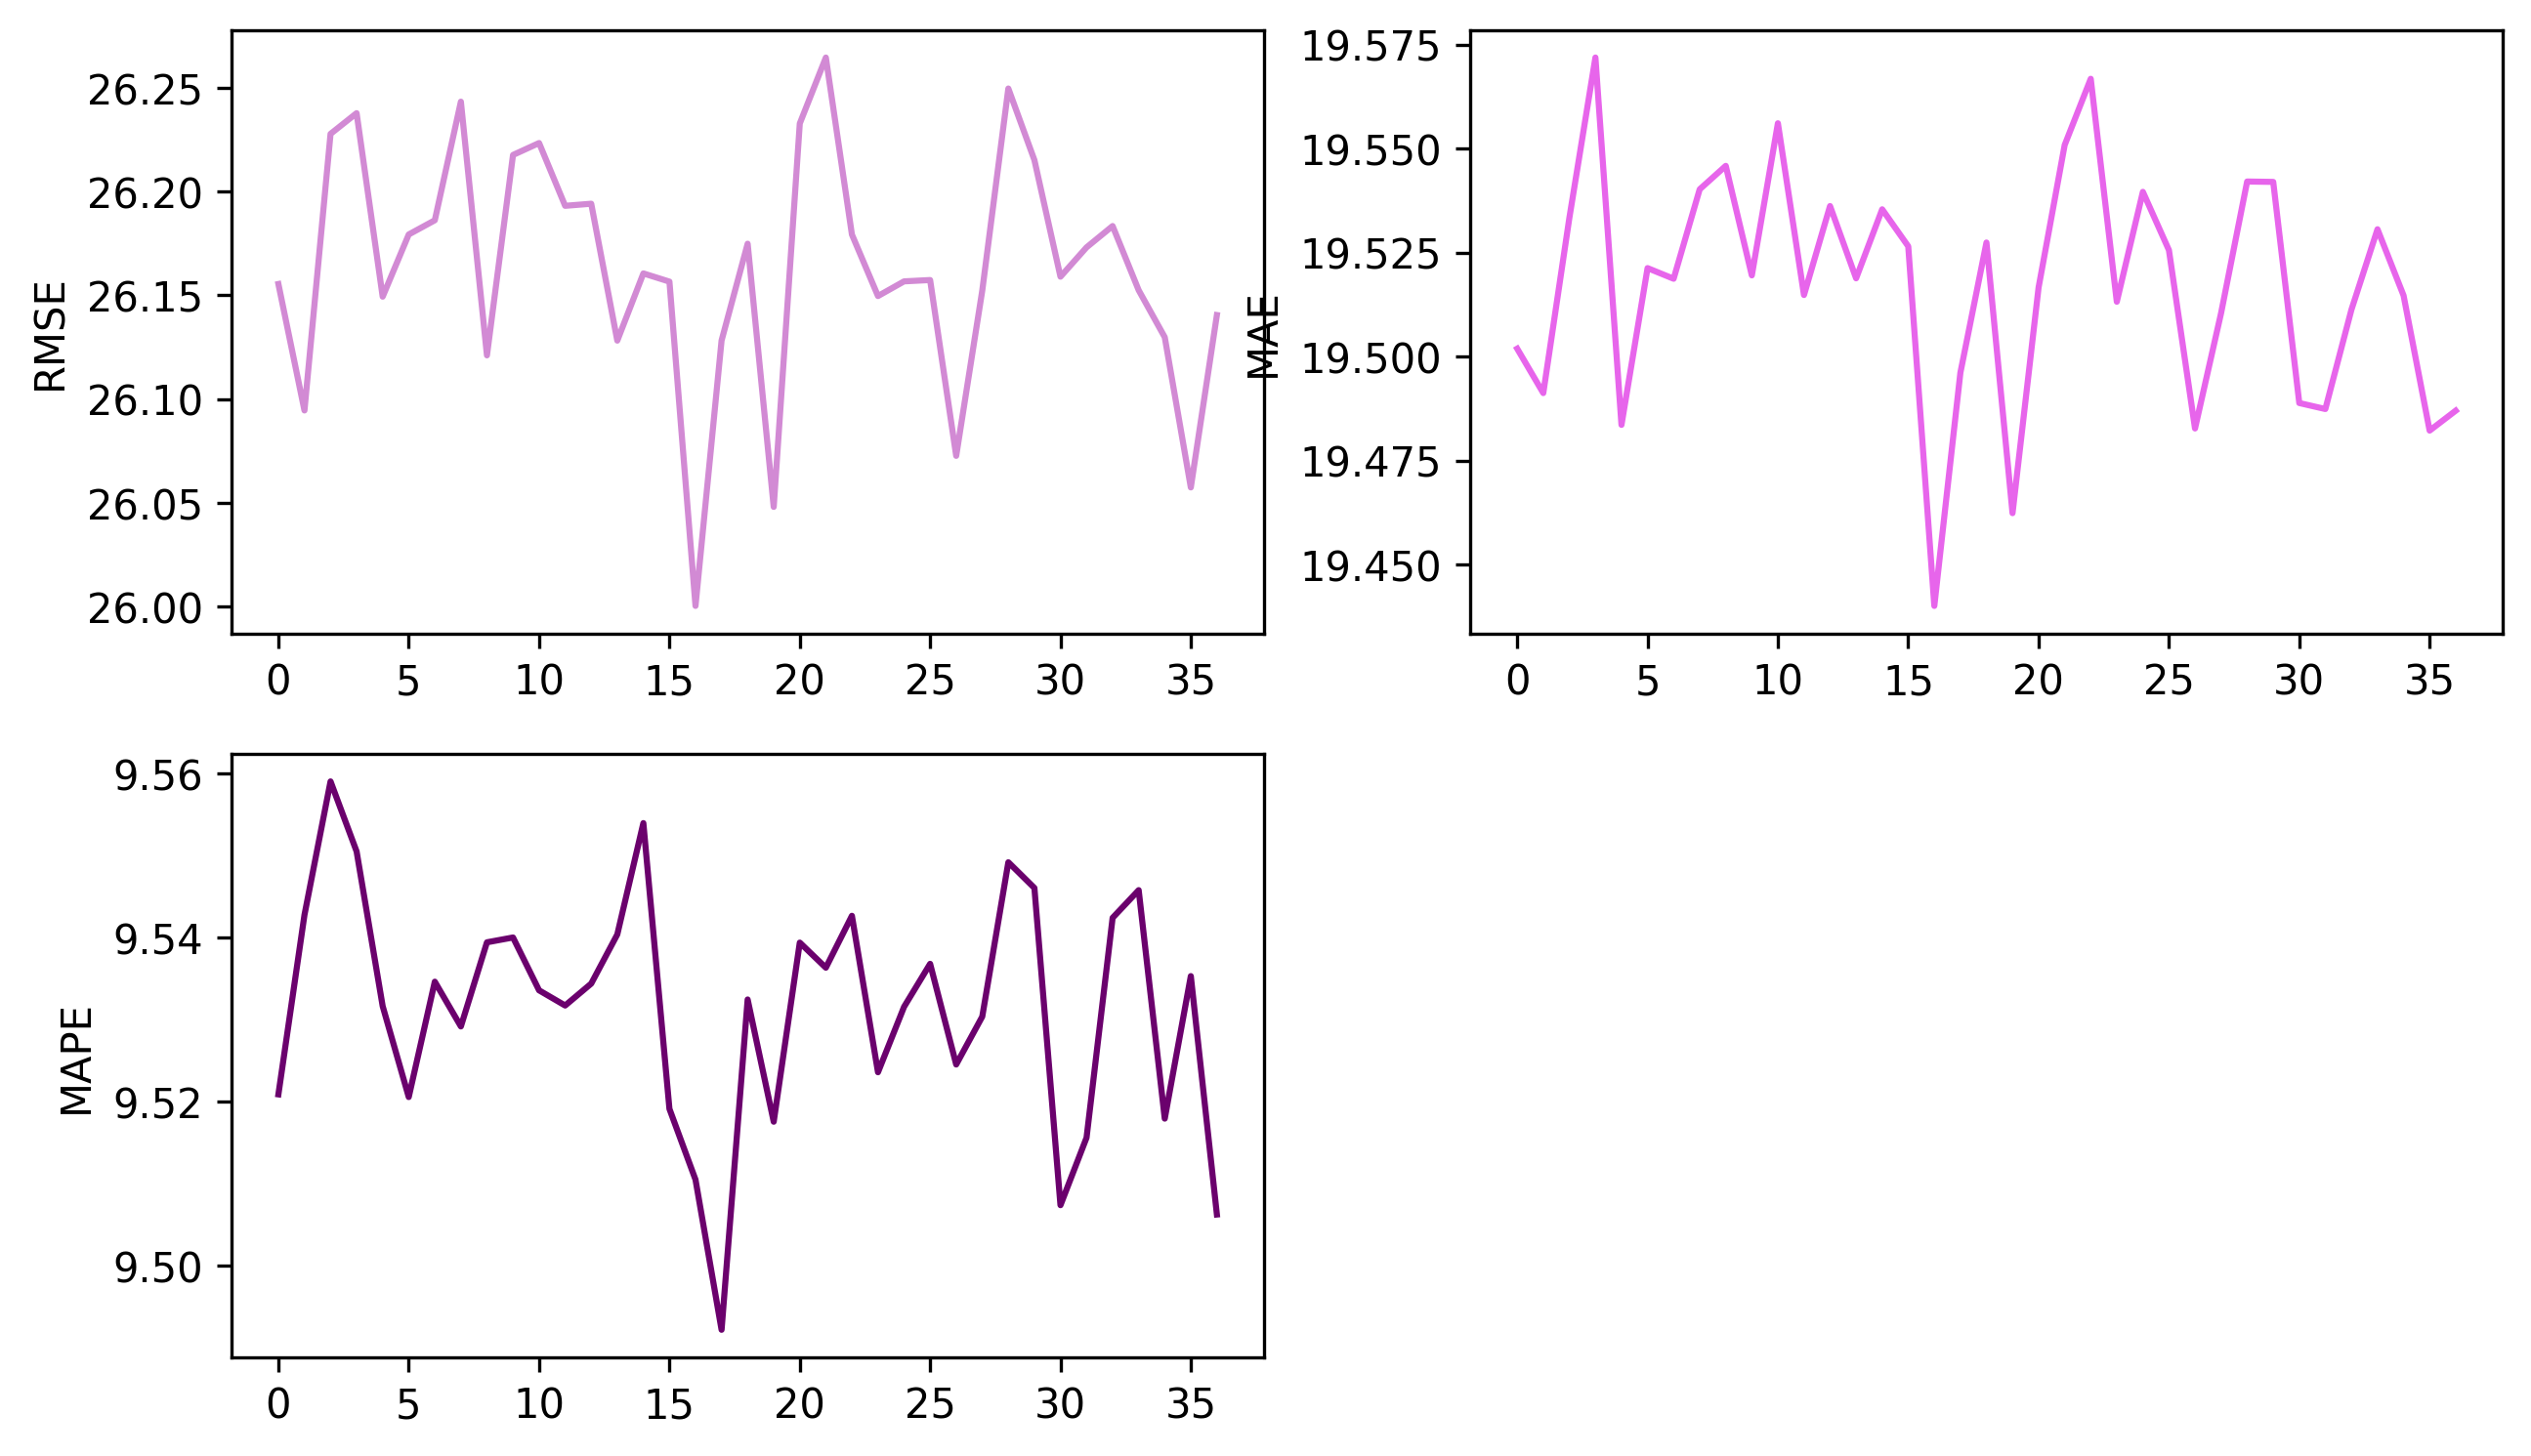

In [22]:
visualize(stop_epoch, train_loss_lst, val_loss_lst)
plot_metric(train_score_lst)
plot_metric(val_score_lst)

## 调用接口实现GRU

In [23]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
input_size = train_set.X.shape[-1]
hidden_size = 64
output_size = 1
seq_len = 12
lr = 0.0001
epochs = 80
loss_func = nn.MSELoss()

nn_gru = nn.GRU(input_size=input_size, hidden_size=hidden_size, num_layers=1, batch_first=True).to(device)
out_linear = nn.Sequential(nn.Linear(hidden_size, 1),
                           nn.LeakyReLU()).to(device)

optimizer = torch.optim.Adam(list(nn_gru.parameters()) + list(out_linear.parameters()), lr)

train_loss_lst, val_loss_lst, \
    train_score_lst, val_score_lst, stop_epoch = train(nn_gru, train_loader, val_loader, test_loader,
                                                       loss_func, traffic_dataset.denormalize, optimizer, epochs,
                                                       early_stop=20, device=device, output_model=out_linear)

*** epoch1, train loss 0.0187, train rmse 148.1419, val loss 0.0085, val rmse 105.505267, time use 0.933s
*** epoch2, train loss 0.0070, train rmse 95.5770, val loss 0.0057, val rmse 86.524722, time use 0.852s
*** epoch3, train loss 0.0034, train rmse 65.8217, val loss 0.0014, val rmse 42.713888, time use 0.886s
*** epoch4, train loss 0.0009, train rmse 33.2581, val loss 0.0009, val rmse 33.412209, time use 0.856s
*** epoch5, train loss 0.0008, train rmse 31.3655, val loss 0.0008, val rmse 32.907776, time use 0.947s
*** epoch6, train loss 0.0007, train rmse 30.9563, val loss 0.0008, val rmse 32.387166, time use 1.007s
*** epoch7, train loss 0.0007, train rmse 30.5546, val loss 0.0008, val rmse 31.895252, time use 0.959s
*** epoch8, train loss 0.0007, train rmse 30.2035, val loss 0.0008, val rmse 31.302145, time use 0.977s
*** epoch9, train loss 0.0007, train rmse 29.8227, val loss 0.0007, val rmse 30.986073, time use 1.022s
*** epoch10, train loss 0.0007, train rmse 29.3380, val loss 0

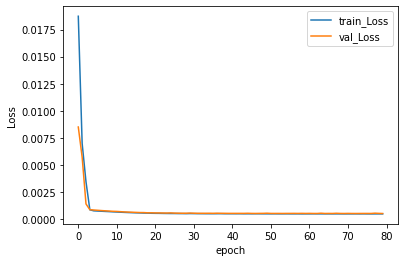

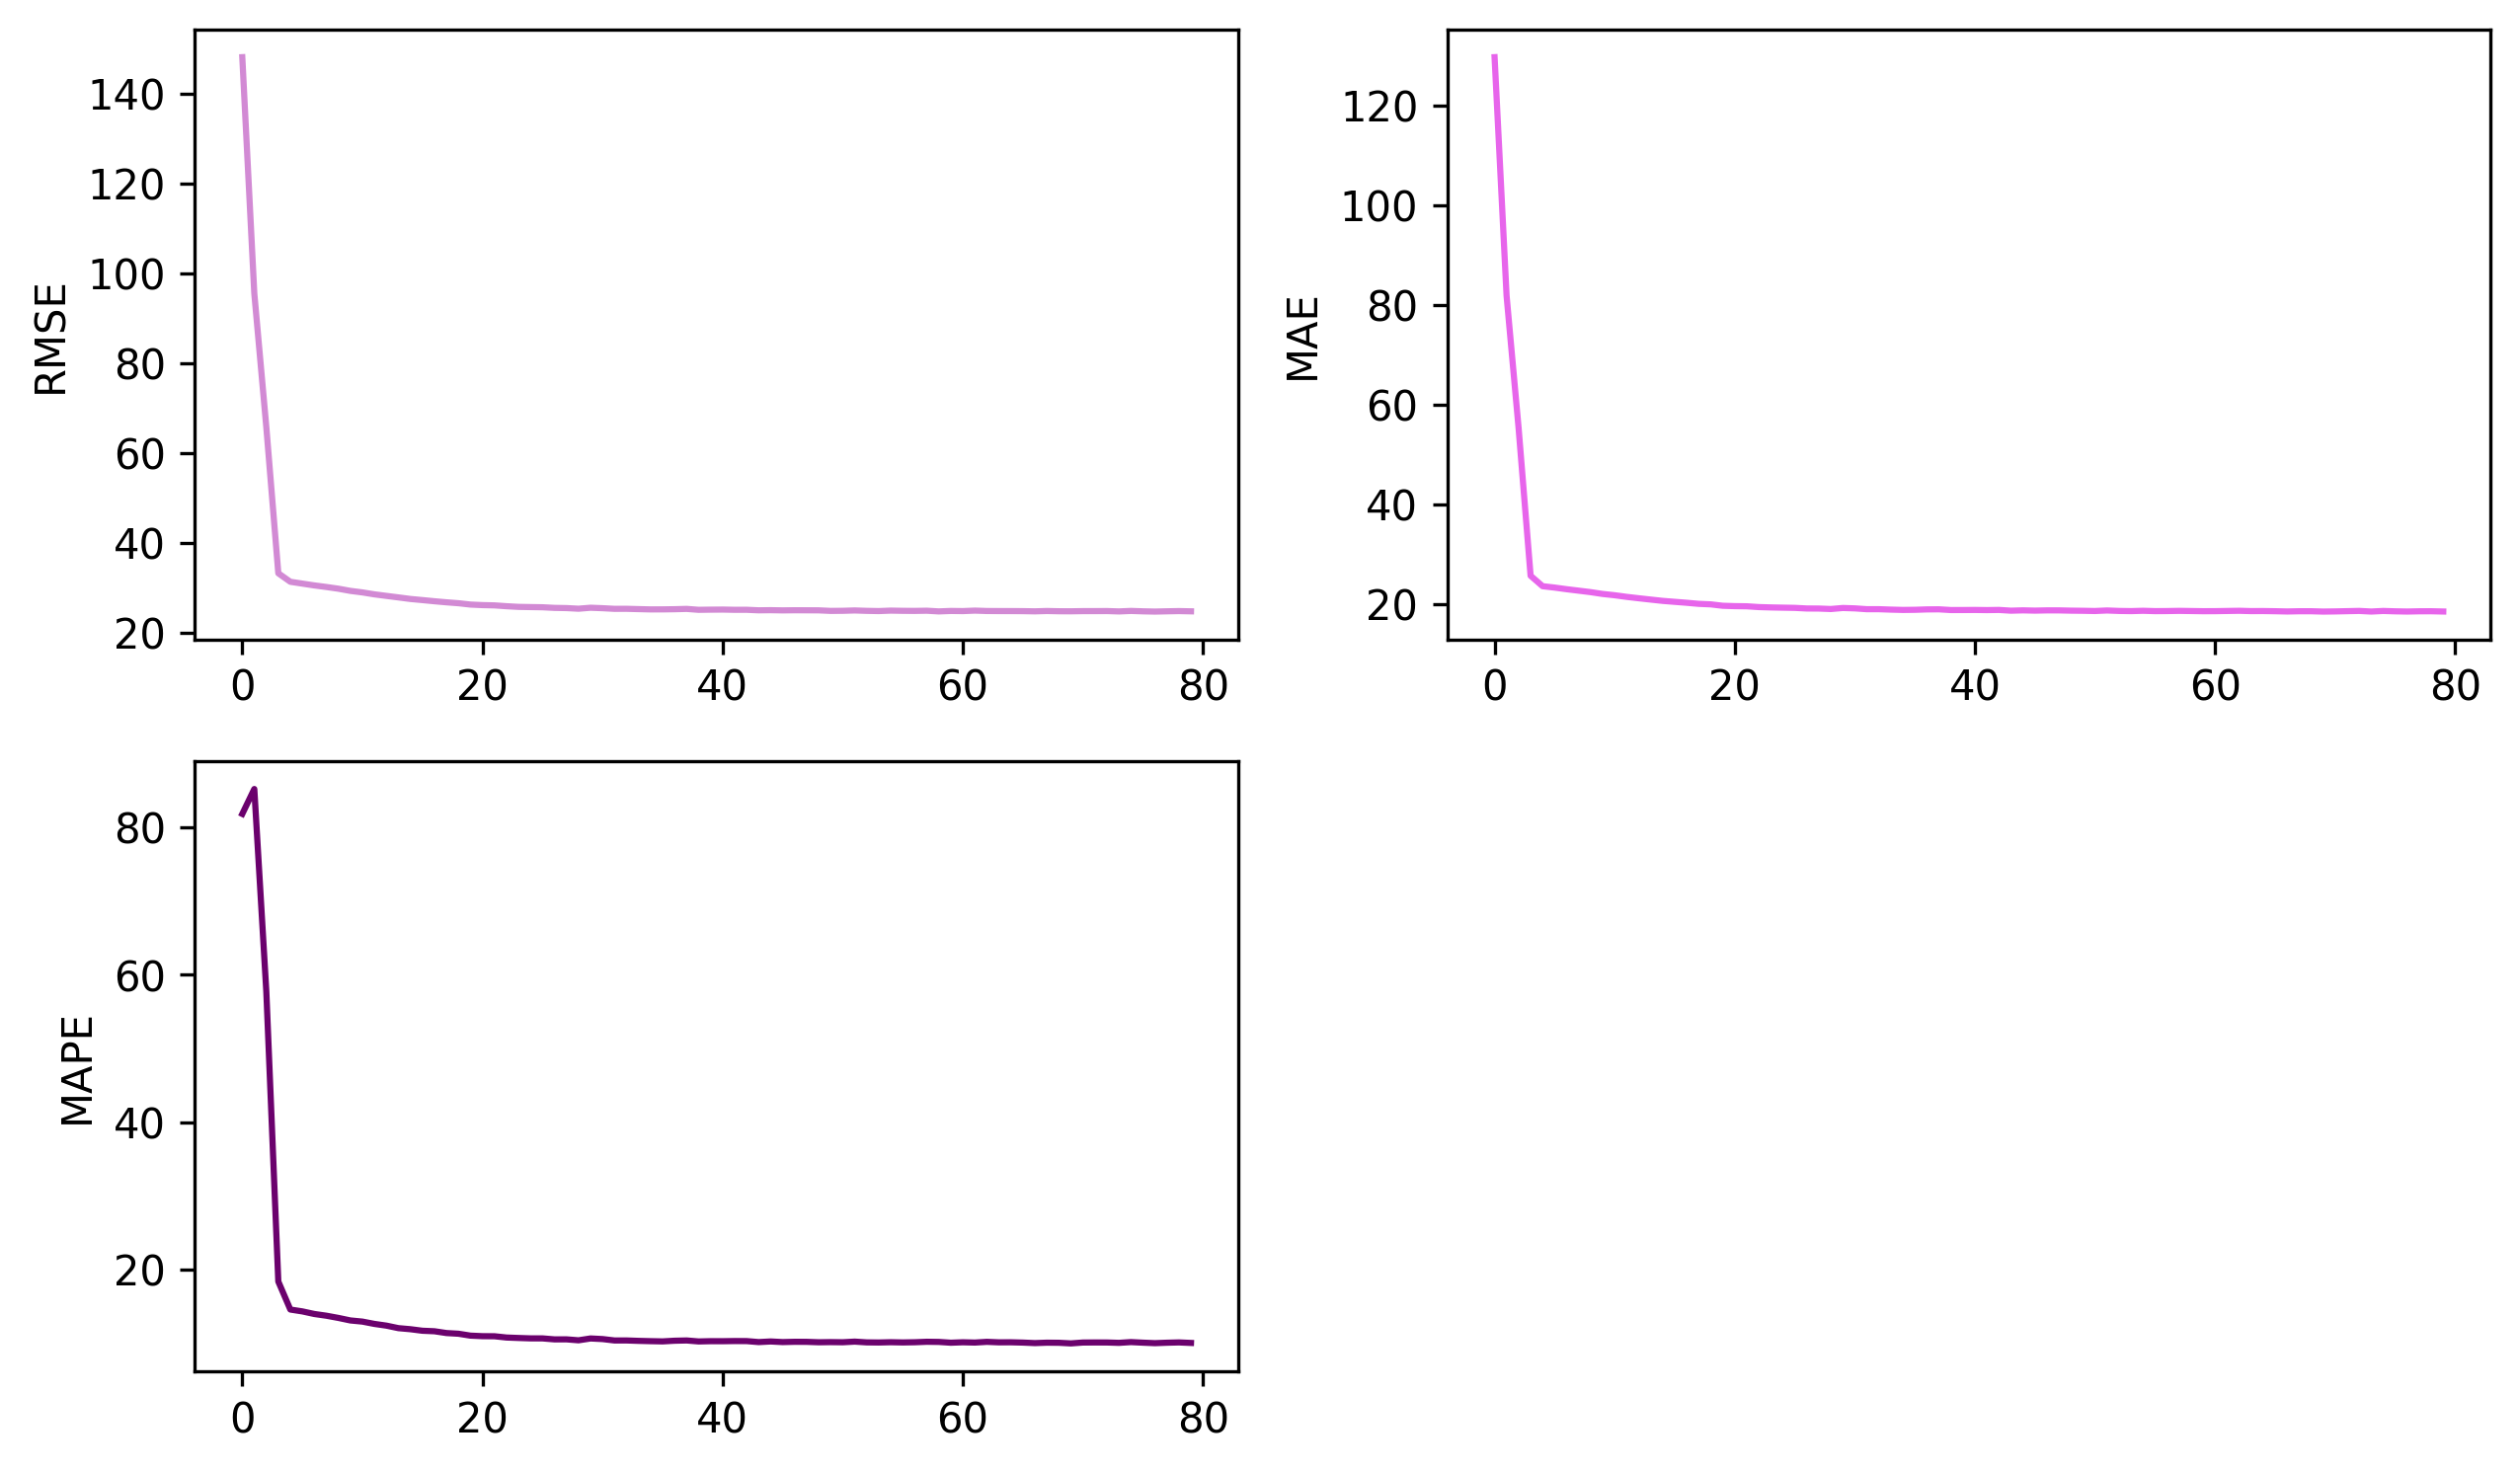

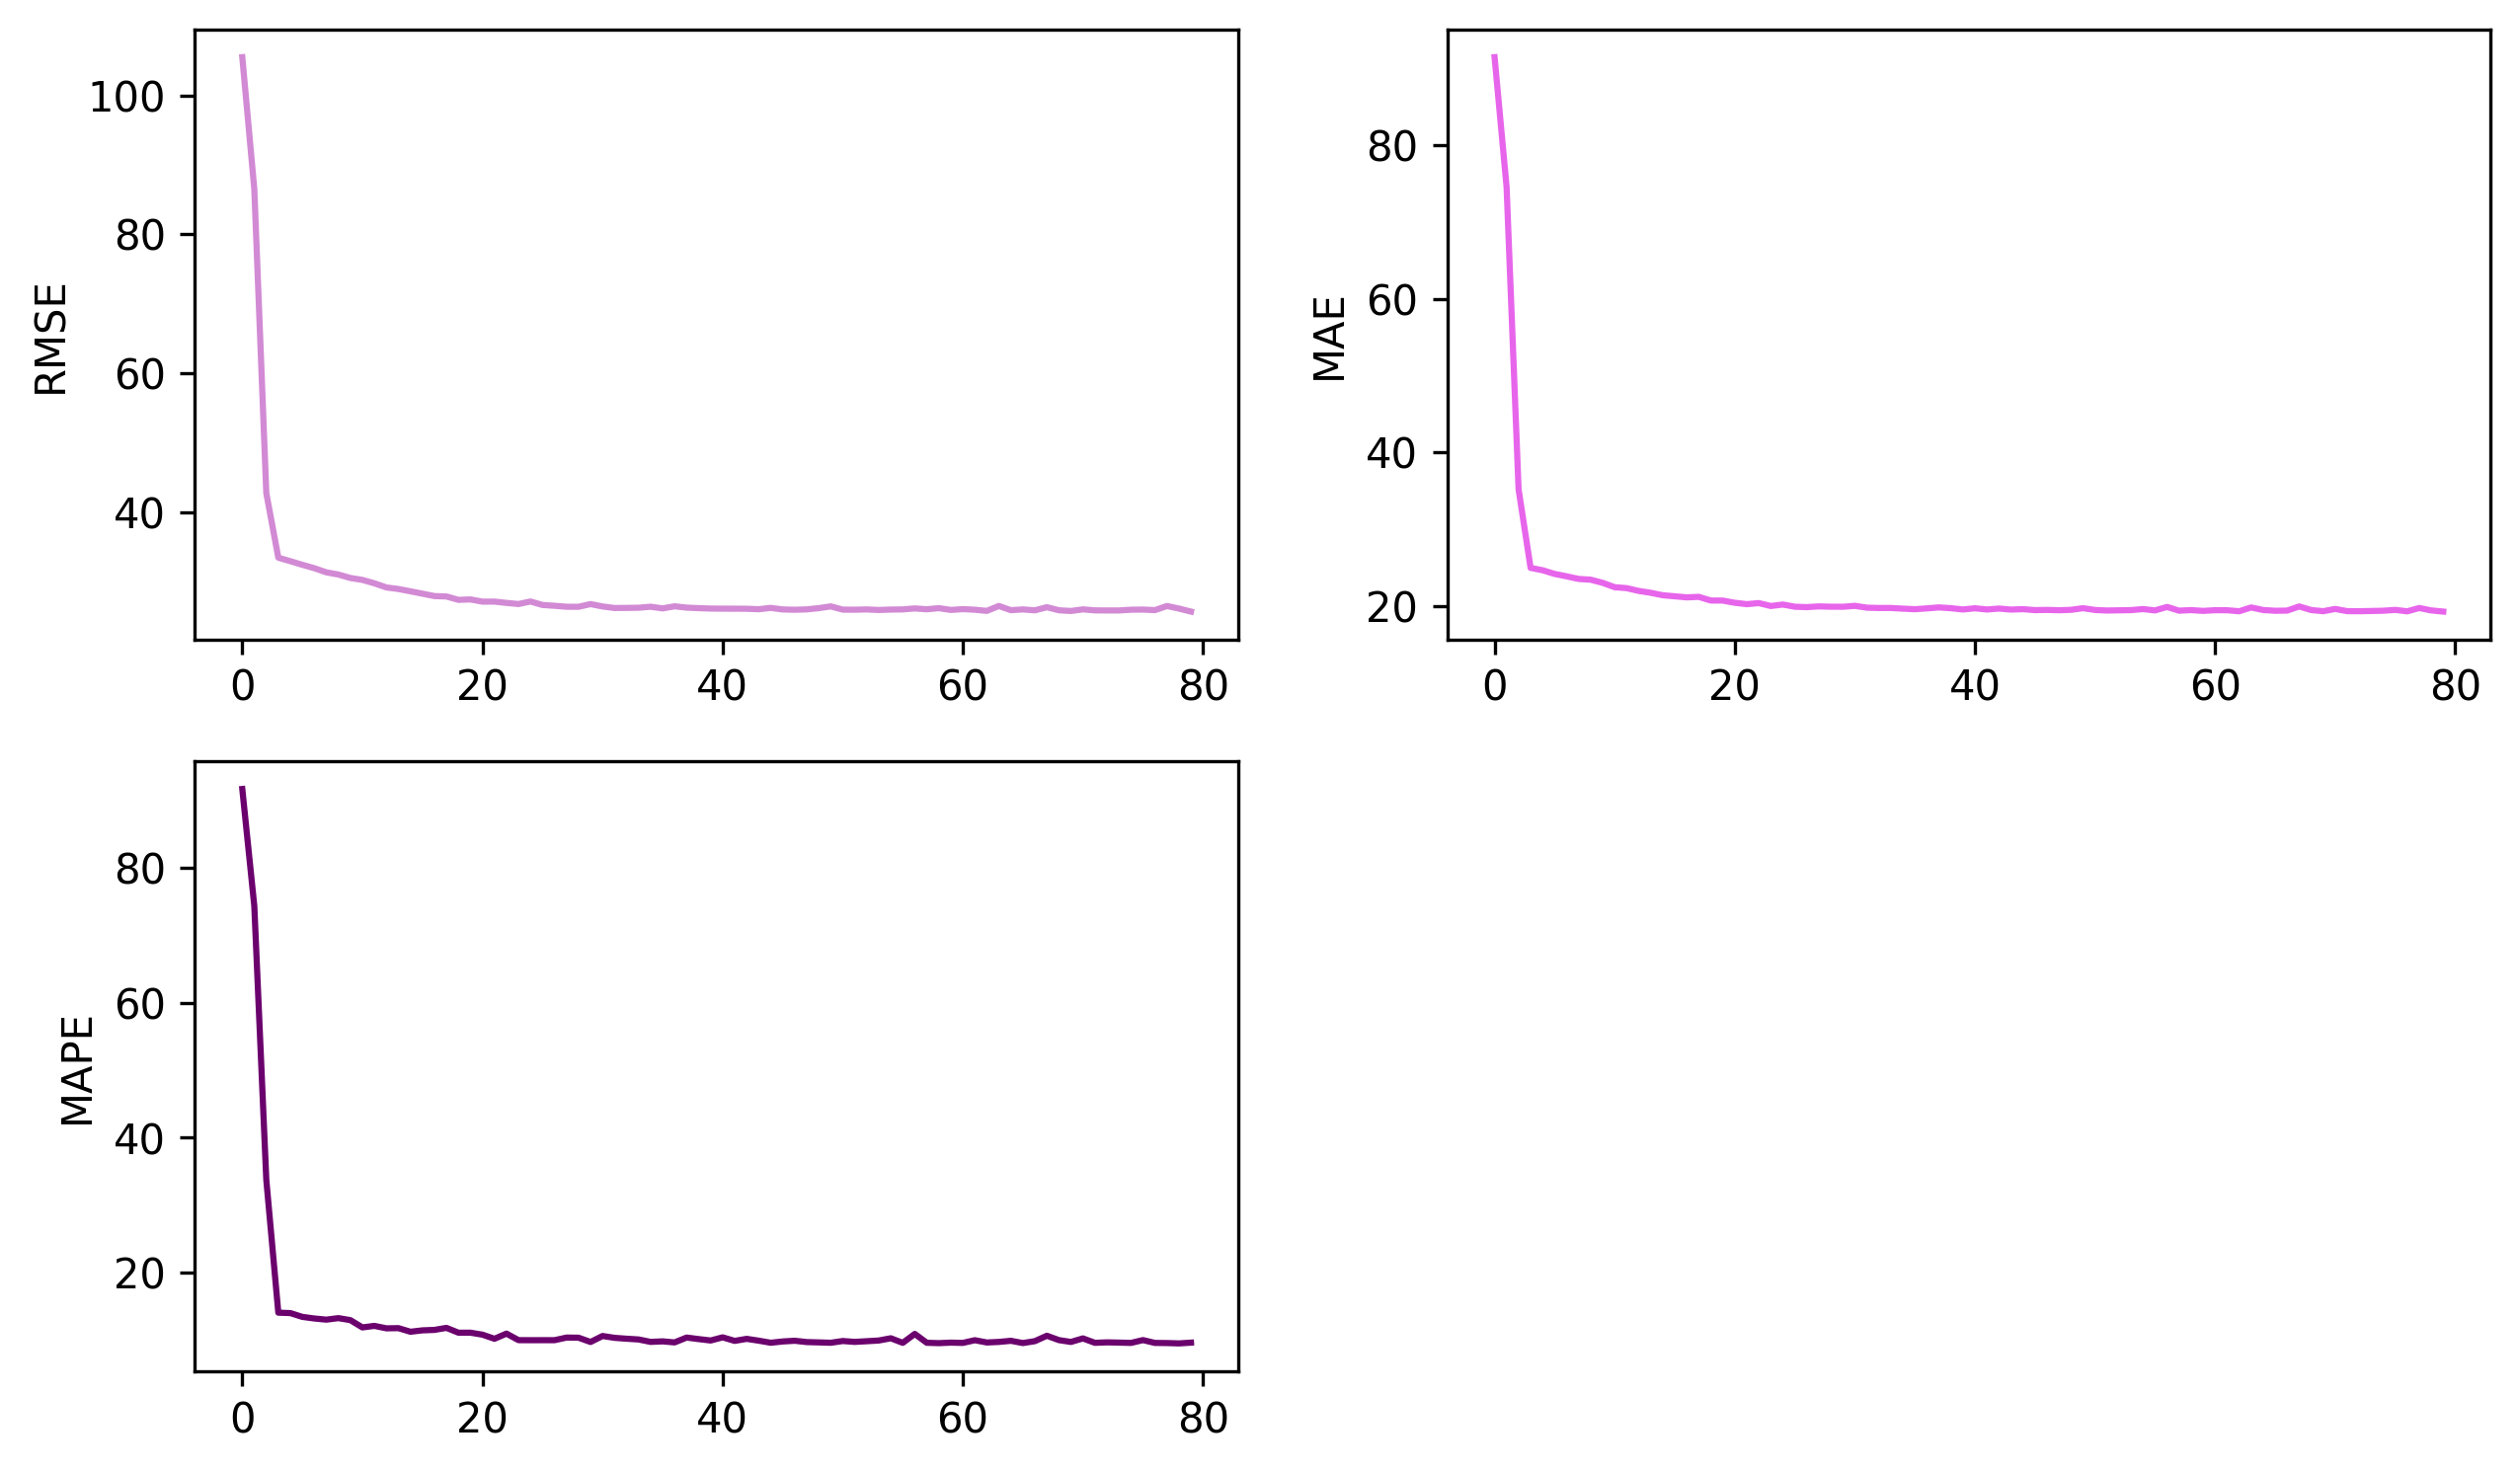

In [24]:
visualize(stop_epoch, train_loss_lst, val_loss_lst, y_label='Loss')
plot_metric(train_score_lst)
plot_metric(val_score_lst)

## 对比

### 时间对比
 |	|手动|调用
 ---|---|---
 RNN|57.39|68.54
 LSTM|284.85|76.37
 GRU|168.80|63.66

可以看出基本上都是使用torch.nn的训练时间要小于手动实现的网络，原因可能是torch的代码精简度以及并行程度更高。

### 误差对比(使用调用的网络)
|   |RMSE|MAE|MAPE
|---|---|---|---|
|RNN|25.91|19.32|9.57|
|LSTM|25.30|18.99|9.67|
|GRU|25.00|18.83|9.76|


三种网络对于这一个数据集在相同的参数下训练出来的误差值相差不大，说明这三种网络在这个问题上性能差异不大，都是普遍适用型的。

此外，手动搭建的网络在误差随周期的波动远大于torch.nn的，手动实现的网络的RMSE,MAE等一直在上下波动，而torch.nn的几乎是平稳下降。原因可能是torch实现的网络内部结构有一些优化，在梯度下降时造成路径摆动导致LOSS值波动。

## 参数对比

### RNN

In [25]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
input_size = train_set.X.shape[-1]
hidden_size = 64
output_size = 1
seq_len = 12
lr = 0.01 #0.0001
epochs = 80
loss_func = nn.MSELoss()

nn_rnn = nn.RNN(input_size=input_size, hidden_size=hidden_size, num_layers=1, batch_first=True).to(device)
out_linear = nn.Sequential(nn.Linear(hidden_size, 1),
                           nn.LeakyReLU()).to(device)

optimizer = torch.optim.Adam(list(nn_rnn.parameters()) + list(out_linear.parameters()), lr)

train_loss_lst, val_loss_lst, \
    train_score_lst, val_score_lst, stop_epoch = train(nn_rnn, train_loader, val_loader, test_loader,
                                                       loss_func, traffic_dataset.denormalize, optimizer, epochs,
                                                       early_stop=20, device=device, output_model=out_linear)

*** epoch1, train loss 0.0041, train rmse 51.1225, val loss 0.0005, val rmse 26.410297, time use 0.951s
*** epoch2, train loss 0.0005, train rmse 25.6798, val loss 0.0005, val rmse 26.238331, time use 0.943s
*** epoch3, train loss 0.0005, train rmse 26.0640, val loss 0.0005, val rmse 26.027241, time use 0.984s
*** epoch4, train loss 0.0005, train rmse 26.2985, val loss 0.0008, val rmse 31.599116, time use 0.964s
*** epoch5, train loss 0.0005, train rmse 26.2219, val loss 0.0005, val rmse 26.008893, time use 0.987s
*** epoch6, train loss 0.0005, train rmse 25.6782, val loss 0.0006, val rmse 26.772366, time use 0.999s
*** epoch7, train loss 0.0005, train rmse 25.5717, val loss 0.0005, val rmse 26.003866, time use 0.982s
*** epoch8, train loss 0.0005, train rmse 25.7321, val loss 0.0005, val rmse 25.858654, time use 1.007s
*** epoch9, train loss 0.0005, train rmse 25.7349, val loss 0.0005, val rmse 26.407073, time use 0.943s
*** epoch10, train loss 0.0005, train rmse 25.8717, val loss 0.0

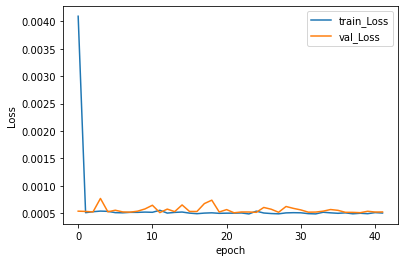

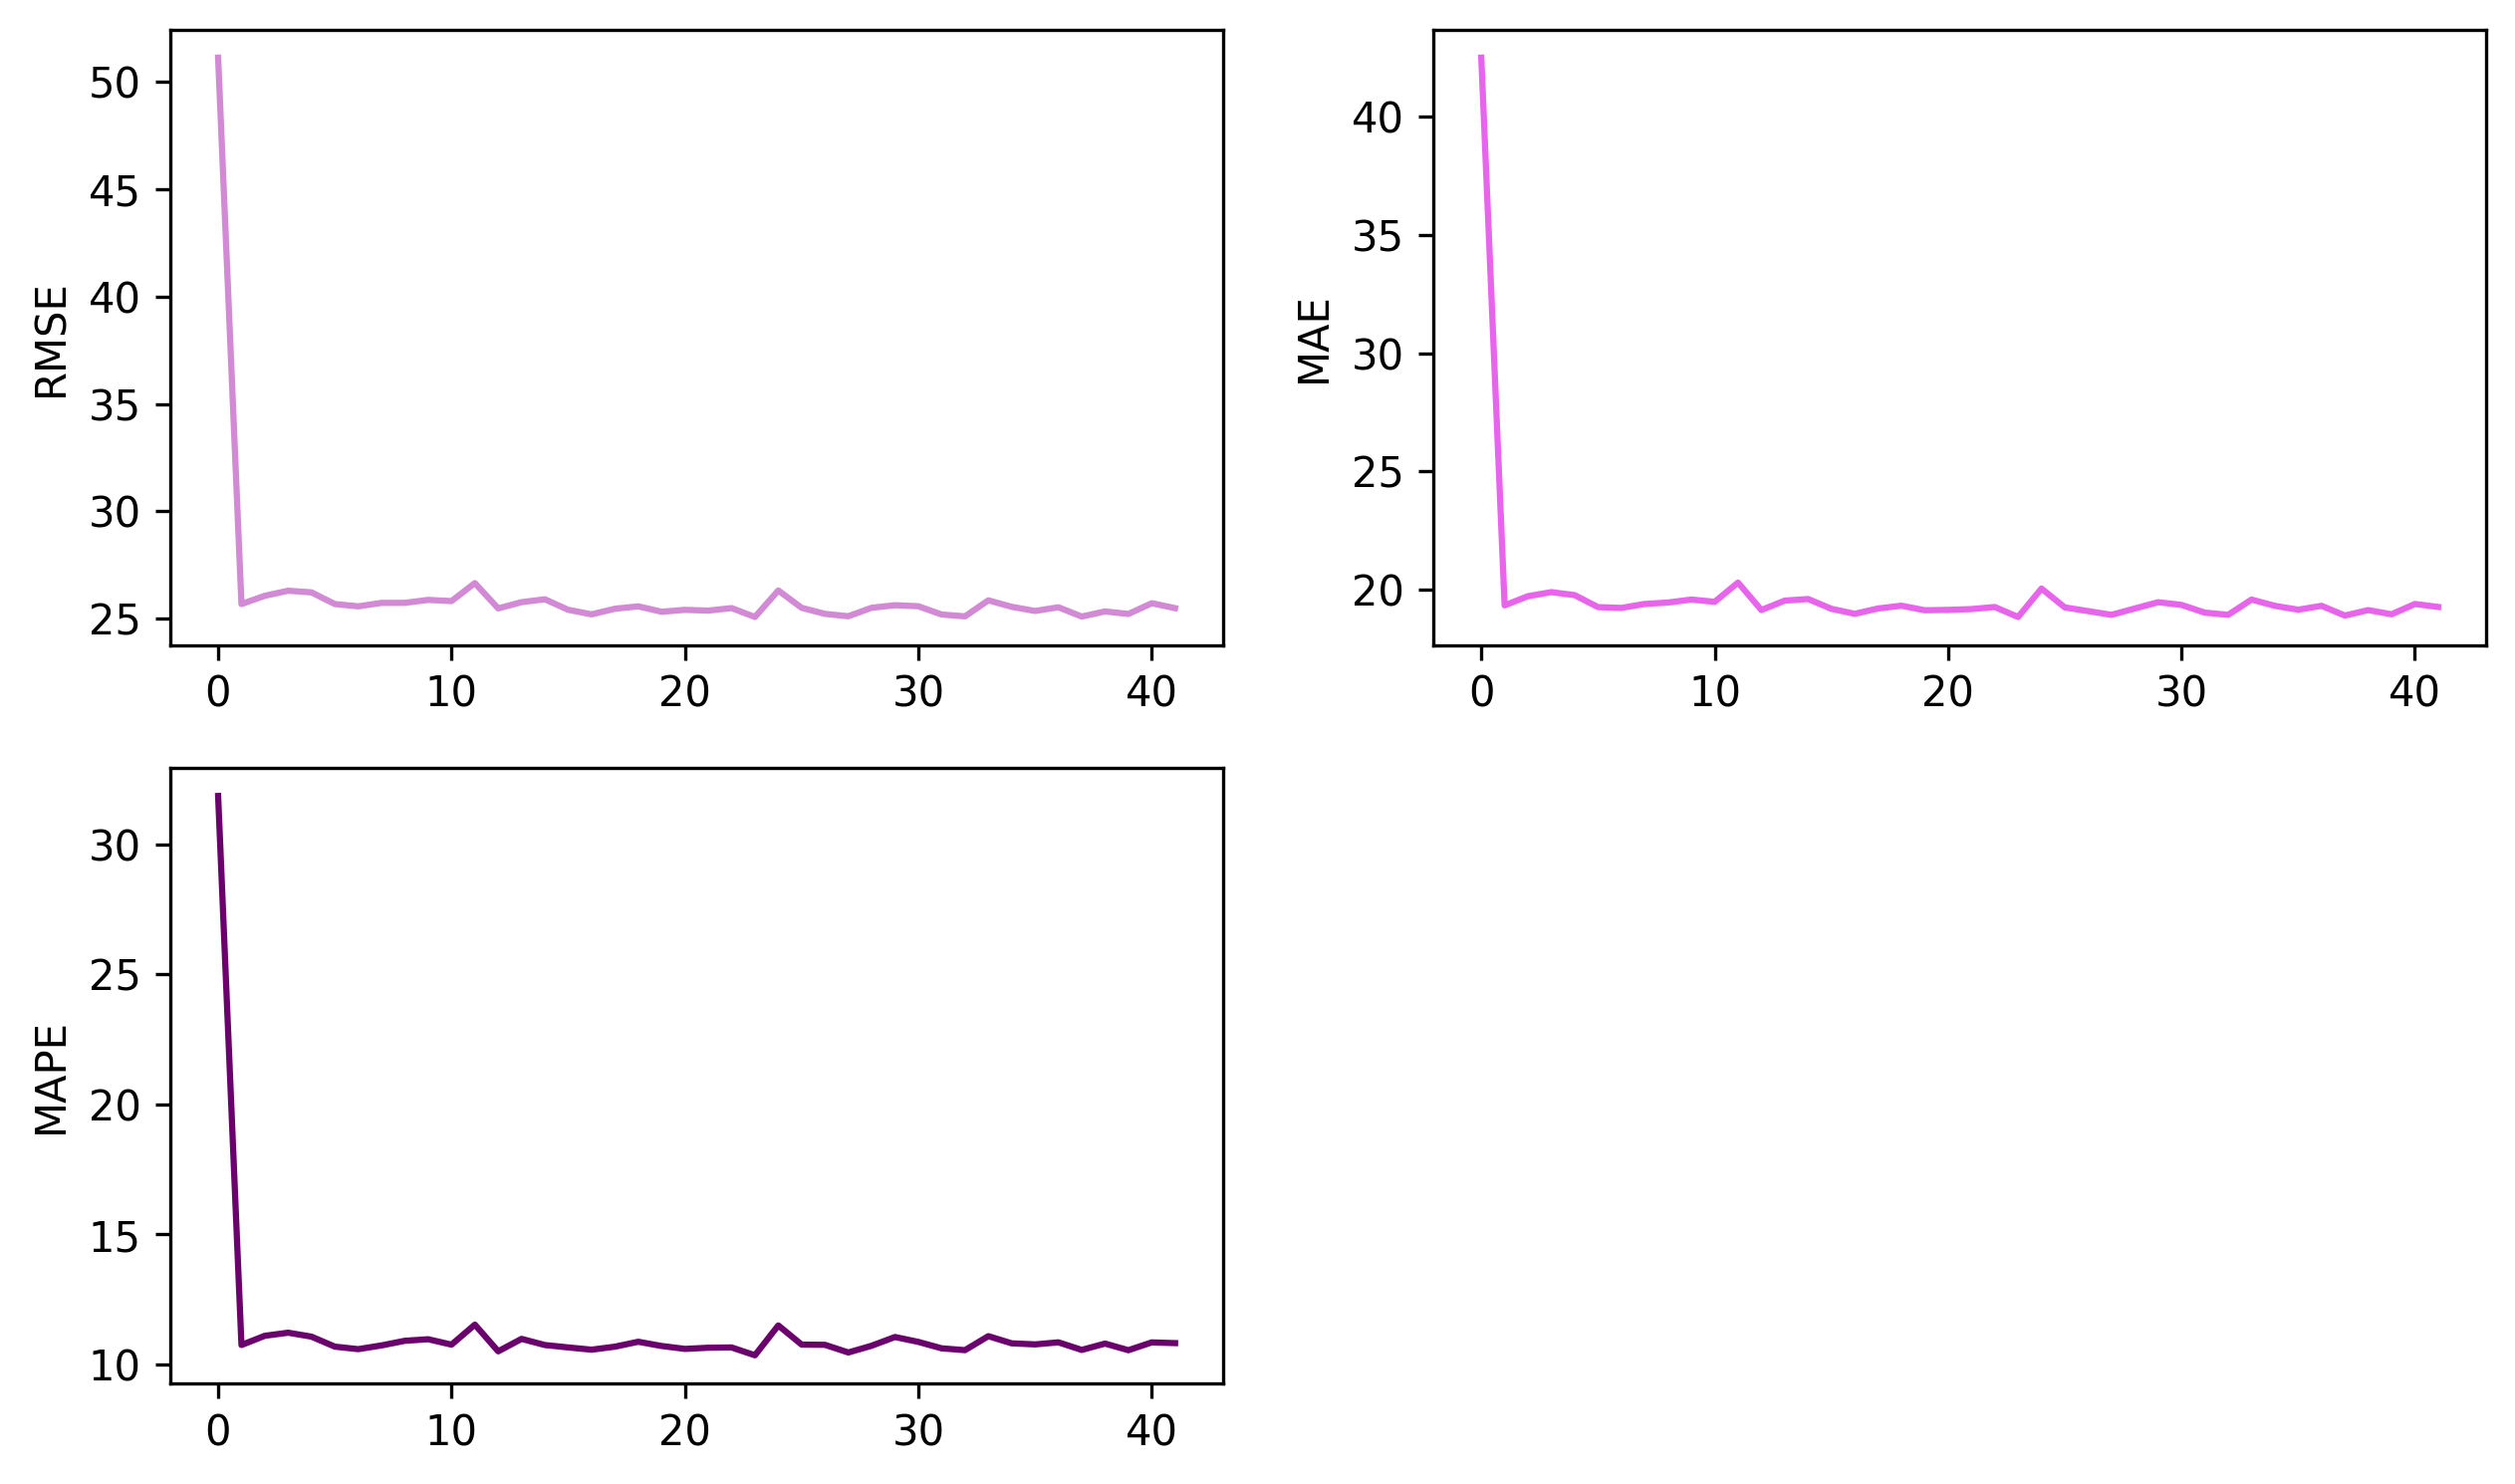

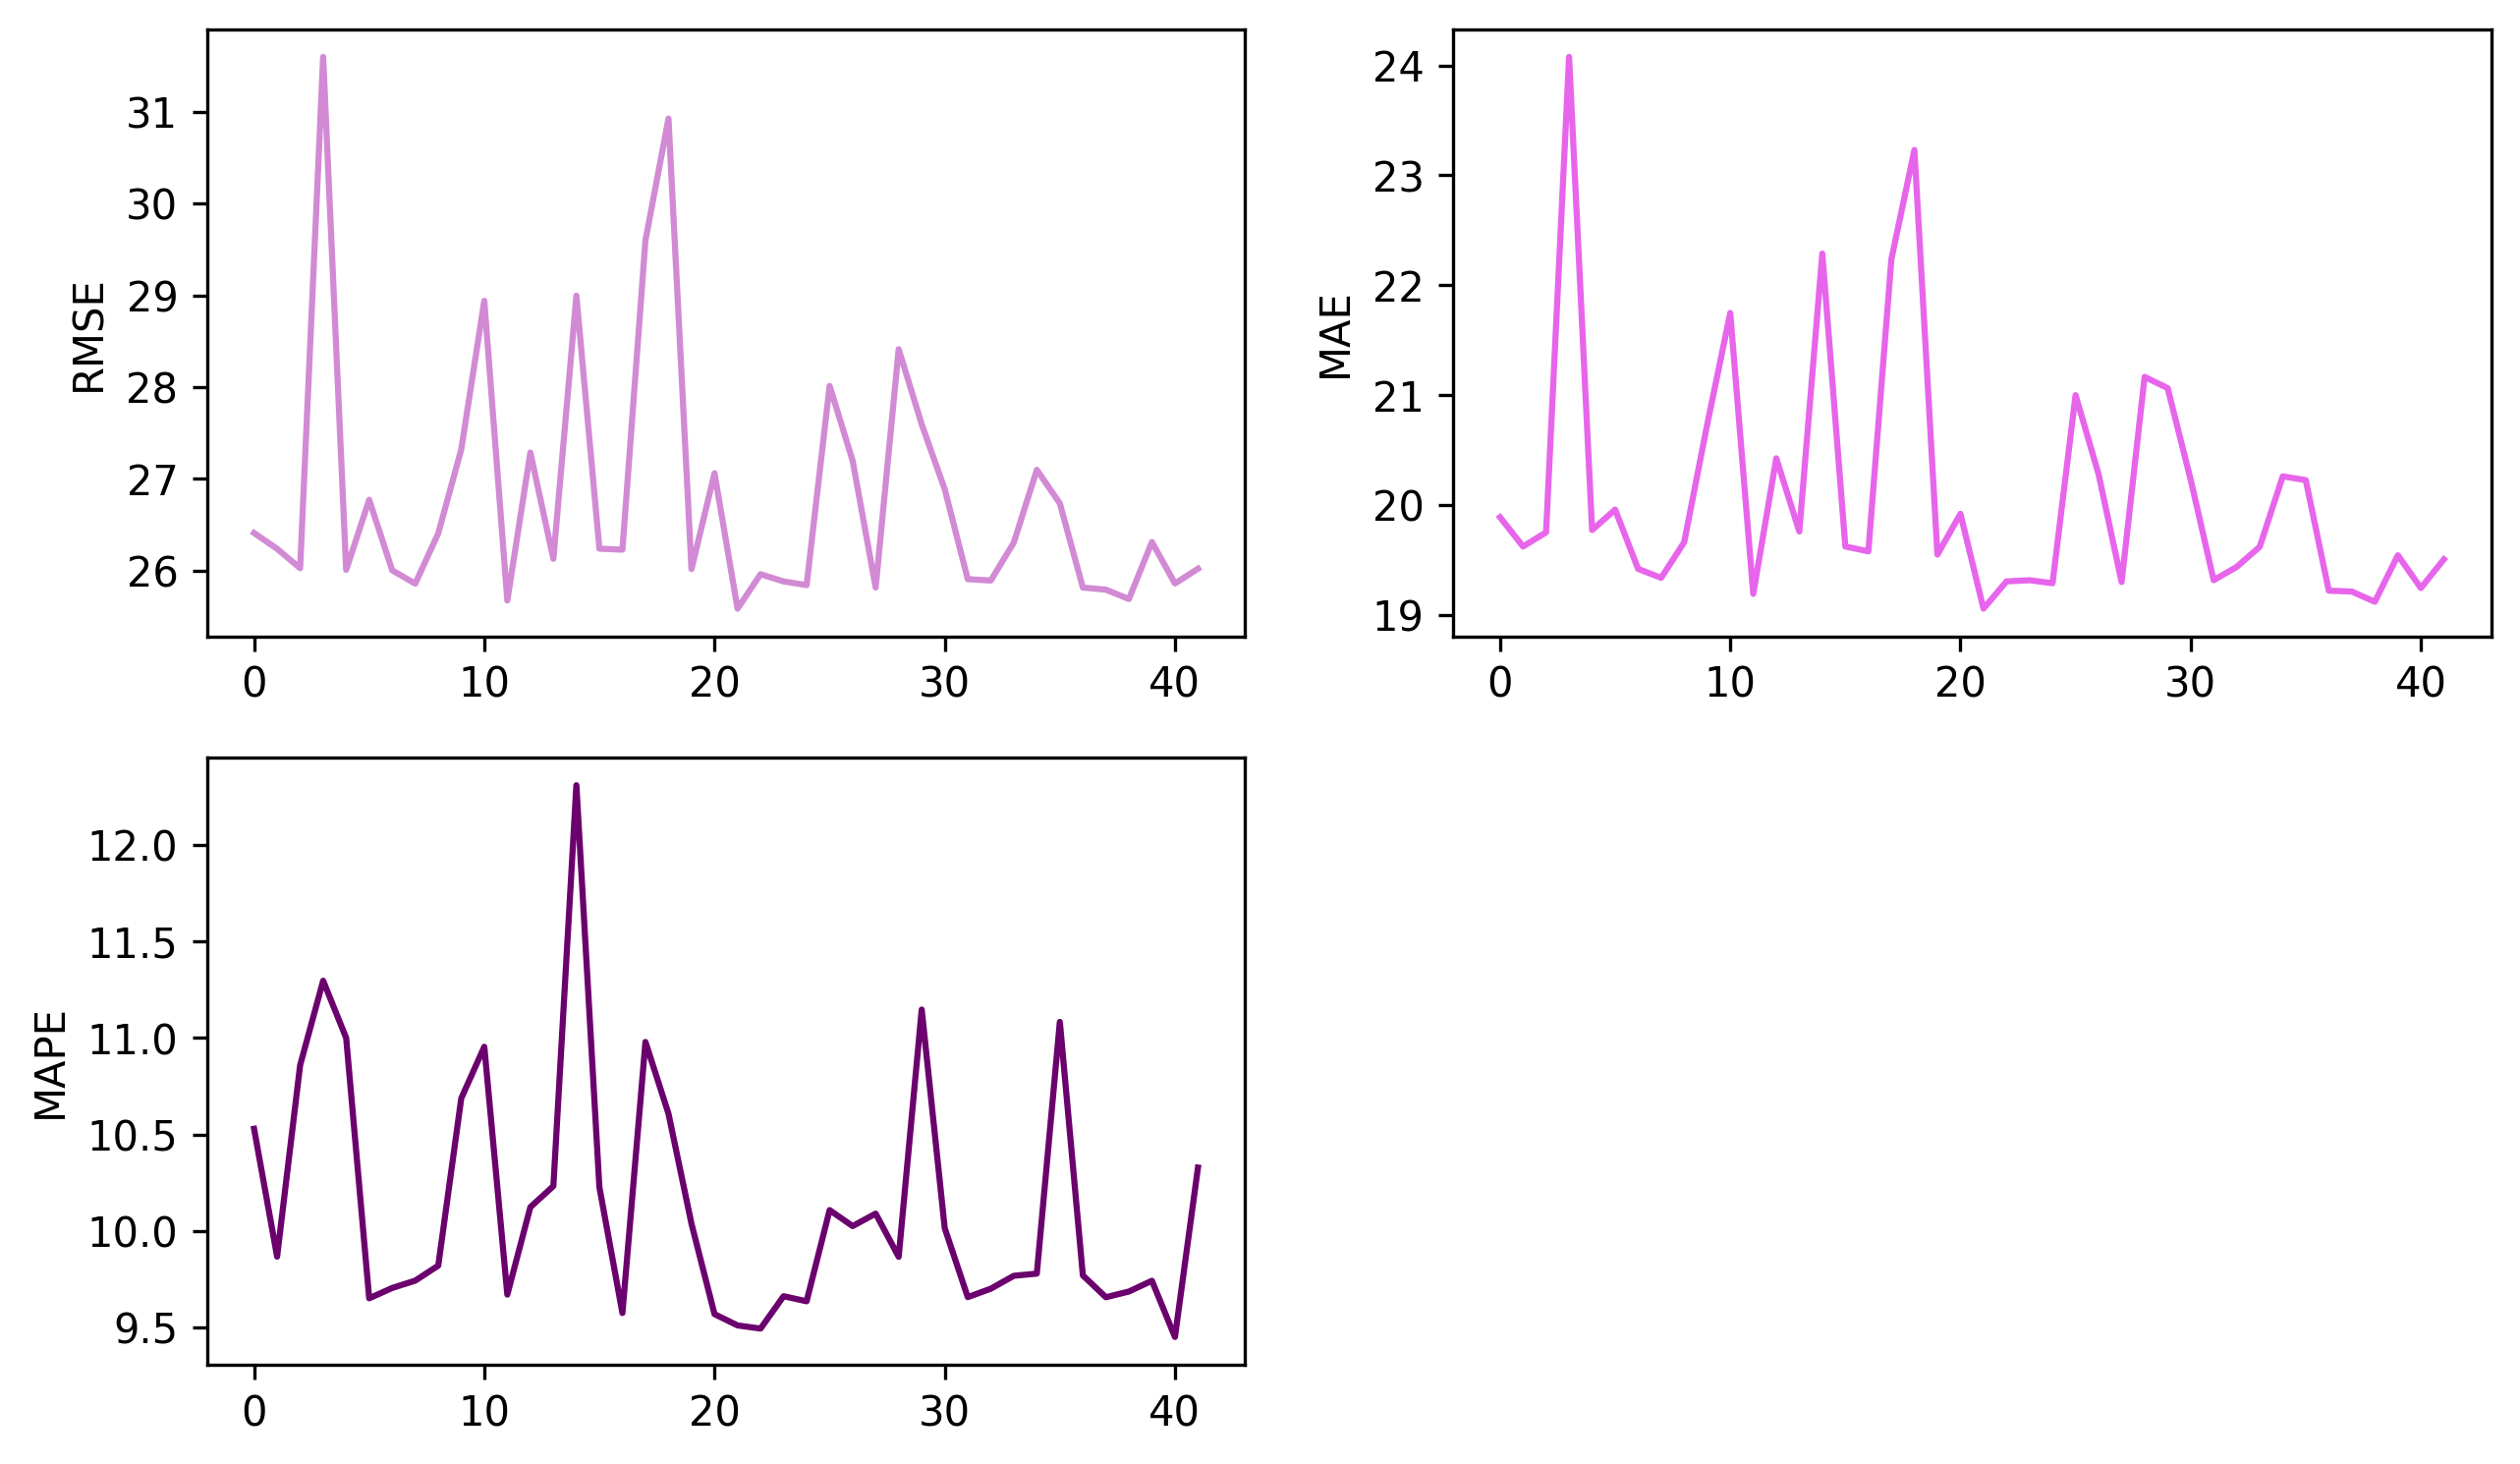

In [26]:
visualize(stop_epoch, train_loss_lst, val_loss_lst, y_label='Loss')
plot_metric(train_score_lst)
plot_metric(val_score_lst)

这次训练将lr从0.0001改为了0.01，从最后运行出来的图线来看，lr为0.0001在验证集上表现更好，几乎没有大幅波动，而本次将lr增大后验证集上的出现了大幅波动。

### LSTM

In [27]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
input_size = train_set.X.shape[-1]
hidden_size = 64
output_size = 1
seq_len = 12
lr = 0.01
epochs = 80
loss_func = nn.MSELoss()

nn_lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=1, batch_first=True).to(device)
out_linear = nn.Sequential(nn.Linear(hidden_size, 1),
                           nn.LeakyReLU()).to(device)

optimizer = torch.optim.Adam(list(nn_lstm.parameters()) + list(out_linear.parameters()), lr)

train_loss_lst, val_loss_lst, \
    train_score_lst, val_score_lst, stop_epoch = train(nn_lstm, train_loader, val_loader, test_loader,
                                                       loss_func, traffic_dataset.denormalize, optimizer, epochs,
                                                       early_stop=20, device=device, output_model=out_linear)

*** epoch1, train loss 0.0015, train rmse 37.7735, val loss 0.0005, val rmse 26.555330, time use 0.878s
*** epoch2, train loss 0.0005, train rmse 26.0002, val loss 0.0005, val rmse 26.350896, time use 0.771s
*** epoch3, train loss 0.0005, train rmse 26.1501, val loss 0.0006, val rmse 27.897506, time use 0.723s
*** epoch4, train loss 0.0005, train rmse 25.5968, val loss 0.0005, val rmse 25.730249, time use 0.749s
*** epoch5, train loss 0.0005, train rmse 25.4822, val loss 0.0005, val rmse 26.143028, time use 0.754s
*** epoch6, train loss 0.0005, train rmse 25.2945, val loss 0.0006, val rmse 27.780984, time use 0.771s
*** epoch7, train loss 0.0005, train rmse 25.0175, val loss 0.0005, val rmse 25.982023, time use 0.808s
*** epoch8, train loss 0.0005, train rmse 25.3916, val loss 0.0005, val rmse 26.281184, time use 0.792s
*** epoch9, train loss 0.0005, train rmse 25.9337, val loss 0.0005, val rmse 26.133355, time use 0.786s
*** epoch10, train loss 0.0005, train rmse 25.5234, val loss 0.0

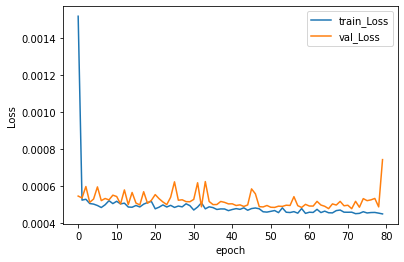

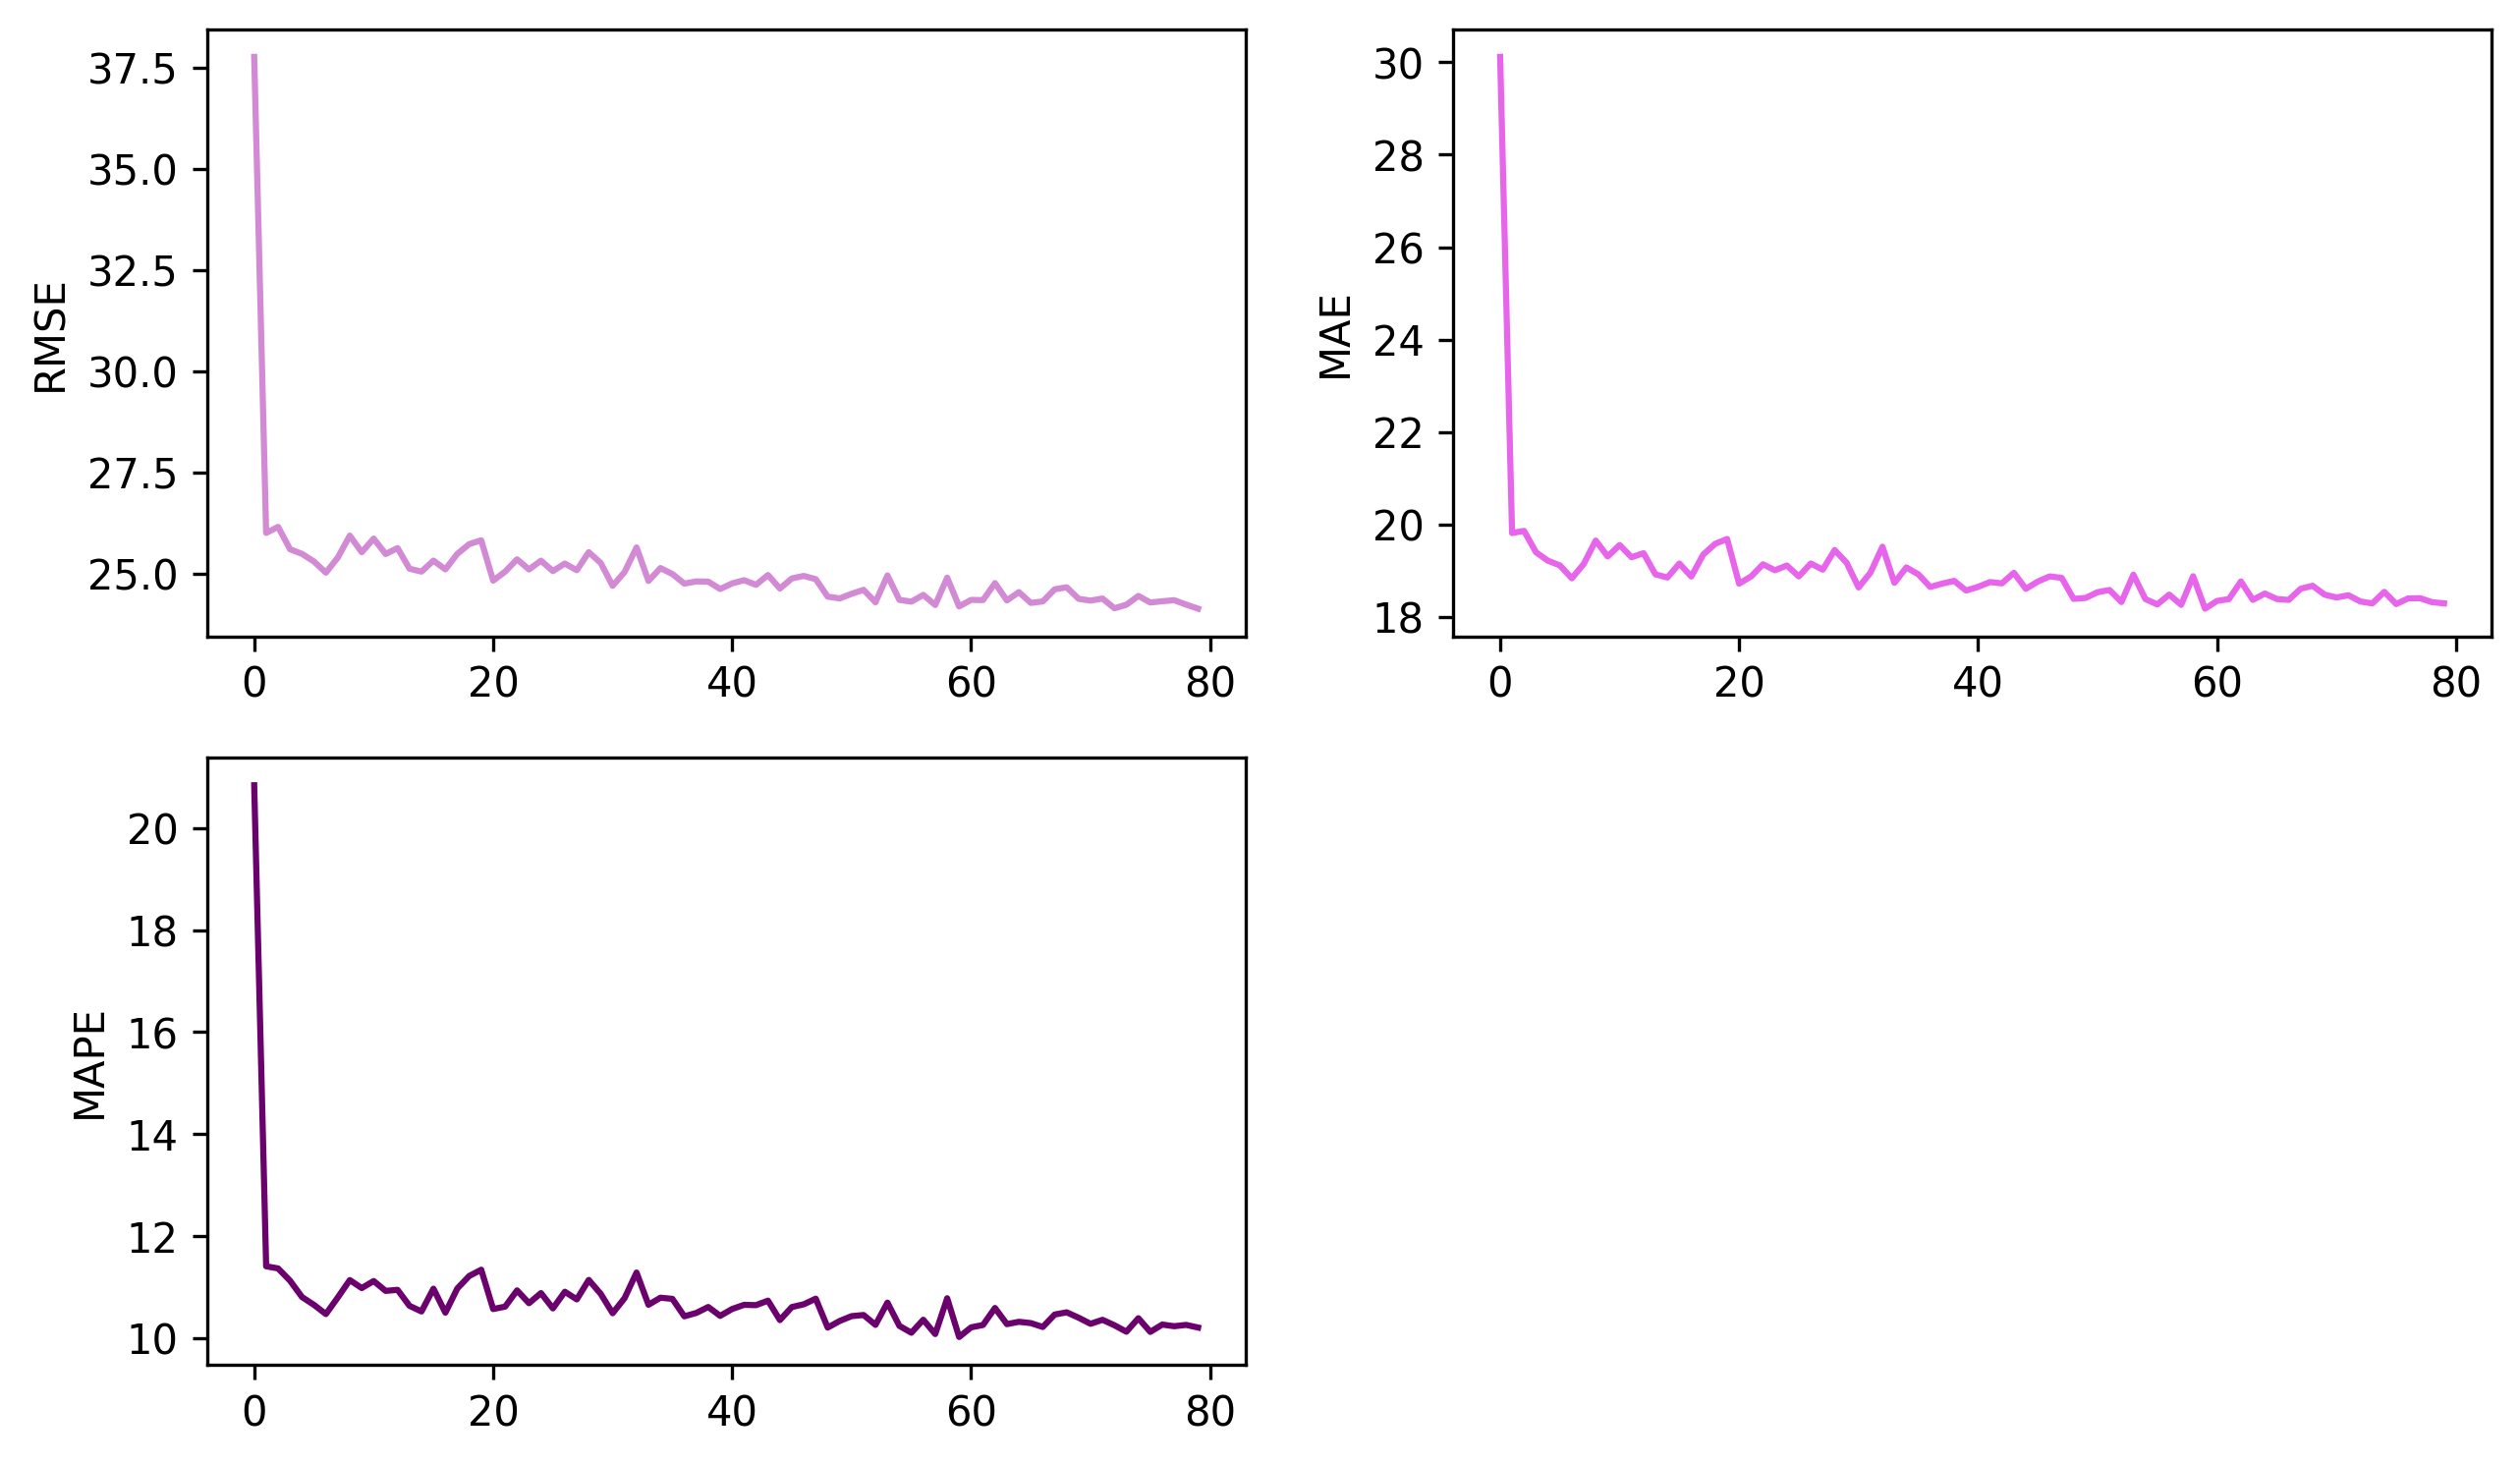

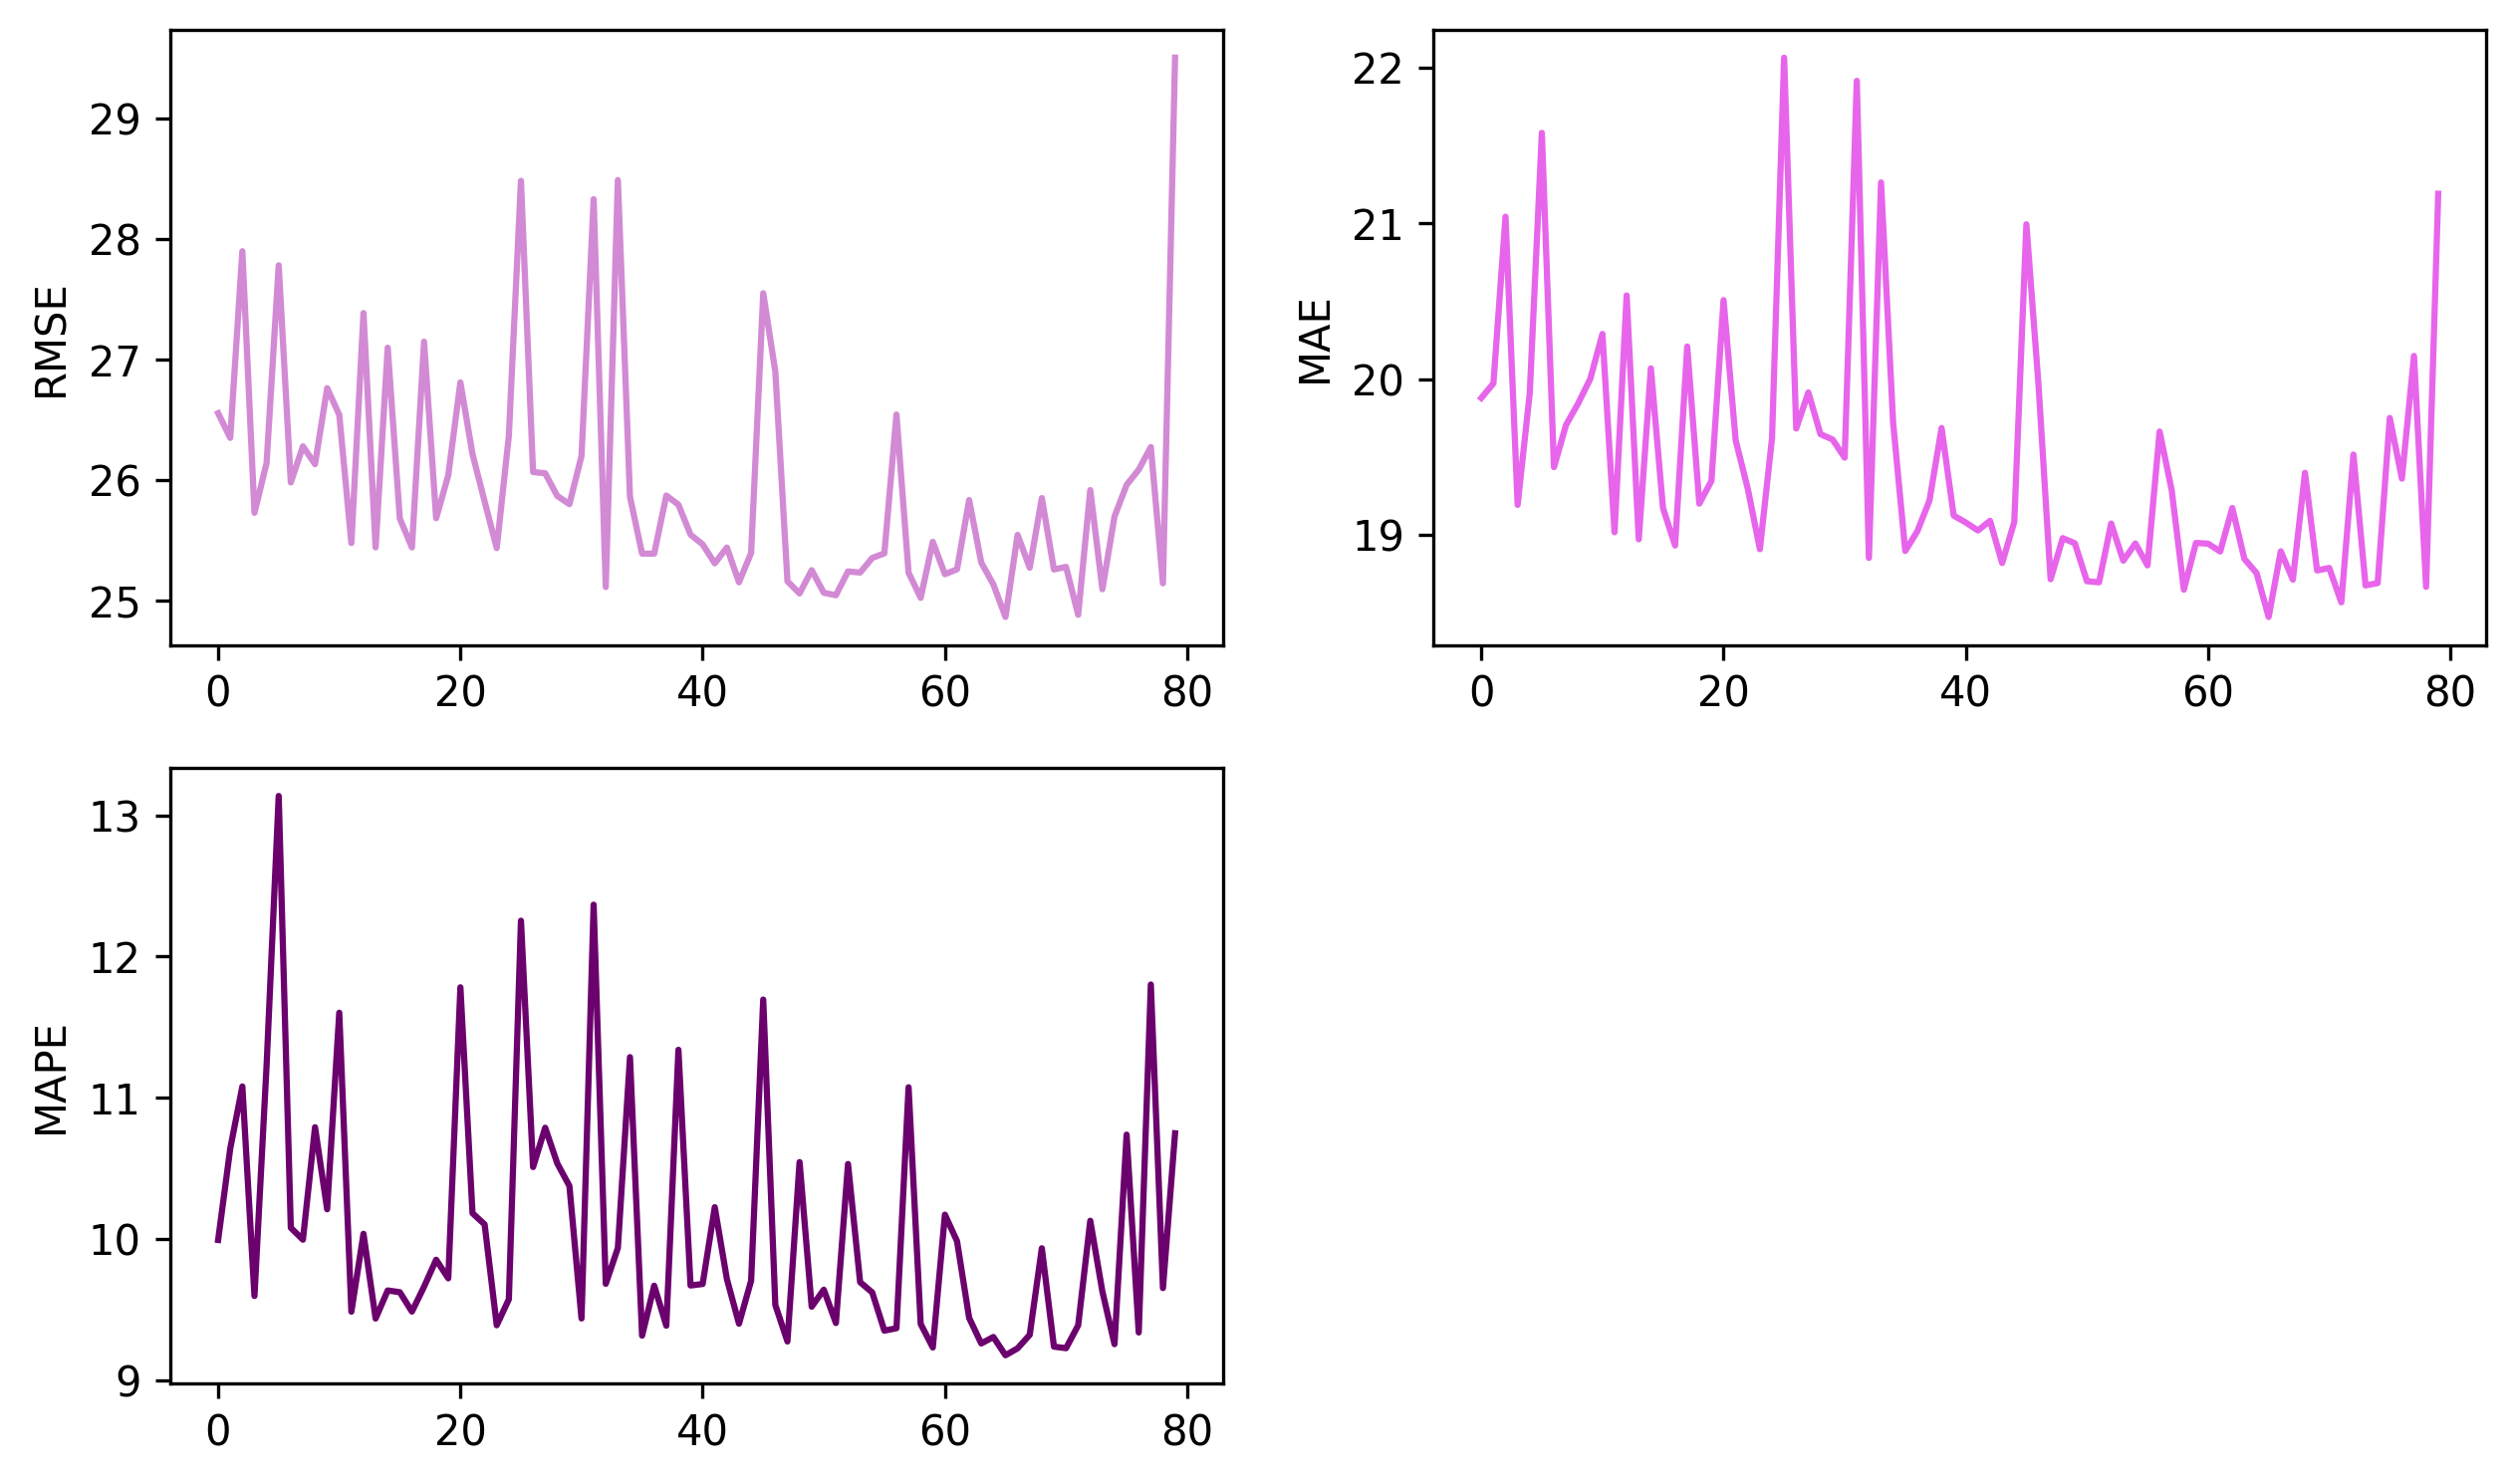

In [28]:
visualize(stop_epoch, train_loss_lst, val_loss_lst, y_label='Loss')
plot_metric(train_score_lst)
plot_metric(val_score_lst)

同样，在验证集上出现了大幅波动。

### GRU

In [29]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
input_size = train_set.X.shape[-1]
hidden_size = 64
output_size = 1
seq_len = 12
lr = 0.01
epochs = 80
loss_func = nn.MSELoss()

nn_gru = nn.GRU(input_size=input_size, hidden_size=hidden_size, num_layers=1, batch_first=True).to(device)
out_linear = nn.Sequential(nn.Linear(hidden_size, 1),
                           nn.LeakyReLU()).to(device)

optimizer = torch.optim.Adam(list(nn_gru.parameters()) + list(out_linear.parameters()), lr)

train_loss_lst, val_loss_lst, \
    train_score_lst, val_score_lst, stop_epoch = train(nn_gru, train_loader, val_loader, test_loader,
                                                       loss_func, traffic_dataset.denormalize, optimizer, epochs,
                                                       early_stop=20, device=device, output_model=out_linear)

*** epoch1, train loss 0.0018, train rmse 37.8262, val loss 0.0005, val rmse 26.313783, time use 0.926s
*** epoch2, train loss 0.0005, train rmse 25.6207, val loss 0.0005, val rmse 26.384639, time use 0.719s
*** epoch3, train loss 0.0005, train rmse 26.0646, val loss 0.0005, val rmse 26.027161, time use 0.803s
*** epoch4, train loss 0.0005, train rmse 25.7331, val loss 0.0006, val rmse 28.197680, time use 0.762s
*** epoch5, train loss 0.0005, train rmse 25.6136, val loss 0.0006, val rmse 26.901925, time use 0.796s
*** epoch6, train loss 0.0005, train rmse 25.7735, val loss 0.0005, val rmse 25.679676, time use 0.783s
*** epoch7, train loss 0.0005, train rmse 25.7374, val loss 0.0007, val rmse 29.089521, time use 0.793s
*** epoch8, train loss 0.0005, train rmse 25.4064, val loss 0.0005, val rmse 25.807989, time use 0.802s
*** epoch9, train loss 0.0005, train rmse 25.2763, val loss 0.0006, val rmse 27.515261, time use 0.785s
*** epoch10, train loss 0.0005, train rmse 25.2411, val loss 0.0

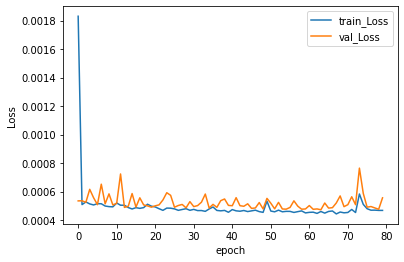

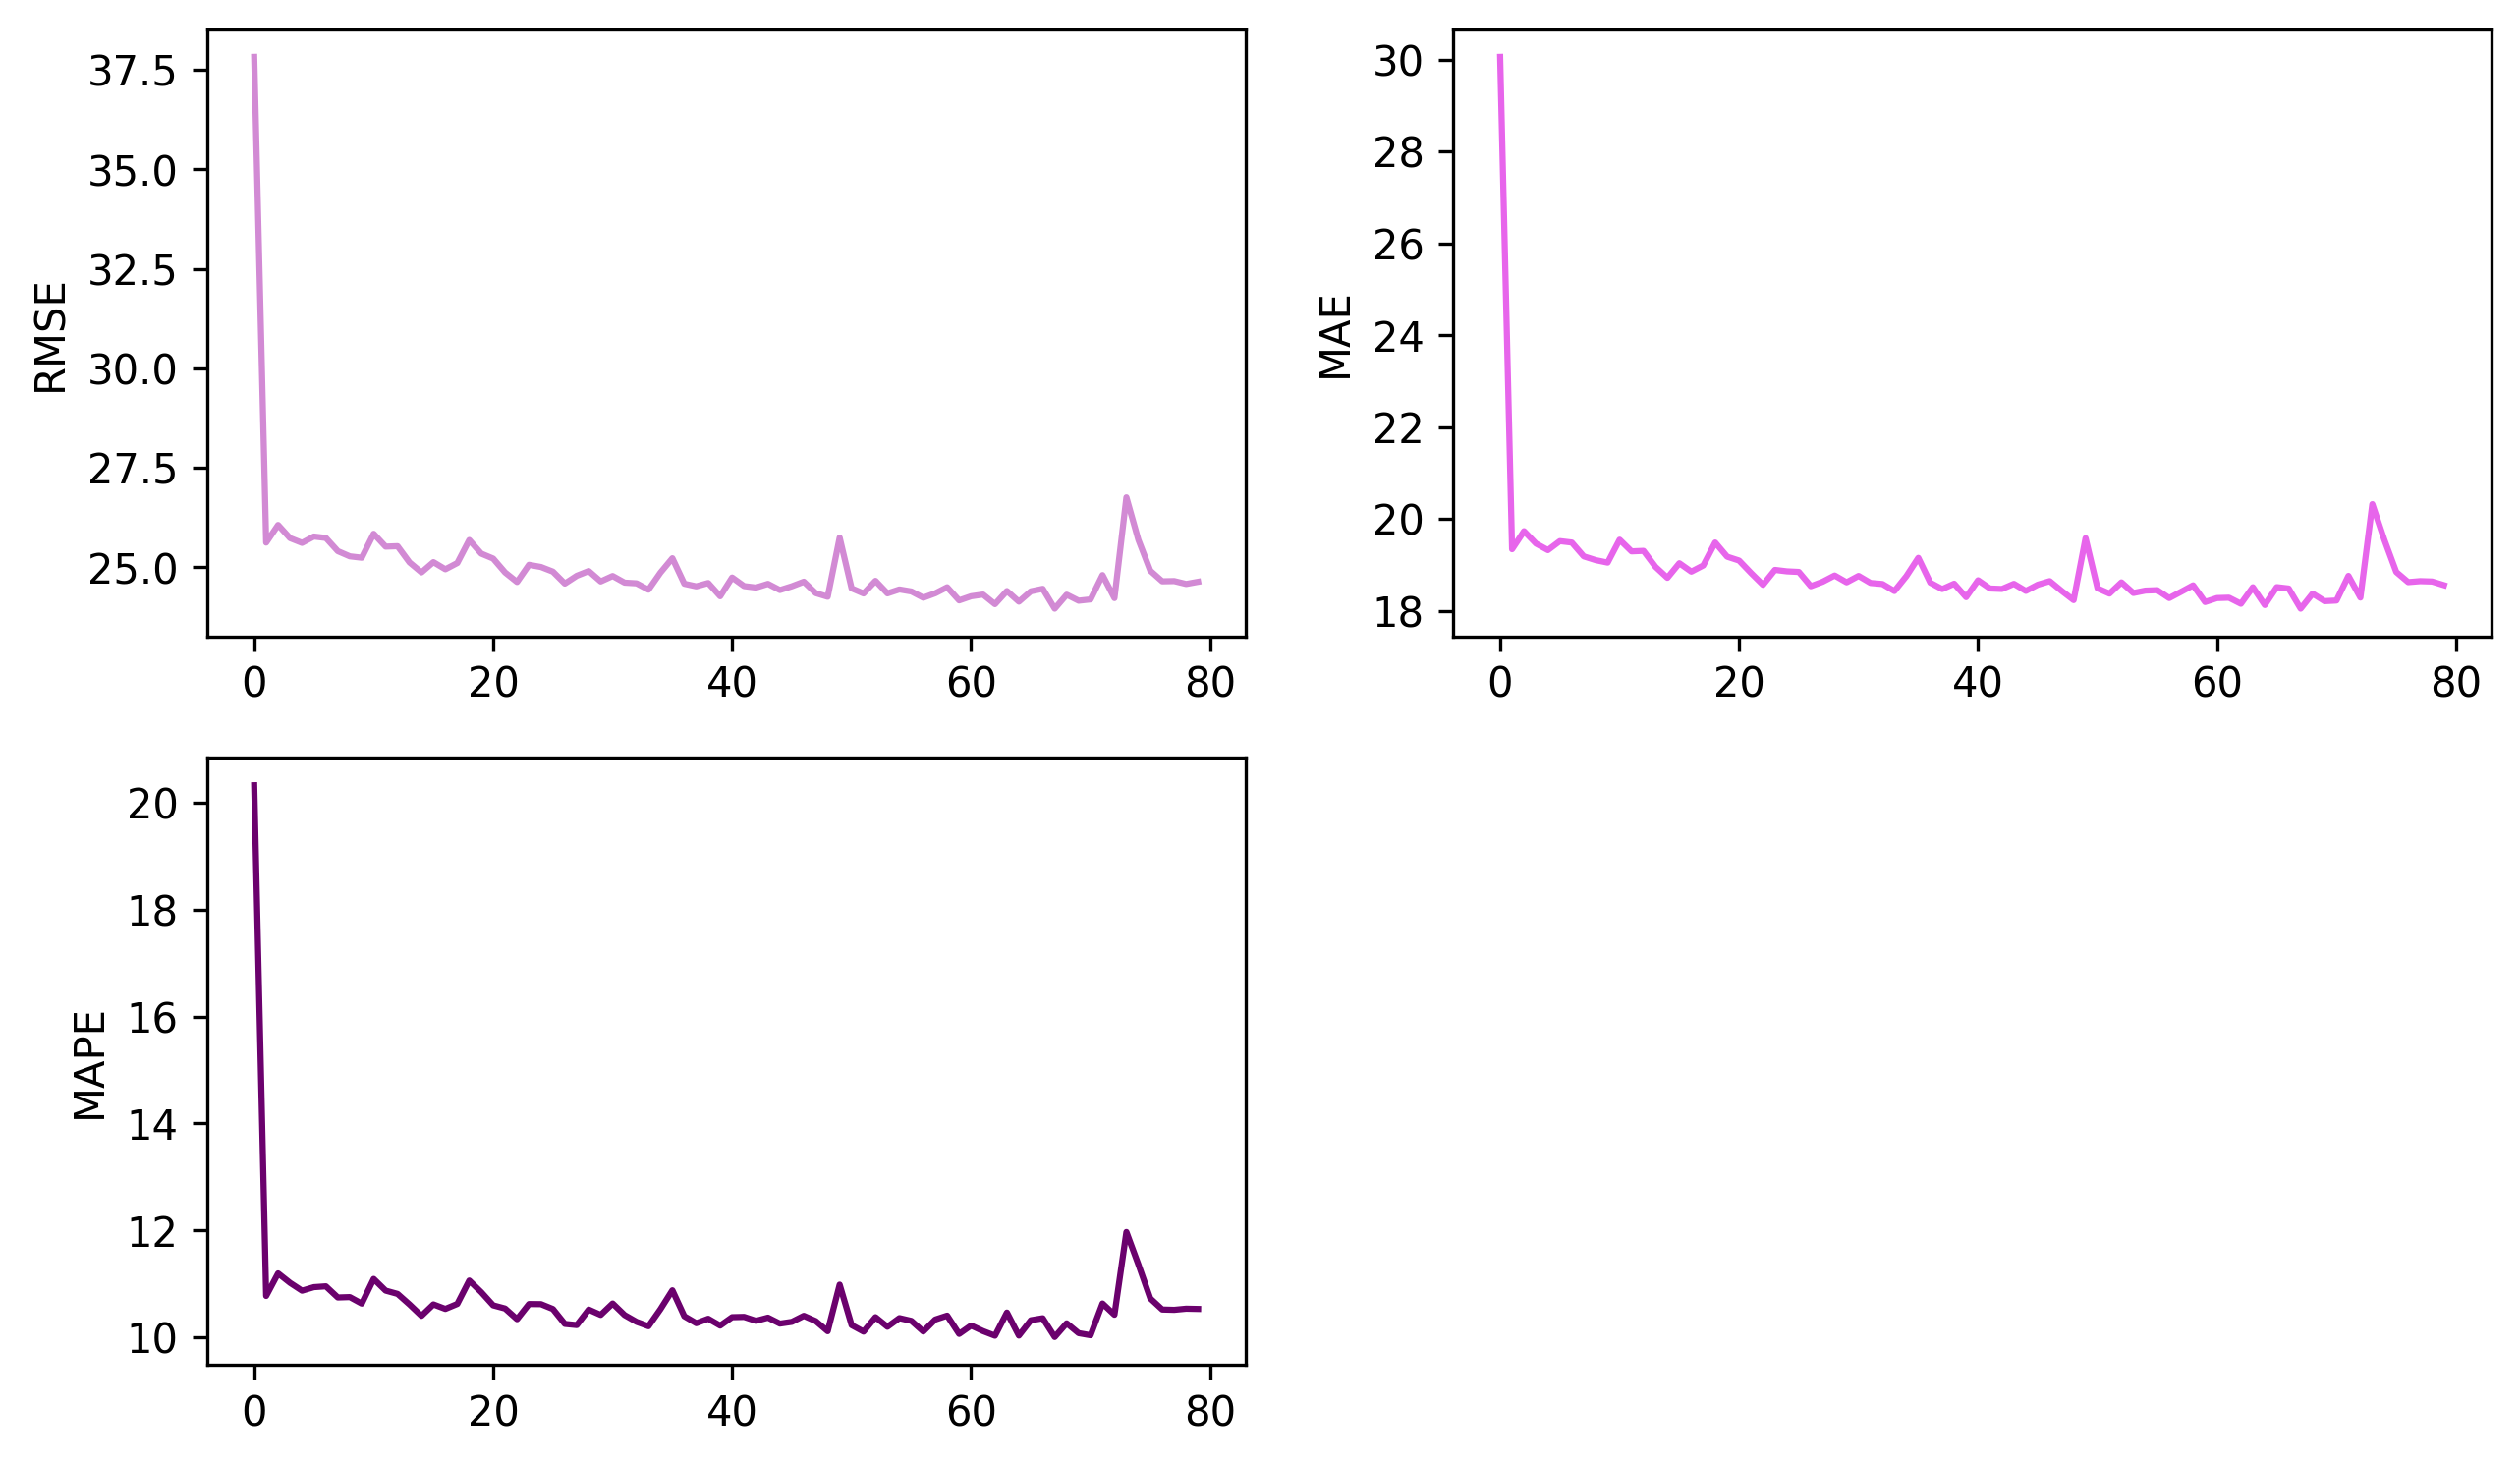

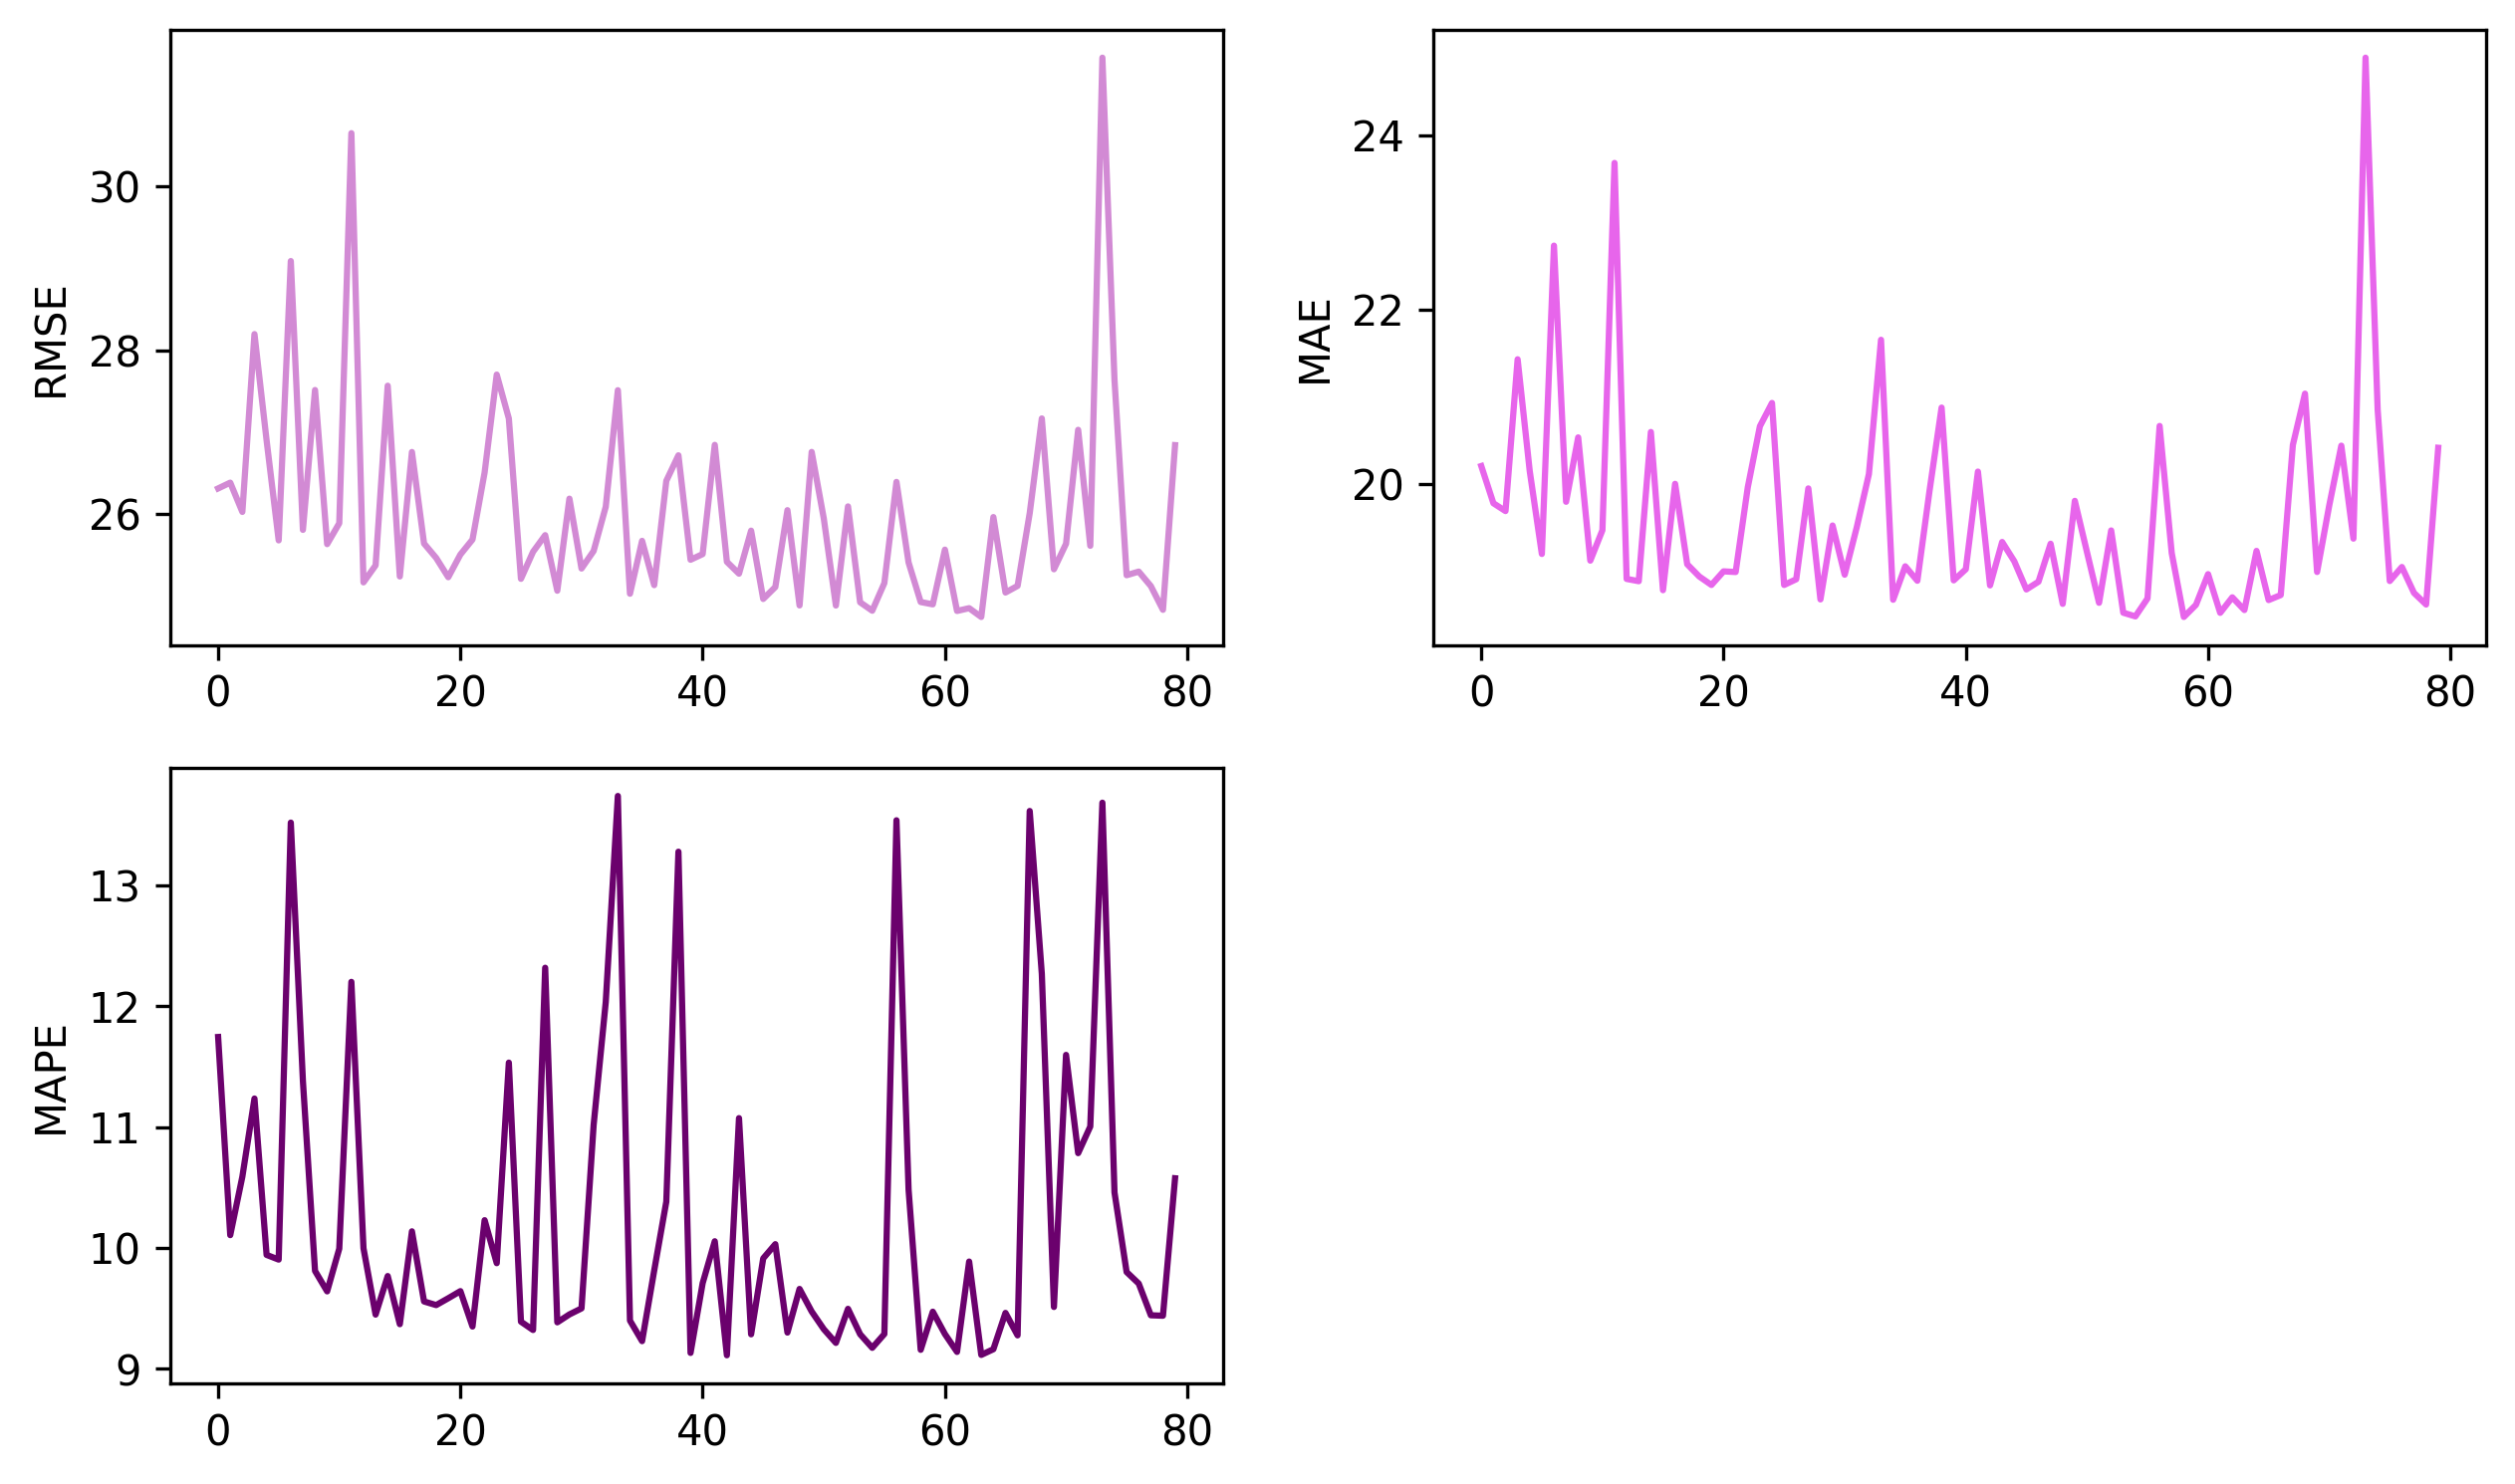

In [30]:
visualize(stop_epoch, train_loss_lst, val_loss_lst, y_label='Loss')
plot_metric(train_score_lst)
plot_metric(val_score_lst)

同样出现了大幅波动。原因同上，应该是在梯度下降时学习率过大导致路径跨度较大，而这个数据集对于这样大跨步的梯度下降容忍度可能较低，所以导致验证集上的波动很大。

# 附录：dataloader

In [ ]:
class TrafficDataset:
    def __init__(self, sensor=10, target=0):
        # 选取适当的检测器用作序列数据
        self.raw_data = np.load('./dataset/traffic-flow/traffic.npz')['data']
        self.sensor = sensor
        self.target = target
        # 数据标准化
        self.min = self.raw_data.min()
        self.max = self.raw_data.max()
        self.data = (self.raw_data - self.min) / (self.max - self.min)

    def denormalize(self, x):
        return x * (self.max - self.min) + self.min

    def construct_set(self, train_por, test_por, window_size, label=0):
        train_x = []
        train_y = []
        val_x = []
        val_y = []
        test_x = []
        test_y = []

        # 补全构造过程
        len_train = int(self.data.shape[0] * train_por)
        train_seqs = self.data[:len_train]
        for i in range(train_seqs.shape[0] - window_size):
            train_x.append(train_seqs[i:i+window_size, self.sensor, :].squeeze())
            train_y.append(train_seqs[i+window_size, self.sensor, self.target].squeeze())

        len_val = int(self.data.shape[0] * (train_por + test_por))
        val_seqs = self.data[len_train:len_val]
        #val_seqs = val_seqs.reset_index()
        for i in range(val_seqs.shape[0] - window_size):
            val_x.append(val_seqs[i:i+window_size, self.sensor, :].squeeze())
            val_y.append(val_seqs[i+window_size, self.sensor, self.target].squeeze())
        
        test_seqs = self.data[len_val:]
        #test.seqs = test_seqs.reset_index()
        for i in range(test_seqs.shape[0] - window_size):
            test_x.append(test_seqs[i:i+window_size, self.sensor, :].squeeze())
            test_y.append(test_seqs[i+window_size, self.sensor, self.target].squeeze())
        

        train_set = my_Dataset(torch.Tensor(train_x), torch.Tensor(train_y))
        val_set = my_Dataset(torch.Tensor(val_x), torch.Tensor(val_y))
        test_set = my_Dataset(torch.Tensor(test_x), torch.Tensor(test_y))
        return train_set, val_set, test_set